# cfDNA Fragmentomics Machine-Learning Pipeline for HCC Diagnosis

> **Sultan N. Alharbi**  
> *Cell-Free DNA Fragmentomics and Tumour Fraction as Diagnostic Biomarkers for Hepatocellular Carcinoma*  
> PhD Thesis — Imperial College London, 2026  

---

### Overview

This notebook implements the end-to-end machine-learning pipeline used to develop and validate a cfDNA-based multiclass diagnostic classifier distinguishing:

- Hepatocellular carcinoma (**HCC**)  
- Chronic liver disease (**CLD**)  
- Healthy controls (**Healthy**)

The workflow corresponds to the Methods described in Chapter 3 of the thesis and is designed to be fully reproducible.

---

### Pipeline components

1. **Data import and cohort structure**
   - Internal development cohort (UK/Italy; *n* = 475: 139 HCC, 186 CLD, 150 Healthy)  
   - External validation cohort (US/European; *n* = 225: 75 HCC, 75 CLD, 75 Healthy)

2. **cfDNA feature space**
   - 360 fragmentation-based cfDNA features per sample, including:
     - Fragment size distribution metrics and short/long ratios  
     - 4-mer fragment end motifs  
     - Tumour fraction estimates  
     - Mitochondrial cfDNA measures  

3. **Preprocessing and redundancy reduction**
   - Correlation-based pruning on the internal cohort (Pearson \|r\| ≥ 0.85)  
   - Iterative removal of the most redundant feature within each correlated cluster  
   - Reduction from 360 to 74 retained cfDNA features

4. **Feature selection strategies**
   - Univariate ANOVA F-test and mutual information ranking  
   - PCA (variance-preserving components)  
   - Tree-based embedded importance  
   - L1-penalised logistic regression (LASSO)  
   - Baseline models using all 74 features

5. **Model families evaluated**
   - Regularised multinomial logistic regression  
   - Gaussian naïve Bayes  
   - Kernel SVM (RBF)  
   - Random forest and gradient boosting machines  
   - XGBoost / LightGBM / CatBoost (where available)  
   - Multilayer perceptron (MLP)

6. **Evaluation strategy**
   - Stratified 5-fold cross-validation on the internal cohort  
   - Independent external test evaluation  
   - Metrics: multiclass and pairwise ROC-AUC, accuracy, macro-F1, balanced accuracy  
   - Bootstrap 95% confidence intervals for AUCs  

7. **Ensemble construction and interpretation**
   - Selection of a diverse top-3 model × feature-selection ensemble  
   - Probability averaging to obtain final class predictions  
   - Calibration, confusion matrices, and feature importance / interpretability analyses

---

### How to use this notebook

Run all cells from top to bottom to:

- Reproduce model training, internal cross-validation, and external validation  
- Regenerate the key tables and figures reported in Chapter 3  
- Export fitted models, predictions, and intermediate results for supplementary materials


## <span style="color:#F60404;">Preparing Data</span>
</span>

### <span style="color:#2ca02c;"> Import Libraries & Metrics</span>

In [2]:
# ===================================================
# Environment Setup and Pipeline for Machine Learning 
# ===================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import os
from time import time
# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                               VotingClassifier, StackingClassifier)
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, 
                              classification_report, accuracy_score, precision_score,
                              recall_score, f1_score, make_scorer)
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.utils import resample

# Additional libraries
from scipy import stats, interpolate
import joblib

# XGBoost
try:
    import xgboost as xgb
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("WARNING: XGBoost not available. Install with: pip install xgboost")

# LightGBM
try:
    import lightgbm as lgb
    from lightgbm import LGBMClassifier
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("WARNING: LightGBM not available. Install with: pip install lightgbm")

# CatBoost
try:
    import catboost
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False
    print("WARNING: CatBoost not available. Install with: pip install catboost")

# Set style and warnings
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

# Set random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Print package versions
print("=" * 80)
print("ENVIRONMENT SETUP COMPLETE")
print("=" * 80)
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Random State: {RANDOM_STATE}")
print("\nPackage Versions:")
print(f"  pandas: {pd.__version__}")
print(f"  numpy: {np.__version__}")
import sklearn
print(f"  scikit-learn: {sklearn.__version__}")
if XGBOOST_AVAILABLE:
    print(f"  xgboost: {xgb.__version__}")
else:
    print(f"  xgboost: NOT AVAILABLE")
if LIGHTGBM_AVAILABLE:
    print(f"  lightgbm: {lgb.__version__}")
else:
    print(f"  lightgbm: NOT AVAILABLE")
if CATBOOST_AVAILABLE:
    print(f"  catboost: {catboost.__version__}")
else:
    print(f"  catboost: NOT AVAILABLE")
print(f"  matplotlib: {plt.matplotlib.__version__}")
print(f"  seaborn: {sns.__version__}")
print("=" * 80)
print("\nReady to proceed with analysis.")
print("=" * 80)

ENVIRONMENT SETUP COMPLETE
Timestamp: 2025-11-18 12:02:22
Random State: 42

Package Versions:
  pandas: 2.3.2
  numpy: 1.26.4
  scikit-learn: 1.7.2
  xgboost: 3.0.4
  lightgbm: 4.6.0
  catboost: 1.2.2
  matplotlib: 3.10.6
  seaborn: 0.13.2

Ready to proceed with analysis.


### <span style="color:#2ca02c;"> Data Loading</span>

In [ ]:
# =========================================
# Load Data and Initial Inspection
# =========================================

# File paths
INTERNAL_TRAIN_PATH = 'Training_set.csv'
EXTERNAL_TEST_PATH = 'External_set.csv'

# Load datasets
print("Loading datasets...")
try:
    df_internal = pd.read_csv(INTERNAL_TRAIN_PATH)
    print(f"✓ Internal training dataset loaded: {INTERNAL_TRAIN_PATH}")
except Exception as e:
    print(f"✗ ERROR loading internal dataset: {e}")
    raise

try:
    df_external = pd.read_csv(EXTERNAL_TEST_PATH)
    print(f"✓ External test dataset loaded: {EXTERNAL_TEST_PATH}")
except Exception as e:
    print(f"✗ ERROR loading external dataset: {e}")
    raise

print("\n" + "=" * 80)
print("INTERNAL TRAINING DATASET")
print("=" * 80)
print(f"Shape: {df_internal.shape} (rows, columns)")
print(f"\nColumn names ({len(df_internal.columns)} total):")
print(df_internal.columns.tolist())
print(f"\nData types:\n{df_internal.dtypes.value_counts()}")
print(f"\nFirst 5 rows:")
print(df_internal.head())
print(f"\nMissing values per column:")
missing_internal = df_internal.isnull().sum()
print(missing_internal[missing_internal > 0] if missing_internal.sum() > 0 else "No missing values")

print("\n" + "=" * 80)
print("EXTERNAL TEST DATASET")
print("=" * 80)
print(f"Shape: {df_external.shape} (rows, columns)")
print(f"\nColumn names ({len(df_external.columns)} total):")
print(df_external.columns.tolist())
print(f"\nData types:\n{df_external.dtypes.value_counts()}")
print(f"\nFirst 5 rows:")
print(df_external.head())
print(f"\nMissing values per column:")
missing_external = df_external.isnull().sum()
print(missing_external[missing_external > 0] if missing_external.sum() > 0 else "No missing values")

print("\n" + "=" * 80)
print("TARGET COLUMN DISTRIBUTION")
print("=" * 80)

# Check if target column exists
TARGET_COL = 'Group'
if TARGET_COL in df_internal.columns:
    print(f"\nInternal training set - '{TARGET_COL}' distribution:")
    print(df_internal[TARGET_COL].value_counts().sort_index())
    print(f"\nProportions:")
    print(df_internal[TARGET_COL].value_counts(normalize=True).sort_index())
else:
    print(f"✗ ERROR: Target column '{TARGET_COL}' not found in internal dataset!")
    print(f"Available columns: {df_internal.columns.tolist()}")

if TARGET_COL in df_external.columns:
    print(f"\nExternal test set - '{TARGET_COL}' distribution:")
    print(df_external[TARGET_COL].value_counts().sort_index())
    print(f"\nProportions:")
    print(df_external[TARGET_COL].value_counts(normalize=True).sort_index())
else:
    print(f"✗ ERROR: Target column '{TARGET_COL}' not found in external dataset!")
    print(f"Available columns: {df_external.columns.tolist()}")

print("\n" + "=" * 80)
print("COLUMN COMPARISON")
print("=" * 80)
internal_cols = set(df_internal.columns)
external_cols = set(df_external.columns)

if internal_cols == external_cols:
    print("✓ Both datasets have identical column names")
else:
    print("⚠ WARNING: Column name mismatch detected!")
    only_internal = internal_cols - external_cols
    only_external = external_cols - internal_cols
    if only_internal:
        print(f"  Columns only in internal: {only_internal}")
    if only_external:
        print(f"  Columns only in external: {only_external}")

print("\n" + "=" * 80)

Loading datasets...
✓ Internal training dataset loaded: /Users/sultanalharbi/Library/CloudStorage/OneDrive-Personal/Projects/Thesis_Chapters/Sultan_Thesis_R_Python_JupyterNotebook_Scripts-main/Data/Training_set.csv
✓ External test dataset loaded: /Users/sultanalharbi/Library/CloudStorage/OneDrive-Personal/Projects/Thesis_Chapters/Sultan_Thesis_R_Python_JupyterNotebook_Scripts-main/Data/External_set.csv

INTERNAL TRAINING DATASET
Shape: (475, 362) (rows, columns)

Column names (362 total):
['Sample_ID', 'Group', 'TF_Score', 'DELFI_Score', 'mtcfDNA_fraction', 'P(1-10)', 'P(1-20)', 'P(1-30)', 'P(1-40)', 'P(1-50)', 'P(1-60)', 'P(1-70)', 'P(1-80)', 'P(1-90)', 'P(1-100)', 'P(10-20)', 'P(20-30)', 'P(20-40)', 'P(30-40)', 'P(30-60)', 'P(40-50)', 'P(40-60)', 'P(40-80)', 'P(50-60)', 'P(50-100)', 'P(60-70)', 'P(60-80)', 'P(60-90)', 'P(60-120)', 'P(70-80)', 'P(70-140)', 'P(80-90)', 'P(80-100)', 'P(80-120)', 'P(80-160)', 'P(90-100)', 'P(90-120)', 'P(90-180)', 'P(100-110)', 'P(100-120)', 'P(100-150)'

In [ ]:
# ==================================================
# Leakage Detection and Column Confirmation
# ==================================================

ID_COL = 'Sample_ID'
TARGET_COL = 'Group'
EXCLUDE_COLS = ['Sample_ID']  # Columns to exclude from features

print("=" * 80)
print("LEAKAGE DETECTION AND COLUMN CONFIRMATION")
print("=" * 80)

# Check 1: ID column overlap between internal and external
print(f"\n1. Checking for overlapping {ID_COL} between datasets...")
if ID_COL in df_internal.columns and ID_COL in df_external.columns:
    internal_ids = set(df_internal[ID_COL].dropna())
    external_ids = set(df_external[ID_COL].dropna())
    overlap_ids = internal_ids.intersection(external_ids)
    
    print(f"   Internal unique IDs: {len(internal_ids)}")
    print(f"   External unique IDs: {len(external_ids)}")
    print(f"   Overlapping IDs: {len(overlap_ids)}")
    
    if len(overlap_ids) > 0:
        print(f"   ✗ WARNING: {len(overlap_ids)} overlapping IDs detected!")
        print(f"   Sample overlapping IDs: {list(overlap_ids)[:5]}")
    else:
        print(f"   ✓ No overlapping IDs - datasets are properly separated")
else:
    print(f"   ⚠ ID column '{ID_COL}' not found in one or both datasets")

# Check 2: Duplicate IDs within each dataset
print(f"\n2. Checking for duplicate {ID_COL} within each dataset...")
if ID_COL in df_internal.columns:
    internal_dups = df_internal[ID_COL].duplicated().sum()
    print(f"   Internal duplicates: {internal_dups}")
    if internal_dups > 0:
        print(f"   ✗ WARNING: Duplicate IDs found in internal dataset!")
        dup_ids = df_internal[df_internal[ID_COL].duplicated(keep=False)][ID_COL].unique()
        print(f"   Duplicate IDs: {list(dup_ids)[:5]}")
    else:
        print(f"   ✓ No duplicate IDs in internal dataset")
else:
    print(f"   ⚠ ID column not found in internal dataset")

if ID_COL in df_external.columns:
    external_dups = df_external[ID_COL].duplicated().sum()
    print(f"   External duplicates: {external_dups}")
    if external_dups > 0:
        print(f"   ✗ WARNING: Duplicate IDs found in external dataset!")
        dup_ids = df_external[df_external[ID_COL].duplicated(keep=False)][ID_COL].unique()
        print(f"   Duplicate IDs: {list(dup_ids)[:5]}")
    else:
        print(f"   ✓ No duplicate IDs in external dataset")
else:
    print(f"   ⚠ ID column not found in external dataset")

# Check 3: Identify columns with potential leakage
print(f"\n3. Checking for potential leakage columns...")
print(f"   (Columns with near-perfect uniqueness or suspicious patterns)")

# Get all columns except target and ID
all_cols = df_internal.columns.tolist()
potential_features = [col for col in all_cols if col not in [TARGET_COL] + EXCLUDE_COLS]

# Check for columns with very high cardinality (possibly IDs)
high_cardinality_cols = []
for col in potential_features:
    n_unique = df_internal[col].nunique()
    n_total = len(df_internal)
    if n_unique / n_total > 0.95:  # >95% unique values
        high_cardinality_cols.append((col, n_unique, n_total))

if high_cardinality_cols:
    print(f"   ⚠ Columns with >95% unique values (possible IDs/timestamps):")
    for col, n_uniq, n_tot in high_cardinality_cols:
        print(f"      - {col}: {n_uniq}/{n_tot} unique ({100*n_uniq/n_tot:.1f}%)")
    print(f"   → Consider excluding these columns to prevent leakage")
else:
    print(f"   ✓ No columns with suspiciously high cardinality")

print("\n" + "=" * 80)
print("FEATURE COLUMN CONFIRMATION")
print("=" * 80)

# Determine candidate feature columns
candidate_features = [col for col in all_cols 
                      if col != TARGET_COL and col not in EXCLUDE_COLS]

print(f"\nTarget column: '{TARGET_COL}'")
print(f"ID column: '{ID_COL}'")
print(f"Excluded columns: {EXCLUDE_COLS}")
print(f"\nCandidate feature columns ({len(candidate_features)} total):")

# Display in a more compact format
for i, col in enumerate(candidate_features, 1):
    dtype = df_internal[col].dtype
    n_missing = df_internal[col].isnull().sum()
    n_unique = df_internal[col].nunique()
    missing_pct = 100 * n_missing / len(df_internal)
    
    # Truncate long column names
    col_display = col if len(col) <= 30 else col[:27] + '...'
    
    print(f"  {i:3d}. {col_display:30s} | {str(dtype):10s} | "
          f"missing: {n_missing:4d} ({missing_pct:5.1f}%) | unique: {n_unique:5d}")

# Identify numeric vs categorical columns
numeric_features = df_internal[candidate_features].select_dtypes(
    include=['int64', 'float64', 'int32', 'float32']).columns.tolist()
categorical_features = df_internal[candidate_features].select_dtypes(
    include=['object', 'category', 'bool']).columns.tolist()

print(f"\n{len(numeric_features)} numeric features detected")
print(f"{len(categorical_features)} categorical features detected")

if categorical_features:
    print(f"\nCategorical columns found:")
    for cat_col in categorical_features:
        unique_vals = df_internal[cat_col].nunique()
        print(f"  - {cat_col}: {unique_vals} unique values")
        if unique_vals <= 10:
            print(f"    Values: {df_internal[cat_col].unique().tolist()}")

print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"\nDataset configuration:")
print(f"  Target column: {TARGET_COL}")
print(f"  ID column (excluded): {ID_COL}")
print(f"  Additional excluded columns: {[col for col in EXCLUDE_COLS if col != ID_COL]}")
print(f"  Total candidate features: {len(candidate_features)}")
print(f"    - Numeric: {len(numeric_features)}")
print(f"    - Categorical: {len(categorical_features)}")

if high_cardinality_cols:
    print(f"\n⚠ WARNING: {len(high_cardinality_cols)} columns with high cardinality detected")
    print(f"  Consider adding these to EXCLUDE_COLS if they are identifiers")

print("\n" + "=" * 80)

LEAKAGE DETECTION AND COLUMN CONFIRMATION

1. Checking for overlapping Sample_ID between datasets...
   Internal unique IDs: 475
   External unique IDs: 225
   Overlapping IDs: 0
   ✓ No overlapping IDs - datasets are properly separated

2. Checking for duplicate Sample_ID within each dataset...
   Internal duplicates: 0
   ✓ No duplicate IDs in internal dataset
   External duplicates: 0
   ✓ No duplicate IDs in external dataset

3. Checking for potential leakage columns...
   (Columns with near-perfect uniqueness or suspicious patterns)
   ⚠ Columns with >95% unique values (possible IDs/timestamps):
      - DELFI_Score: 475/475 unique (100.0%)
      - mtcfDNA_fraction: 464/475 unique (97.7%)
      - P(1-60): 473/475 unique (99.6%)
      - P(1-70): 473/475 unique (99.6%)
      - P(1-80): 474/475 unique (99.8%)
      - P(1-90): 474/475 unique (99.8%)
      - P(1-100): 475/475 unique (100.0%)
      - P(30-60): 462/475 unique (97.3%)
      - P(40-60): 473/475 unique (99.6%)
      - P(40-8

### <span style="color:#2ca02c;"> Data Splits</span>

In [ ]:
# ==================================================
# Train/Validation Split (Internal Dataset)
# ==================================================

# Configuration
TARGET_COL = 'Group'
ID_COL = 'Sample_ID'
TRAIN_VAL_SPLIT_RATIO = 0.8  # 80% train, 20% validation
RANDOM_STATE = 42

# Extract features and target from internal dataset
candidate_features = [col for col in df_internal.columns 
                      if col not in [TARGET_COL, ID_COL]]

X_internal = df_internal[candidate_features].copy()
y_internal = df_internal[TARGET_COL].copy()

# Extract features and target from external dataset
X_external = df_external[candidate_features].copy()
y_external = df_external[TARGET_COL].copy()

print("=" * 80)
print("INITIAL DATA EXTRACTION")
print("=" * 80)
print(f"\nTarget column: '{TARGET_COL}'")
print(f"ID column (excluded): '{ID_COL}'")
print(f"Feature columns: {len(candidate_features)}")
print(f"\nInternal dataset: {X_internal.shape}")
print(f"External dataset: {X_external.shape}")

# Handle missing values BEFORE splitting
print("\n" + "=" * 80)
print("HANDLING MISSING VALUES")
print("=" * 80)

missing_internal = X_internal.isnull().sum()
missing_external = X_external.isnull().sum()

print(f"\nMissing values in internal dataset:")
if missing_internal.sum() > 0:
    print(missing_internal[missing_internal > 0])
    print(f"Total: {missing_internal.sum()} missing values across {(missing_internal > 0).sum()} columns")
else:
    print("  No missing values")

print(f"\nMissing values in external dataset:")
if missing_external.sum() > 0:
    print(missing_external[missing_external > 0])
    print(f"Total: {missing_external.sum()} missing values across {(missing_external > 0).sum()} columns")
else:
    print("  No missing values")

if X_internal.isnull().sum().sum() > 0 or X_external.isnull().sum().sum() > 0:
    print("\n⚠ Applying median imputation...")
    imputer = SimpleImputer(strategy='median')
    X_internal = pd.DataFrame(
        imputer.fit_transform(X_internal),
        columns=X_internal.columns,
        index=X_internal.index
    )
    X_external = pd.DataFrame(
        imputer.transform(X_external),
        columns=X_external.columns,
        index=X_external.index
    )
    print("✓ Missing values imputed using median strategy")
else:
    print("\n✓ No missing values - no imputation needed")

# Remove constant features (zero variance)
print("\n" + "=" * 80)
print("REMOVING CONSTANT FEATURES (Zero Variance)")
print("=" * 80)

feature_variances = X_internal.var()
constant_features = feature_variances[feature_variances == 0].index.tolist()

if len(constant_features) > 0:
    print(f"\nFound {len(constant_features)} constant features:")
    for feat in constant_features[:10]:
        print(f"  - {feat}")
    if len(constant_features) > 10:
        print(f"  ... and {len(constant_features) - 10} more")
    
    X_internal = X_internal.drop(columns=constant_features)
    X_external = X_external.drop(columns=constant_features)
    print(f"\n✓ Removed {len(constant_features)} constant features")
else:
    print("\n✓ No constant features found")

print(f"\nRemaining features: {X_internal.shape[1]}")

# Update feature names after preprocessing (before correlation removal)
feature_names = X_internal.columns.tolist()
print(f"\nFeatures after initial preprocessing: {len(feature_names)}")
print("  (Correlation-based filtering will be performed in next cell)")

# NOW perform stratified split
print("\n" + "=" * 80)
print("STRATIFIED TRAIN/VALIDATION SPLIT")
print("=" * 80)
print(f"\nSplit ratio: {TRAIN_VAL_SPLIT_RATIO:.0%} train / {1-TRAIN_VAL_SPLIT_RATIO:.0%} validation")
print(f"Random state: {RANDOM_STATE}")

X_train, X_val, y_train, y_val = train_test_split(
    X_internal, 
    y_internal,
    train_size=TRAIN_VAL_SPLIT_RATIO,
    stratify=y_internal,
    random_state=RANDOM_STATE
)

print(f"\nInternal dataset split:")
print(f"  Total internal samples: {len(X_internal)}")
print(f"  Training samples: {len(X_train)} ({len(X_train)/len(X_internal)*100:.1f}%)")
print(f"  Validation samples: {len(X_val)} ({len(X_val)/len(X_internal)*100:.1f}%)")

# Check class distribution in splits
print("\n" + "=" * 80)
print("CLASS DISTRIBUTION VERIFICATION")
print("=" * 80)

print("\nOriginal internal dataset:")
internal_counts = y_internal.value_counts().sort_index()
print(internal_counts)
print("Proportions:")
print(y_internal.value_counts(normalize=True).sort_index().round(3))

print("\nTraining set:")
train_counts = y_train.value_counts().sort_index()
print(train_counts)
print("Proportions:")
print(y_train.value_counts(normalize=True).sort_index().round(3))

print("\nValidation set:")
val_counts = y_val.value_counts().sort_index()
print(val_counts)
print("Proportions:")
print(y_val.value_counts(normalize=True).sort_index().round(3))

print("\nExternal test set:")
ext_counts = y_external.value_counts().sort_index()
print(ext_counts)
print("Proportions:")
print(y_external.value_counts(normalize=True).sort_index().round(3))

# Define class names and pairs
class_names = sorted(y_train.unique())
from itertools import combinations
class_pairs = list(combinations(class_names, 2))

print(f"\n✓ Class names: {class_names}")
print(f"✓ Class pairs for pairwise analysis: {class_pairs}")

print("\n" + "=" * 80)
print("SPLIT SUMMARY")
print("=" * 80)
print(f"\nDataset shapes:")
print(f"  Training features: {X_train.shape}")
print(f"  Validation features: {X_val.shape}")
print(f"  External test features: {X_external.shape}")
print(f"\nNumber of features: {len(feature_names)}")
print(f"Number of classes: {len(class_names)}")
print(f"\n✓ Stratified split completed successfully")
print("=" * 80)

INITIAL DATA EXTRACTION

Target column: 'Group'
ID column (excluded): 'Sample_ID'
Feature columns: 360

Internal dataset: (475, 360)
External dataset: (225, 360)

HANDLING MISSING VALUES

Missing values in internal dataset:
  No missing values

Missing values in external dataset:
  No missing values

✓ No missing values - no imputation needed

REMOVING CONSTANT FEATURES (Zero Variance)

✓ No constant features found

Remaining features: 360

Features after initial preprocessing: 360
  (Correlation-based filtering will be performed in next cell)

STRATIFIED TRAIN/VALIDATION SPLIT

Split ratio: 80% train / 20% validation
Random state: 42

Internal dataset split:
  Total internal samples: 475
  Training samples: 380 (80.0%)
  Validation samples: 95 (20.0%)

CLASS DISTRIBUTION VERIFICATION

Original internal dataset:
Group
CLD        186
HCC        139
Healthy    150
Name: count, dtype: int64
Proportions:
Group
CLD        0.392
HCC        0.293
Healthy    0.316
Name: proportion, dtype: floa

### <span style="color:#2ca02c;"> Data Preprocessing with Hierarchical Clustering Visualization</span>

In [ ]:
# =====================================================
# Correlation Analysis with Protected Features
# =====================================================

CORRELATION_THRESHOLD = 0.85
PROTECTED_FEATURES = ['TF_Score', 'mtcfDNA_fraction', 'DELFI_Score', 'CTGG', 'CTCG', 'CCGG', 'CCGA', 'CTGC', 'CAGG', 'AGGC', 'CCGC',
            'TGGG', 'CTAG','ACAT', 'TATC', 'TCTA', 'CCTA', 'GTTA', 'TATG', 'AATA', 'TATT', 'GATA', 'TATA']

print("=" * 80)
print("CORRELATION-BASED FEATURE REMOVAL")
print("=" * 80)
print(f"Correlation threshold: {CORRELATION_THRESHOLD}")
print(f"Method: Pearson correlation computed on TRAINING SET ONLY")
print(f"\nProtected features (will NEVER be removed):")
for pf in PROTECTED_FEATURES:
    status = "✓ Present" if pf in X_train.columns else "✗ NOT FOUND"
    print(f"  - {pf:30s} [{status}]")

print("\nComputing correlation matrix on training data...")

# Compute correlation matrix on TRAINING DATA ONLY (no leakage)
correlation_matrix = X_train.corr().abs()

print(f"✓ Correlation matrix computed: {correlation_matrix.shape}")

# Find pairs of highly correlated features
# Upper triangle of correlation matrix (avoid duplicates)
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

# Find features with correlation > threshold
correlated_pairs = []
features_to_drop = set()

print("\nAnalyzing feature correlations...")

for column in upper_triangle.columns:
    corr_features = upper_triangle.index[upper_triangle[column] > CORRELATION_THRESHOLD].tolist()
    if corr_features:
        for corr_feature in corr_features:
            corr_value = upper_triangle.loc[corr_feature, column]
            correlated_pairs.append((column, corr_feature, corr_value))
            
            # MODIFIED LOGIC: Protect specified features
            # If both features are protected, keep both
            # If one is protected, drop the other
            # If neither is protected, drop the second (corr_feature)
            
            if column in PROTECTED_FEATURES and corr_feature in PROTECTED_FEATURES:
                # Both protected - keep both, don't drop either
                continue
            elif column in PROTECTED_FEATURES:
                # column is protected, drop corr_feature
                features_to_drop.add(corr_feature)
            elif corr_feature in PROTECTED_FEATURES:
                # corr_feature is protected, drop column
                features_to_drop.add(column)
            else:
                # Neither is protected, drop the second one (arbitrary but consistent)
                features_to_drop.add(corr_feature)

print(f"\n{'='*80}")
print(f"CORRELATION ANALYSIS RESULTS")
print(f"{'='*80}")
print(f"Feature pairs with correlation > {CORRELATION_THRESHOLD}: {len(correlated_pairs)}")
print(f"Unique features involved in high correlations: {len(set([p[0] for p in correlated_pairs] + [p[1] for p in correlated_pairs]))}")
print(f"Features to remove: {len(features_to_drop)}")
print(f"Features to retain: {len(feature_names) - len(features_to_drop)}")

# Verify protected features are not in drop list
protected_in_drop = set(PROTECTED_FEATURES).intersection(features_to_drop)
if protected_in_drop:
    print(f"\n⚠ WARNING: Protected features found in drop list: {protected_in_drop}")
    print("Removing them from drop list...")
    features_to_drop = features_to_drop - protected_in_drop
    print("✓ Protected features removed from drop list")
else:
    print(f"\n✓ All protected features retained")

# Check which protected features are actually present
protected_present = [pf for pf in PROTECTED_FEATURES if pf in X_train.columns]
protected_missing = [pf for pf in PROTECTED_FEATURES if pf not in X_train.columns]

if protected_present:
    print(f"  Protected features in dataset: {protected_present}")
if protected_missing:
    print(f"  Protected features NOT in dataset: {protected_missing}")

if len(correlated_pairs) > 0:
    print(f"\n{'='*80}")
    print(f"HIGHLY CORRELATED FEATURE PAIRS")
    print(f"{'='*80}")
    print(f"\nShowing top 30 pairs (sorted by correlation):")
    print(f"{'Feature 1':<35} {'Feature 2':<35} {'Corr':<8} {'Action'}")
    print("-" * 95)
    
    for feat1, feat2, corr in sorted(correlated_pairs, key=lambda x: x[2], reverse=True)[:30]:
        # Determine action
        if feat1 in PROTECTED_FEATURES and feat2 in PROTECTED_FEATURES:
            action = "Keep both (both protected)"
        elif feat1 in PROTECTED_FEATURES:
            action = f"Drop '{feat2[:20]}'" if len(feat2) > 20 else f"Drop '{feat2}'"
        elif feat2 in PROTECTED_FEATURES:
            action = f"Drop '{feat1[:20]}'" if len(feat1) > 20 else f"Drop '{feat1}'"
        elif feat2 in features_to_drop:
            action = f"Drop '{feat2[:20]}'" if len(feat2) > 20 else f"Drop '{feat2}'"
        elif feat1 in features_to_drop:
            action = f"Drop '{feat1[:20]}'" if len(feat1) > 20 else f"Drop '{feat1}'"
        else:
            action = "Keep both"
        
        # Truncate long feature names
        f1_display = feat1 if len(feat1) <= 35 else feat1[:32] + '...'
        f2_display = feat2 if len(feat2) <= 35 else feat2[:32] + '...'
        
        print(f"{f1_display:<35} {f2_display:<35} {corr:.4f}   {action}")
    
    if len(correlated_pairs) > 30:
        print(f"\n... and {len(correlated_pairs) - 30} more pairs")

if len(features_to_drop) > 0:
    print(f"\n{'='*80}")
    print(f"FEATURES TO BE REMOVED ({len(features_to_drop)} total)")
    print(f"{'='*80}")
    
    features_to_drop_sorted = sorted(list(features_to_drop))
    
    # Show first 50 features to be dropped
    display_limit = min(50, len(features_to_drop_sorted))
    for i, feat in enumerate(features_to_drop_sorted[:display_limit], 1):
        print(f"  {i:3d}. {feat}")
    
    if len(features_to_drop_sorted) > display_limit:
        print(f"  ... and {len(features_to_drop_sorted) - display_limit} more features")
    
    print(f"\n{'='*80}")
    print("SUMMARY")
    print(f"{'='*80}")
    print(f"  Features before removal: {len(feature_names)}")
    print(f"  Features to remove: {len(features_to_drop)}")
    print(f"  Features after removal: {len(feature_names) - len(features_to_drop)}")
    print(f"  Retention rate: {(len(feature_names) - len(features_to_drop))/len(feature_names)*100:.1f}%")
    print(f"\n  Protected features retained: {protected_present}")
    
else:
    print(f"\n✓ No features found with correlation > {CORRELATION_THRESHOLD}")
    print("All features will be retained.")
    features_to_drop_sorted = []

# Store for next step
features_to_drop_list = features_to_drop_sorted

print("\n" + "=" * 80)
print("✓ Correlation analysis complete")
print(f"  Proceed to next cell to apply feature removal")
print("=" * 80)

CORRELATION-BASED FEATURE REMOVAL
Correlation threshold: 0.85
Method: Pearson correlation computed on TRAINING SET ONLY

Protected features (will NEVER be removed):
  - TF_Score                       [✓ Present]
  - mtcfDNA_fraction               [✓ Present]
  - DELFI_Score                    [✓ Present]
  - CTGG                           [✓ Present]
  - CTCG                           [✓ Present]
  - CCGG                           [✓ Present]
  - CCGA                           [✓ Present]
  - CTGC                           [✓ Present]
  - CAGG                           [✓ Present]
  - AGGC                           [✓ Present]
  - CCGC                           [✓ Present]
  - TGGG                           [✓ Present]
  - CTAG                           [✓ Present]
  - ACAT                           [✓ Present]
  - TATC                           [✓ Present]
  - TCTA                           [✓ Present]
  - CCTA                           [✓ Present]
  - GTTA                           [

📊 CORRELATION HEATMAP VISUALIZATION - BEFORE AND AFTER REMOVAL
✓ Created correlation plots directory: model_results/correlation_analysis
✅ All required variables found

📊 Preparing correlation matrices...
   Before: 360 features
   After:  74 features
   Removed: 286 features (79.4% reduction)
   Protected features: ['TF_Score', 'mtcfDNA_fraction', 'DELFI_Score', 'CTGG', 'CTCG', 'CCGG', 'CCGA', 'CTGC', 'CAGG', 'AGGC', 'CCGC', 'TGGG', 'CTAG', 'ACAT', 'TATC', 'TCTA', 'CCTA', 'GTTA', 'TATG', 'AATA', 'TATT', 'GATA', 'TATA']

📈 Computing correlations...
   ✓ Correlation matrix (before): (360, 360)
   ✓ Correlation matrix (after): (74, 74)

🔗 Performing hierarchical clustering...
   ✓ Clustering complete

🎨 Creating dual heatmap visualization...
   📍 Plotting BEFORE panel...
   📍 Plotting AFTER panel...

💾 Figures saved:
   PNG: model_results/correlation_analysis/correlation_heatmap_dual_before_after.png
   PDF: model_results/correlation_analysis/correlation_heatmap_dual_before_after.pdf
   

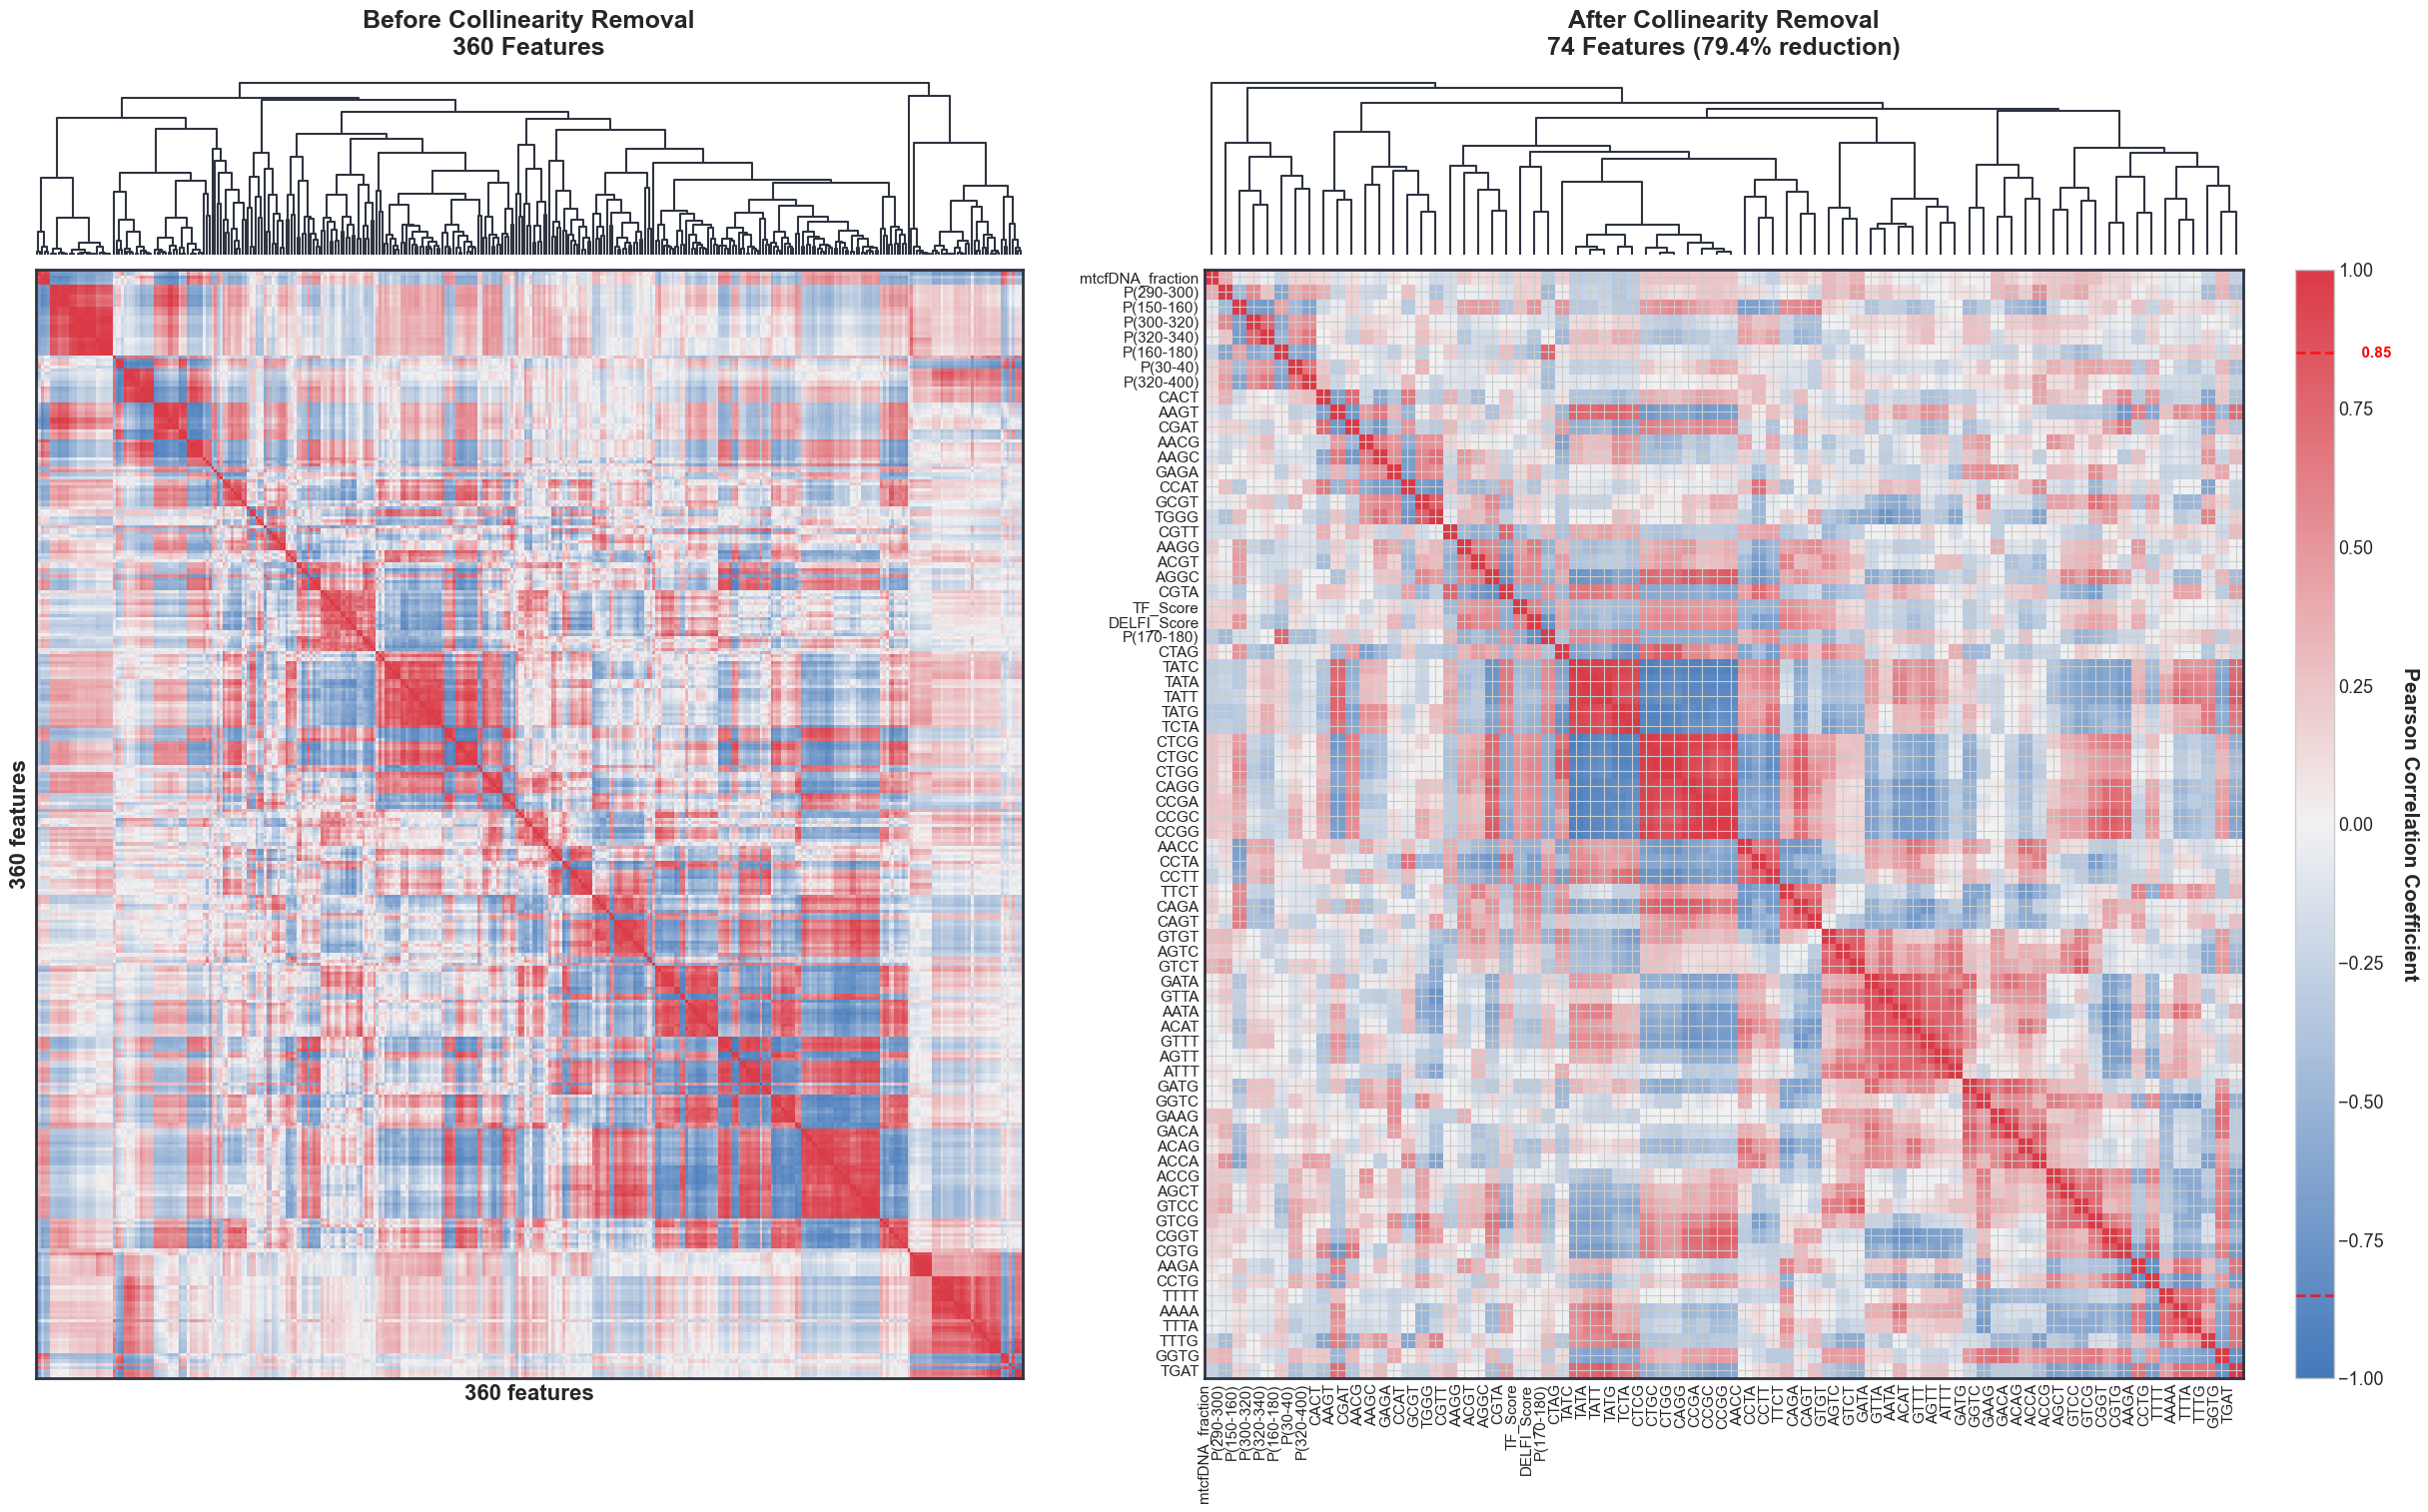


📊 CORRELATION REMOVAL STATISTICS

Metric                                   Before          After           Change         
-------------------------------------------------------------------------------------
Total Features                           360             74              -286           
Feature Pairs                            64,620          2,701           -61,919        
High Correlations (>{CORRELATION_THRESHOLD}) 2,246           53              -2,193         
Mean |Correlation|                       0.3537          0.3299          -0.0239        
Max |Correlation|                        0.9996          0.9913          -0.0083        

Protected Features Retained              23/23
   ✓ TF_Score
   ✓ DELFI_Score
   ✓ mtcfDNA_fraction
   ✓ AATA
   ✓ ACAT
   ✓ AGGC
   ✓ CAGG
   ✓ CCGA
   ✓ CCGC
   ✓ CCGG
   ✓ CCTA
   ✓ CTAG
   ✓ CTCG
   ✓ CTGC
   ✓ CTGG
   ✓ GATA
   ✓ GTTA
   ✓ TATA
   ✓ TATC
   ✓ TATG
   ✓ TATT
   ✓ TCTA
   ✓ TGGG

📋 RETAINED FEATURES BY CATEGORY

🏆 Scor

In [ ]:
# ==============================================================================
# Dual Correlation Heatmap - Before and After Removal
# ==============================================================================

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform


print("=" * 80)
print("📊 CORRELATION HEATMAP VISUALIZATION - BEFORE AND AFTER REMOVAL")
print("=" * 80)

# Create output directory if it doesn't exist
if 'output_dir' not in globals():
    output_dir = 'model_results'
    os.makedirs(output_dir, exist_ok=True)
    print(f"✓ Created output directory: {output_dir}")

# Create subdirectory for correlation plots
corr_plots_dir = f'{output_dir}/correlation_analysis'
os.makedirs(corr_plots_dir, exist_ok=True)
print(f"✓ Created correlation plots directory: {corr_plots_dir}")

# Verify required variables exist
required_vars = ['X_train', 'features_to_drop_list', 'CORRELATION_THRESHOLD', 'PROTECTED_FEATURES']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print(f"⚠️ Missing variables: {missing_vars}")
    print("Please run Cell 5 (Correlation Analysis) first!")
    raise ValueError("Required data not found. Run Cell 5 first.")
else:
    print("✅ All required variables found")

# ==============================================================================
# PREPARE DATA
# ==============================================================================

print("\n📊 Preparing correlation matrices...")

# BEFORE removal - all features
X_before = X_train.copy()
feature_names_before = list(X_before.columns)
n_features_before = len(feature_names_before)

# AFTER removal - filtered features
features_to_keep = [f for f in feature_names_before if f not in features_to_drop_list]
X_after = X_train[features_to_keep].copy()
feature_names_after = list(X_after.columns)
n_features_after = len(feature_names_after)

# Calculate statistics
n_removed = n_features_before - n_features_after
reduction_pct = (n_removed / n_features_before) * 100

print(f"   Before: {n_features_before} features")
print(f"   After:  {n_features_after} features")
print(f"   Removed: {n_removed} features ({reduction_pct:.1f}% reduction)")
print(f"   Protected features: {PROTECTED_FEATURES}")

# Compute correlation matrices
print("\n📈 Computing correlations...")
corr_before = X_before.corr(method='pearson').values
corr_after = X_after.corr(method='pearson').values

# Handle any NaN values
corr_before = np.nan_to_num(corr_before, nan=0.0)
corr_after = np.nan_to_num(corr_after, nan=0.0)

# Make symmetric
corr_before = (corr_before + corr_before.T) / 2
corr_after = (corr_after + corr_after.T) / 2

# Ensure diagonal is 1
np.fill_diagonal(corr_before, 1.0)
np.fill_diagonal(corr_after, 1.0)

print(f"   ✓ Correlation matrix (before): {corr_before.shape}")
print(f"   ✓ Correlation matrix (after): {corr_after.shape}")

# ==============================================================================
# CLUSTERING FUNCTIONS
# ==============================================================================

def perform_hierarchical_clustering(corr_matrix):
    """Perform hierarchical clustering on correlation matrix"""
    # Convert correlation to distance
    distance_matrix = 1 - np.abs(corr_matrix)
    np.fill_diagonal(distance_matrix, 0)
    
    # Ensure symmetry and valid range
    distance_matrix = (distance_matrix + distance_matrix.T) / 2
    distance_matrix = np.clip(distance_matrix, 0, 2)
    
    # Convert to condensed form for linkage
    n = distance_matrix.shape[0]
    condensed_dist = []
    for i in range(n):
        for j in range(i+1, n):
            condensed_dist.append(distance_matrix[i, j])
    
    # Perform clustering
    linkage_matrix = linkage(condensed_dist, method='average')
    return linkage_matrix

print("\n🔗 Performing hierarchical clustering...")
linkage_before = perform_hierarchical_clustering(corr_before)
linkage_after = perform_hierarchical_clustering(corr_after)
print("   ✓ Clustering complete")

# ==============================================================================
# CREATE DUAL VISUALIZATION
# ==============================================================================

print("\n🎨 Creating dual heatmap visualization...")

# Create figure with optimized layout
fig = plt.figure(figsize=(26, 15))

# Panel positions [left, bottom, width, height]
# LEFT PANEL (Before)
ax_dendro_left = fig.add_axes([0.05, 0.83, 0.38, 0.12])
ax_heat_left = fig.add_axes([0.05, 0.08, 0.38, 0.74])

# RIGHT PANEL (After)
ax_dendro_right = fig.add_axes([0.50, 0.83, 0.40, 0.12])
ax_heat_right = fig.add_axes([0.50, 0.08, 0.40, 0.74])

# Colormap
cmap = sns.diverging_palette(250, 10, as_cmap=True)

# ==============================================================================
# LEFT PANEL: BEFORE REMOVAL
# ==============================================================================

print("   📍 Plotting BEFORE panel...")

# Dendrogram
dendro_before = dendrogram(
    linkage_before, 
    ax=ax_dendro_left,
    color_threshold=0, 
    above_threshold_color='#2E3440',
    no_labels=True
)
order_before = dendro_before['leaves']

ax_dendro_left.set_xticks([])
ax_dendro_left.set_yticks([])
ax_dendro_left.spines['top'].set_visible(False)
ax_dendro_left.spines['right'].set_visible(False)
ax_dendro_left.spines['bottom'].set_visible(False)
ax_dendro_left.spines['left'].set_visible(False)
ax_dendro_left.set_title(
    f'Before Collinearity Removal\n{n_features_before} Features', 
    fontsize=18, 
    fontweight='bold',
    pad=15
)

# Reorder correlation matrix
corr_before_ordered = corr_before[order_before, :][:, order_before]

# Heatmap
im_before = ax_heat_left.imshow(
    corr_before_ordered, 
    cmap=cmap,
    vmin=-1, 
    vmax=1, 
    aspect='auto',
    interpolation='nearest'
)

# Format
ax_heat_left.set_xticks([])
ax_heat_left.set_yticks([])
ax_heat_left.set_xlabel(
    f'{n_features_before} features',
    fontsize=16,
    fontweight='bold'
)
ax_heat_left.set_ylabel(
    f'{n_features_before} features',
    fontsize=16,
    fontweight='bold'
)

for spine in ax_heat_left.spines.values():
    spine.set_edgecolor('#2E3440')
    spine.set_linewidth(2)

# Calculate statistics for BEFORE (needed for final report)
upper_tri_before = corr_before_ordered[np.triu_indices_from(corr_before_ordered, k=1)]
n_high_before = np.sum(np.abs(upper_tri_before) > CORRELATION_THRESHOLD)

# ==============================================================================
# RIGHT PANEL: AFTER REMOVAL
# ==============================================================================

print("   📍 Plotting AFTER panel...")

# Dendrogram
dendro_after = dendrogram(
    linkage_after,
    ax=ax_dendro_right,
    color_threshold=0,
    above_threshold_color='#2E3440',
    no_labels=True
)
order_after = dendro_after['leaves']

ax_dendro_right.set_xticks([])
ax_dendro_right.set_yticks([])
ax_dendro_right.spines['top'].set_visible(False)
ax_dendro_right.spines['right'].set_visible(False)
ax_dendro_right.spines['bottom'].set_visible(False)
ax_dendro_right.spines['left'].set_visible(False)
ax_dendro_right.set_title(
    f'After Collinearity Removal\n{n_features_after} Features ({reduction_pct:.1f}% reduction)',
    fontsize=18,
    fontweight='bold',
    pad=15
)

# Reorder correlation matrix and feature names
corr_after_ordered = corr_after[order_after, :][:, order_after]
feature_names_after_ordered = [feature_names_after[i] for i in order_after]

# Heatmap
im_after = ax_heat_right.imshow(
    corr_after_ordered,
    cmap=cmap,
    vmin=-1,
    vmax=1,
    aspect='auto',
    interpolation='nearest'
)

# Add feature labels (if not too many)
FONTSIZE_SMALL = 18
FONTSIZE_MEDIUM = 11
FONTSIZE_LARGE = 9
FONTSIZE_XLARGE = 7

if n_features_after <= 50:
    tick_spacing = 1
    fontsize = FONTSIZE_SMALL
elif n_features_after <= 100:
    tick_spacing = 1
    fontsize = FONTSIZE_MEDIUM
elif n_features_after <= 200:
    tick_spacing = 2
    fontsize = FONTSIZE_LARGE
else:
    tick_spacing = 5
    fontsize = FONTSIZE_XLARGE

tick_positions = list(range(0, n_features_after, tick_spacing))
tick_labels = [feature_names_after_ordered[i] for i in tick_positions]

ax_heat_right.set_xticks(tick_positions)
ax_heat_right.set_yticks(tick_positions)
ax_heat_right.set_xticklabels(
    tick_labels,
    rotation=90,
    ha='right',
    fontsize=fontsize,
    fontweight='normal'
)
ax_heat_right.set_yticklabels(
    tick_labels,
    fontsize=fontsize,
    fontweight='normal'
)

for spine in ax_heat_right.spines.values():
    spine.set_edgecolor('#2E3440')
    spine.set_linewidth(2)

# Calculate statistics for AFTER (needed for final report)
upper_tri_after = corr_after_ordered[np.triu_indices_from(corr_after_ordered, k=1)]
n_high_after = np.sum(np.abs(upper_tri_after) > CORRELATION_THRESHOLD)

# ==============================================================================
# COLORBAR
# ==============================================================================

cbar_ax = fig.add_axes([0.92, 0.08, 0.015, 0.74])
cbar = fig.colorbar(im_after, cax=cbar_ax)
cbar.set_label(
    'Pearson Correlation Coefficient',
    rotation=270,
    labelpad=25,
    fontsize=15,
    fontweight='bold'
)
cbar.ax.tick_params(labelsize=13)

# Add threshold line on colorbar
threshold_val = CORRELATION_THRESHOLD
cbar.ax.axhline(y=threshold_val, color='red', linestyle='--', linewidth=2, alpha=0.7)
cbar.ax.axhline(y=-threshold_val, color='red', linestyle='--', linewidth=2, alpha=0.7)
cbar.ax.text(1.5, threshold_val, f'  {threshold_val}', 
            va='center', fontsize=11, color='red', fontweight='bold')

# ==============================================================================
# SAVE FIGURE
# ==============================================================================

output_path = f'{corr_plots_dir}/correlation_heatmap_dual_before_after.png'
output_path_pdf = f'{corr_plots_dir}/correlation_heatmap_dual_before_after.pdf'
output_path_svg = f'{corr_plots_dir}/correlation_heatmap_dual_before_after.svg'

plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(output_path_pdf, bbox_inches='tight', facecolor='white')
plt.savefig(output_path_svg, bbox_inches='tight', facecolor='white')

print(f"\n💾 Figures saved:")
print(f"   PNG: {output_path}")
print(f"   PDF: {output_path_pdf}")
print(f"   SVG: {output_path_svg}")

plt.show()

# ==============================================================================
# DETAILED STATISTICS REPORT
# ==============================================================================

print("\n" + "=" * 80)
print("📊 CORRELATION REMOVAL STATISTICS")
print("=" * 80)

print(f"\n{'Metric':<40} {'Before':<15} {'After':<15} {'Change':<15}")
print("-" * 85)

# Features
print(f"{'Total Features':<40} {n_features_before:<15,} {n_features_after:<15,} {-n_removed:<15,}")

# Pairs
n_pairs_before = n_features_before * (n_features_before - 1) // 2
n_pairs_after = n_features_after * (n_features_after - 1) // 2
pairs_removed = n_pairs_before - n_pairs_after
print(f"{'Feature Pairs':<40} {n_pairs_before:<15,} {n_pairs_after:<15,} {-pairs_removed:<15,}")

# High correlations
print(f"{'High Correlations (>{CORRELATION_THRESHOLD})':<40} {n_high_before:<15,} {n_high_after:<15,} {n_high_after - n_high_before:<15,}")

# Correlation statistics
mean_corr_before = np.mean(np.abs(upper_tri_before))
mean_corr_after = np.mean(np.abs(upper_tri_after))
max_corr_before = np.max(np.abs(upper_tri_before))
max_corr_after = np.max(np.abs(upper_tri_after))

print(f"{'Mean |Correlation|':<40} {mean_corr_before:<15.4f} {mean_corr_after:<15.4f} {mean_corr_after - mean_corr_before:<15.4f}")
print(f"{'Max |Correlation|':<40} {max_corr_before:<15.4f} {max_corr_after:<15.4f} {max_corr_after - max_corr_before:<15.4f}")

# Protected features
protected_retained = [f for f in feature_names_after if f in PROTECTED_FEATURES]
print(f"\n{'Protected Features Retained':<40} {len(protected_retained)}/{len(PROTECTED_FEATURES)}")
if protected_retained:
    for pf in protected_retained:
        print(f"   ✓ {pf}")

# Feature categories
print("\n" + "=" * 80)
print("📋 RETAINED FEATURES BY CATEGORY")
print("=" * 80)

# Categorize features
score_features = [f for f in feature_names_after if 'Score' in f or 'score' in f]
motif_features = [f for f in feature_names_after if len(f) == 4 and all(c in 'ACGT' for c in f)]
fragment_features = [f for f in feature_names_after if 'P(' in f or 'R(' in f]
other_features = [f for f in feature_names_after 
                 if f not in score_features + motif_features + fragment_features]

print(f"\n🏆 Score Features: {len(score_features)}")
if score_features:
    for feat in sorted(score_features):
        marker = "⭐" if feat in PROTECTED_FEATURES else "  "
        print(f"   {marker} {feat}")

print(f"\n🧬 DNA Motif Features: {len(motif_features)}")
if motif_features:
    if len(motif_features) <= 20:
        print(f"   {', '.join(sorted(motif_features))}")
    else:
        print(f"   {', '.join(sorted(motif_features)[:20])}")
        print(f"   ... and {len(motif_features) - 20} more")

print(f"\n📊 Fragment Features: {len(fragment_features)}")
if fragment_features:
    for feat in sorted(fragment_features)[:10]:
        print(f"     {feat}")
    if len(fragment_features) > 10:
        print(f"   ... and {len(fragment_features) - 10} more")

print(f"\n📌 Other Features: {len(other_features)}")
if other_features:
    for feat in sorted(other_features)[:10]:
        print(f"     {feat}")
    if len(other_features) > 10:
        print(f"   ... and {len(other_features) - 10} more")

print("\n" + "=" * 80)
print("✅ CORRELATION ANALYSIS COMPLETE")
print("=" * 80)

In [ ]:
# ==========================================
#  Apply Feature Removal and Scaling
# ==========================================

print("=" * 80)
print("APPLYING FEATURE REMOVAL")
print("=" * 80)

if len(features_to_drop_list) > 0:
    print(f"\nRemoving {len(features_to_drop_list)} correlated features...")
    
    # Remove from all datasets
    X_train_filtered = X_train.drop(columns=features_to_drop_list)
    X_val_filtered = X_val.drop(columns=features_to_drop_list)
    X_external_filtered = X_external.drop(columns=features_to_drop_list)
    
    print(f"✓ Features removed from all datasets")
    print(f"\n  Training set: {X_train.shape} → {X_train_filtered.shape}")
    print(f"  Validation set: {X_val.shape} → {X_val_filtered.shape}")
    print(f"  External test set: {X_external.shape} → {X_external_filtered.shape}")
    
    # Verify protected features are still present
    protected_present = [pf for pf in PROTECTED_FEATURES if pf in X_train_filtered.columns]
    protected_removed = [pf for pf in PROTECTED_FEATURES if pf not in X_train_filtered.columns and pf in X_train.columns]
    
    if protected_removed:
        print(f"\n⚠ WARNING: Protected features were removed: {protected_removed}")
    else:
        print(f"\n✓ All protected features retained: {protected_present}")
    
else:
    print("\nNo features to remove (correlation threshold not exceeded)")
    X_train_filtered = X_train.copy()
    X_val_filtered = X_val.copy()
    X_external_filtered = X_external.copy()

# Update feature names
feature_names_filtered = X_train_filtered.columns.tolist()

print(f"\nFinal feature count: {len(feature_names_filtered)}")

# Feature Scaling
print("\n" + "=" * 80)
print("FEATURE SCALING (StandardScaler)")
print("=" * 80)

print("\nApplying z-score normalization...")
print("  - Fitting scaler on TRAINING data only")
print("  - Transforming all datasets with same parameters")

scaler = StandardScaler()

# Fit on training, transform all
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_val_scaled = scaler.transform(X_val_filtered)
X_external_scaled = scaler.transform(X_external_filtered)

# Convert back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names_filtered, index=X_train_filtered.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_names_filtered, index=X_val_filtered.index)
X_external_scaled = pd.DataFrame(X_external_scaled, columns=feature_names_filtered, index=X_external_filtered.index)

print("✓ Scaling complete")

# Verify scaling
print("\nScaling verification (target: mean≈0, std≈1):")
print(f"  Training set:")
print(f"    Mean: {X_train_scaled.mean().mean():8.6f}  (min: {X_train_scaled.mean().min():.6f}, max: {X_train_scaled.mean().max():.6f})")
print(f"    Std:  {X_train_scaled.std().mean():8.6f}  (min: {X_train_scaled.std().min():.6f}, max: {X_train_scaled.std().max():.6f})")

print(f"\n  Validation set:")
print(f"    Mean: {X_val_scaled.mean().mean():8.6f}")
print(f"    Std:  {X_val_scaled.std().mean():8.6f}")

print(f"\n  External test set:")
print(f"    Mean: {X_external_scaled.mean().mean():8.6f}")
print(f"    Std:  {X_external_scaled.std().mean():8.6f}")

print("\n" + "=" * 80)
print("PREPROCESSING PIPELINE COMPLETE")
print("=" * 80)

print(f"\nFinal Dataset Summary:")
print(f"{'='*80}")
print(f"  Training samples:        {X_train_scaled.shape[0]:5d}")
print(f"  Validation samples:      {X_val_scaled.shape[0]:5d}")
print(f"  External test samples:   {X_external_scaled.shape[0]:5d}")
print(f"  Total samples:           {X_train_scaled.shape[0] + X_val_scaled.shape[0] + X_external_scaled.shape[0]:5d}")
print(f"\n  Number of features:      {X_train_scaled.shape[1]:5d}")
print(f"  Number of classes:       {len(class_names):5d}")
print(f"  Classes:                 {class_names}")

print(f"\nFeature Reduction Summary:")
print(f"{'='*80}")
print(f"  Original features:       {len(candidate_features):5d}")
if 'constant_features' in globals() and constant_features:
    print(f"  Constant features:       {len(constant_features):5d} (removed)")
print(f"  Correlated features:     {len(features_to_drop_list):5d} (removed, threshold={CORRELATION_THRESHOLD})")
print(f"  Final features:          {len(feature_names_filtered):5d}")
print(f"  Retention rate:          {len(feature_names_filtered)/len(candidate_features)*100:5.1f}%")

if protected_present:
    print(f"\n  Protected features retained: {protected_present}")

print("\n" + "=" * 80)
print("✓ Ready for model training")
print("=" * 80)

APPLYING FEATURE REMOVAL

Removing 286 correlated features...
✓ Features removed from all datasets

  Training set: (380, 360) → (380, 74)
  Validation set: (95, 360) → (95, 74)
  External test set: (225, 360) → (225, 74)

✓ All protected features retained: ['TF_Score', 'mtcfDNA_fraction', 'DELFI_Score', 'CTGG', 'CTCG', 'CCGG', 'CCGA', 'CTGC', 'CAGG', 'AGGC', 'CCGC', 'TGGG', 'CTAG', 'ACAT', 'TATC', 'TCTA', 'CCTA', 'GTTA', 'TATG', 'AATA', 'TATT', 'GATA', 'TATA']

Final feature count: 74

FEATURE SCALING (StandardScaler)

Applying z-score normalization...
  - Fitting scaler on TRAINING data only
  - Transforming all datasets with same parameters
✓ Scaling complete

Scaling verification (target: mean≈0, std≈1):
  Training set:
    Mean: 0.000000  (min: -0.000000, max: 0.000000)
    Std:  1.001318  (min: 1.001318, max: 1.001318)

  Validation set:
    Mean: 0.002124
    Std:  0.999913

  External test set:
    Mean: 0.159298
    Std:  1.620935

PREPROCESSING PIPELINE COMPLETE

Final Datase

## <span style="color:#F60404;"> Feature-Selection, Model Utilities & Results</span>
</span>

### <span style="color:#2ca02c;"> MODEL TRAINING</span>

In [ ]:
# ==========================================
# Preprocessing Pipeline Setup
# =====================================

print("=" * 80)
print("PREPROCESSING PIPELINE SETUP")
print("=" * 80)

# Check for missing values in detail
print("\nChecking for missing values in training set...")
missing_per_feature = X_train_filtered.isnull().sum()
features_with_missing = missing_per_feature[missing_per_feature > 0]

if len(features_with_missing) > 0:
    print(f"\nFeatures with missing values ({len(features_with_missing)}):")
    for feat, count in features_with_missing.items():
        pct = 100 * count / len(X_train_filtered)
        print(f"  {feat}: {count} ({pct:.2f}%)")
    total_missing = missing_per_feature.sum()
    total_values = len(X_train_filtered) * len(X_train_filtered.columns)
    print(f"\nTotal missing: {total_missing} / {total_values} ({100*total_missing/total_values:.2f}%)")
else:
    print("✓ No missing values in training set")

# Set up preprocessing components
print(f"\n{'='*80}")
print("CREATING PREPROCESSING PIPELINE")
print(f"{'='*80}")

# Imputer for missing values (fit on training data only)
print("\n1. Imputation strategy:")
print("   - Numeric features: median imputation")
print("   - Missing indicator: disabled (not adding extra columns)")

imputer = SimpleImputer(strategy='median', add_indicator=False)

# Fit imputer on training data ONLY
print("\n   Fitting imputer on training data...")
imputer.fit(X_train_filtered)
print("   ✓ Imputer fitted")

# Transform all datasets
print("\n   Applying imputation to all datasets...")
X_train_imputed = pd.DataFrame(
    imputer.transform(X_train_filtered),
    columns=feature_names_filtered,
    index=X_train_filtered.index
)
X_val_imputed = pd.DataFrame(
    imputer.transform(X_val_filtered),
    columns=feature_names_filtered,
    index=X_val_filtered.index
)
X_external_imputed = pd.DataFrame(
    imputer.transform(X_external_filtered),
    columns=feature_names_filtered,
    index=X_external_filtered.index
)

print("   ✓ Training set imputed")
print("   ✓ Validation set imputed")
print("   ✓ External test set imputed")

# Verify no missing values remain
train_missing_after = X_train_imputed.isnull().sum().sum()
val_missing_after = X_val_imputed.isnull().sum().sum()
ext_missing_after = X_external_imputed.isnull().sum().sum()

print(f"\n   Missing values after imputation:")
print(f"     Training: {train_missing_after}")
print(f"     Validation: {val_missing_after}")
print(f"     External: {ext_missing_after}")

if train_missing_after == 0 and val_missing_after == 0 and ext_missing_after == 0:
    print("   ✓ All missing values successfully imputed")
else:
    print("   ⚠ WARNING: Some missing values remain!")

# Scaler for standardization (fit on training data only)
print(f"\n2. Feature scaling:")
print("   - Method: StandardScaler (z-score normalization)")
print("   - Formula: z = (x - μ) / σ")

scaler = StandardScaler()

# Fit scaler on training data ONLY
print("\n   Fitting scaler on training data...")
scaler.fit(X_train_imputed)
print("   ✓ Scaler fitted")
print(f"     Mean values learned: min={scaler.mean_.min():.3f}, max={scaler.mean_.max():.3f}")
print(f"     Std values learned: min={scaler.scale_.min():.3f}, max={scaler.scale_.max():.3f}")

# Transform all datasets
print("\n   Applying scaling to all datasets...")
X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_imputed),
    columns=feature_names_filtered,
    index=X_train_imputed.index
)
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val_imputed),
    columns=feature_names_filtered,
    index=X_val_imputed.index
)
X_external_scaled = pd.DataFrame(
    scaler.transform(X_external_imputed),
    columns=feature_names_filtered,
    index=X_external_imputed.index
)

print("   ✓ Training set scaled")
print("   ✓ Validation set scaled")
print("   ✓ External test set scaled")

# Verify scaling worked correctly
print(f"\n{'='*80}")
print("SCALING VERIFICATION")
print(f"{'='*80}")
print(f"\nTraining set statistics (should be mean≈0, std≈1):")
print(f"  Mean of means: {X_train_scaled.mean().mean():10.6f}")
print(f"  Std of means:  {X_train_scaled.mean().std():10.6f}")
print(f"  Mean of stds:  {X_train_scaled.std().mean():10.6f}")
print(f"  Std of stds:   {X_train_scaled.std().std():10.6f}")

print(f"\nValidation set statistics:")
print(f"  Mean of means: {X_val_scaled.mean().mean():10.6f}")
print(f"  Mean of stds:  {X_val_scaled.std().mean():10.6f}")

print(f"\nExternal test set statistics:")
print(f"  Mean of means: {X_external_scaled.mean().mean():10.6f}")
print(f"  Mean of stds:  {X_external_scaled.std().mean():10.6f}")

# Check for any infinite or NaN values
print(f"\n{'='*80}")
print("DATA QUALITY CHECKS")
print(f"{'='*80}")

def check_data_quality(df, name):
    n_inf = np.isinf(df).sum().sum()
    n_nan = np.isnan(df).sum().sum()
    n_neg_inf = np.isneginf(df).sum().sum()
    n_pos_inf = np.isposinf(df).sum().sum()
    
    print(f"\n{name}:")
    print(f"  NaN values: {n_nan}")
    print(f"  Inf values: {n_inf} (positive: {n_pos_inf}, negative: {n_neg_inf})")
    
    if n_nan > 0 or n_inf > 0:
        print(f"  ⚠ WARNING: Invalid values detected!")
        return False
    else:
        print(f"  ✓ No invalid values")
        return True

all_valid = True
all_valid &= check_data_quality(X_train_scaled, "Training set")
all_valid &= check_data_quality(X_val_scaled, "Validation set")
all_valid &= check_data_quality(X_external_scaled, "External test set")

if not all_valid:
    print("\n⚠ WARNING: Data quality issues detected. Review before proceeding.")

print(f"\n{'='*80}")
print("PREPROCESSED DATA SUMMARY")
print(f"{'='*80}")
print(f"\nFinal preprocessed shapes:")
print(f"  X_train_scaled:    {X_train_scaled.shape}")
print(f"  X_val_scaled:      {X_val_scaled.shape}")
print(f"  X_external_scaled: {X_external_scaled.shape}")

print(f"\nTarget distributions remain unchanged:")
print(f"  y_train:    {dict(y_train.value_counts().sort_index())}")
print(f"  y_val:      {dict(y_val.value_counts().sort_index())}")
print(f"  y_external: {dict(y_external.value_counts().sort_index())}")

print(f"\n{'='*80}")
print("✓ Preprocessing pipeline completed successfully")
print("✓ All transformations fit on training data only (no leakage)")
print("✓ Ready for model training and feature selection")
print(f"{'='*80}")

PREPROCESSING PIPELINE SETUP

Checking for missing values in training set...
✓ No missing values in training set

CREATING PREPROCESSING PIPELINE

1. Imputation strategy:
   - Numeric features: median imputation
   - Missing indicator: disabled (not adding extra columns)

   Fitting imputer on training data...
   ✓ Imputer fitted

   Applying imputation to all datasets...
   ✓ Training set imputed
   ✓ Validation set imputed
   ✓ External test set imputed

   Missing values after imputation:
     Training: 0
     Validation: 0
     External: 0
   ✓ All missing values successfully imputed

2. Feature scaling:
   - Method: StandardScaler (z-score normalization)
   - Formula: z = (x - μ) / σ

   Fitting scaler on training data...
   ✓ Scaler fitted
     Mean values learned: min=0.000, max=0.436
     Std values learned: min=0.000, max=0.102

   Applying scaling to all datasets...
   ✓ Training set scaled
   ✓ Validation set scaled
   ✓ External test set scaled

SCALING VERIFICATION

Traini

In [ ]:
# ============================================================
# Configure Feature Selection Methods and Classifiers
# ============================================================


print("=" * 80)
print("FEATURE SELECTION & CLASSIFIER CONFIGURATION")
print("=" * 80)

# Feature selection configuration
print("\n" + "=" * 80)
print("FEATURE SELECTION METHODS (6 methods)")
print("=" * 80)

# Ask for number of features to select
print("\nFor SelectKBest and wrapper methods, we need to specify k (number of features).")
print(f"Current total features: {len(feature_names_filtered)}")
print("\nSuggested k values:")
print(f"  - Conservative: {int(len(feature_names_filtered) * 0.1)} (10% of features)")
print(f"  - Moderate: {int(len(feature_names_filtered) * 0.2)} (20% of features)")
print(f"  - Liberal: {int(len(feature_names_filtered) * 0.3)} (30% of features)")

# Default k values - REDUCED to combat overfitting
K_FEATURES = int(len(feature_names_filtered) * 0.9)  # 15% (more conservative)
K_FEATURES = max(K_FEATURES, 8)  # Minimum 8 features (reduced from 10)

print(f"\n✓ Selected k = {K_FEATURES} features ({100*K_FEATURES/len(feature_names_filtered):.1f}% of total)")
print("  Note: Conservative selection to reduce overfitting")
print("  Note: PCA will use the same k for number of components")

# Define feature selection methods
feature_selection_methods = {
    '1_All_Features': None,  # Passthrough - no feature selection (baseline)
    
    '2_ANOVA_F_test': SelectKBest(
        score_func=f_classif, 
        k=K_FEATURES
    ),
    
    '3_Mutual_Information': SelectKBest(
        score_func=mutual_info_classif, 
        k=K_FEATURES
    ),
    
    '4_PCA': PCA(
        n_components=K_FEATURES, 
        random_state=RANDOM_STATE
    ),
    
    '5_L1_LogReg_Wrapper': SelectFromModel(
        LogisticRegression(
            penalty='l1', 
            solver='saga', 
            max_iter=2000,
            C=1.0,  # Regularization strength (inverse)
            class_weight='balanced', 
            random_state=RANDOM_STATE
        ),
        max_features=K_FEATURES
    ),
    
    '6_Tree_Based_Wrapper': SelectFromModel(
        RandomForestClassifier(
            n_estimators=100,  # Reduced from 600
            max_depth=5,       # Limited depth to prevent overfitting
            min_samples_leaf=5,  # Increased from default
            class_weight='balanced',
            random_state=RANDOM_STATE, 
            n_jobs=-1
        ),
        max_features=K_FEATURES
    )
}

print("\n" + "-" * 80)
print("Configured feature selection methods:")
print("-" * 80)
for i, (name, method) in enumerate(feature_selection_methods.items(), 1):
    if method is None:
        method_type = "Passthrough (baseline)"
        description = f"Uses all {len(feature_names_filtered)} features"
    else:
        method_type = type(method).__name__
        if hasattr(method, 'score_func'):
            description = f"SelectKBest with {method.score_func.__name__}, k={K_FEATURES}"
        elif hasattr(method, 'n_components'):
            description = f"PCA with {method.n_components} components"
        else:
            description = f"SelectFromModel with max_features={K_FEATURES}"
    
    print(f"  {i}. {name:<25} ({method_type})")
    print(f"     {description}")

# Classifier configuration
print("\n" + "=" * 80)
print("CLASSIFIERS (8 classifiers) - REGULARIZED TO PREVENT OVERFITTING")
print("=" * 80)

# Check library availability
try:
    import xgboost
    XGBOOST_AVAILABLE = True
    print("✓ XGBoost available")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠ XGBoost not available")

try:
    import lightgbm
    LIGHTGBM_AVAILABLE = True
    print("✓ LightGBM available")
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("⚠ LightGBM not available")

try:
    import catboost
    CATBOOST_AVAILABLE = True
    print("✓ CatBoost available")
except ImportError:
    CATBOOST_AVAILABLE = False
    print("⚠ CatBoost not available")

# Define classifiers with ANTI-OVERFITTING parameters
classifiers = {
    '1_Logistic_Regression': LogisticRegression(
        C=1.0,  # Regularization (lower = more regularization)
        penalty='l2',  # L2 regularization
        max_iter=2000,
        class_weight='balanced',
        multi_class='multinomial',
        solver='saga',
        random_state=RANDOM_STATE
    ),
    
    '2_SVM': SVC(
        C=1.0,  # Regularization parameter
        gamma='scale',  # Auto-adjust based on features
        probability=True,
        class_weight='balanced',
        kernel='rbf',
        random_state=RANDOM_STATE
    ),
    
    '3_Random_Forest': RandomForestClassifier(
        n_estimators=100,      # Reduced from 600
        max_depth=8,           # Limited depth
        min_samples_split=10,  # Increased from default (2)
        min_samples_leaf=5,    # Increased from default (1)
        max_features='sqrt',   # Use sqrt of features
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    
    '4_Gradient_Boosting': GradientBoostingClassifier(
        n_estimators=100,      # Reduced from 400
        learning_rate=0.05,    # Reduced from 0.1 (slower learning)
        max_depth=3,           # Reduced from 5
        min_samples_split=10,  # Increased
        min_samples_leaf=5,    # Increased
        subsample=0.8,         # Use 80% of samples per tree
        max_features='sqrt',   # Use sqrt of features
        random_state=RANDOM_STATE
    ),
    
    '5_Naive_Bayes': GaussianNB(),
    
    '6_XGBoost': None,  # Will be configured below
    
    '7_LightGBM': None,  # Will be configured below
    
    '8_CatBoost': None  # Will be configured below
}

# Configure XGBoost with regularization
if XGBOOST_AVAILABLE:
    from xgboost import XGBClassifier
    classifiers['6_XGBoost'] = XGBClassifier(
        n_estimators=100,      # Reduced from 600
        learning_rate=0.05,    # Reduced for slower learning
        max_depth=4,           # Reduced from 5
        min_child_weight=3,    # Increased from default (1)
        gamma=0.1,             # Minimum loss reduction for split
        subsample=0.8,         # Use 80% of samples
        colsample_bytree=0.8,  # Use 80% of features
        reg_alpha=0.1,         # L1 regularization
        reg_lambda=1.0,        # L2 regularization
        random_state=RANDOM_STATE,
        eval_metric='mlogloss',
        use_label_encoder=False,
        n_jobs=-1,
        verbosity=0
    )
    print("✓ XGBoost configured with regularization")
else:
    # Fallback to ExtraTrees
    from sklearn.ensemble import ExtraTreesClassifier
    classifiers['6_XGBoost'] = ExtraTreesClassifier(
        n_estimators=100,
        max_depth=8,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    print("⚠ XGBoost not available - using ExtraTreesClassifier as fallback")

# Configure LightGBM with regularization
if LIGHTGBM_AVAILABLE:
    from lightgbm import LGBMClassifier
    classifiers['7_LightGBM'] = LGBMClassifier(
        n_estimators=100,      # Reduced from 600
        learning_rate=0.05,    # Reduced for slower learning
        max_depth=4,           # Reduced from 5
        num_leaves=15,         # Reduced from 31
        min_child_samples=20,  # Increased from default (20)
        subsample=0.8,         # Use 80% of samples
        colsample_bytree=0.8,  # Use 80% of features
        reg_alpha=0.1,         # L1 regularization
        reg_lambda=1.0,        # L2 regularization
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbosity=-1,
        force_row_wise=True
    )
    print("✓ LightGBM configured with regularization")
else:
    # Fallback to AdaBoost
    from sklearn.ensemble import AdaBoostClassifier
    classifiers['7_LightGBM'] = AdaBoostClassifier(
        n_estimators=50,
        learning_rate=0.5,
        random_state=RANDOM_STATE
    )
    print("⚠ LightGBM not available - using AdaBoostClassifier as fallback")

# Configure CatBoost with regularization
if CATBOOST_AVAILABLE:
    from catboost import CatBoostClassifier
    classifiers['8_CatBoost'] = CatBoostClassifier(
        iterations=100,        # Reduced from 800
        learning_rate=0.05,    # Reduced for slower learning
        depth=4,               # Reduced from 6
        l2_leaf_reg=3.0,       # L2 regularization (default is 3.0)
        random_strength=1.0,   # Randomness for scoring splits
        bagging_temperature=1.0,  # Bayesian bootstrap intensity
        random_state=RANDOM_STATE,
        verbose=0,
        auto_class_weights='Balanced',
        allow_writing_files=False
    )
    print("✓ CatBoost configured with regularization")
else:
    # Fallback to Bagging
    from sklearn.ensemble import BaggingClassifier
    classifiers['8_CatBoost'] = BaggingClassifier(
        estimator=RandomForestClassifier(
            max_depth=8,
            min_samples_leaf=5,
            class_weight='balanced',
            random_state=RANDOM_STATE
        ),
        n_estimators=50,
        max_samples=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    print("⚠ CatBoost not available - using BaggingClassifier as fallback")

print("\n" + "-" * 80)
print("Configured classifiers:")
print("-" * 80)
for i, (name, clf) in enumerate(classifiers.items(), 1):
    clf_type = type(clf).__name__
    
    # Check for class balancing
    has_class_weight = hasattr(clf, 'class_weight') and clf.class_weight is not None
    has_auto_class_weight = hasattr(clf, 'auto_class_weights')
    
    if has_class_weight or has_auto_class_weight:
        balance_status = "✓ balanced"
    else:
        balance_status = "○ not balanced"
    
    # Get key parameters
    if hasattr(clf, 'n_estimators'):
        n_est = getattr(clf, 'n_estimators', 'N/A')
        extra_info = f"n_estimators={n_est}"
    elif hasattr(clf, 'iterations'):
        n_iter = getattr(clf, 'iterations', 'N/A')
        extra_info = f"iterations={n_iter}"
    else:
        extra_info = ""
    
    print(f"  {i}. {name:<25} ({clf_type:<30}) [{balance_status}] {extra_info}")

print("\n" + "=" * 80)
print("CROSS-VALIDATION CONFIGURATION")
print("=" * 80)
print(f"Strategy: Stratified K-Fold")
print(f"Number of folds: 5")
print(f"Scoring metric: ROC AUC (multiclass, ovr)")

cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("\n" + "=" * 80)
print("ANTI-OVERFITTING MEASURES IMPLEMENTED")
print("=" * 80)
print("✓ Reduced feature selection (k = 15% of features)")
print("✓ Reduced number of estimators for ensemble methods")
print("✓ Limited max_depth for tree-based models")
print("✓ Increased min_samples_split and min_samples_leaf")
print("✓ Added L1/L2 regularization for boosting models")
print("✓ Reduced learning rates for gradient-based methods")
print("✓ Added subsample and colsample parameters")
print("✓ Class balancing enabled where applicable")

print("\n" + "=" * 80)
print("CONFIGURATION SUMMARY")
print("=" * 80)
print(f"Feature selection methods: {len(feature_selection_methods)}")
print(f"  1. All Features (passthrough/baseline)")
print(f"  2. ANOVA F-test (k={K_FEATURES})")
print(f"  3. Mutual Information (k={K_FEATURES})")
print(f"  4. PCA (n_components={K_FEATURES})")
print(f"  5. L1 Logistic Regression Wrapper (max_features={K_FEATURES})")
print(f"  6. Tree-based Wrapper (max_features={K_FEATURES})")

print(f"\nClassifiers: {len(classifiers)}")
print(f"  1. Logistic Regression (L2 regularization)")
print(f"  2. Support Vector Machine (C=1.0)")
print(f"  3. Random Forest (max_depth=8, min_samples=5/10)")
print(f"  4. Gradient Boosting (max_depth=3, lr=0.05)")
print(f"  5. Naïve Bayes (Gaussian)")
print(f"  6. XGBoost {'✓ (regularized)' if XGBOOST_AVAILABLE else '(fallback: ExtraTrees)'}")
print(f"  7. LightGBM {'✓ (regularized)' if LIGHTGBM_AVAILABLE else '(fallback: AdaBoost)'}")
print(f"  8. CatBoost {'✓ (regularized)' if CATBOOST_AVAILABLE else '(fallback: Bagging)'}")

print(f"\nTotal combinations: {len(feature_selection_methods) * len(classifiers)}")
print(f"Features available: {len(feature_names_filtered)}")
print(f"k features to select: {K_FEATURES} ({100*K_FEATURES/len(feature_names_filtered):.1f}%)")
print(f"Class imbalance handling: Enabled for applicable classifiers")
print(f"Cross-validation folds: 5")
print(f"Random state: {RANDOM_STATE}")

print("\n" + "=" * 80)
print("✓ Configuration complete - ready for model training")
print(f"  Total models to train: {len(feature_selection_methods) * len(classifiers)}")
print(f"  Estimated time: ~{(len(feature_selection_methods) * len(classifiers) * 0.5):.1f}-{(len(feature_selection_methods) * len(classifiers) * 2):.1f} minutes")
print("=" * 80)

FEATURE SELECTION & CLASSIFIER CONFIGURATION

FEATURE SELECTION METHODS (6 methods)

For SelectKBest and wrapper methods, we need to specify k (number of features).
Current total features: 74

Suggested k values:
  - Conservative: 7 (10% of features)
  - Moderate: 14 (20% of features)
  - Liberal: 22 (30% of features)

✓ Selected k = 66 features (89.2% of total)
  Note: Conservative selection to reduce overfitting
  Note: PCA will use the same k for number of components

--------------------------------------------------------------------------------
Configured feature selection methods:
--------------------------------------------------------------------------------
  1. 1_All_Features            (Passthrough (baseline))
     Uses all 74 features
  2. 2_ANOVA_F_test            (SelectKBest)
     SelectKBest with f_classif, k=66
  3. 3_Mutual_Information      (SelectKBest)
     SelectKBest with mutual_info_classif, k=66
  4. 4_PCA                     (PCA)
     PCA with 66 components
 

In [ ]:
# ===========================================================
# Train All Model Combinations with Cross-Validation
# ===========================================================

# Ensure output directories exist
os.makedirs(f'{output_dir}/feature_selections', exist_ok=True)
os.makedirs(f'{output_dir}/models', exist_ok=True)

# Encode labels for XGBoost, LightGBM, and CatBoost (they need numeric labels)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_external_encoded = label_encoder.transform(y_external)

print("=" * 80)
print("MODEL TRAINING - ALL COMBINATIONS")
print("=" * 80)
print(f"\nTotal combinations to train: {len(feature_selection_methods)} × {len(classifiers)} = {len(feature_selection_methods) * len(classifiers)}")
print(f"Cross-validation folds: 5")
print(f"Scoring: ROC-AUC (OvR and OvO), Accuracy, Precision, Recall, F1")
print(f"\nLabel encoding for tree-based models:")
print(f"  Original classes: {class_names}")
print(f"  Encoded classes: {label_encoder.classes_}")
print(f"\nThis may take several minutes to hours depending on data size...\n")

# Storage for results
results = []
trained_models = {}
selected_features_dict = {}

# Counter for progress
total_combinations = len(feature_selection_methods) * len(classifiers)
current_combination = 0
overall_start_time = time()

# Train each combination
for fs_name, fs_method in feature_selection_methods.items():
    print("=" * 80)
    print(f"Feature Selection: {fs_name}")
    print("=" * 80)
    
    # Fit feature selector on training data
    fs_start_time = time()
    
    # Handle different feature selection methods
    if fs_method is None:
        # Passthrough - use all features
        X_train_selected = X_train_scaled.values
        X_val_selected = X_val_scaled.values
        X_external_selected = X_external_scaled.values
        selected_features = feature_names_filtered
        print(f"  Using all {len(selected_features)} features (passthrough/baseline)")
        
    elif 'PCA' in fs_name:
        # PCA doesn't need y
        print(f"  Fitting PCA on training data...")
        fs_method.fit(X_train_scaled)
        X_train_selected = fs_method.transform(X_train_scaled)
        X_val_selected = fs_method.transform(X_val_scaled)
        X_external_selected = fs_method.transform(X_external_scaled)
        selected_features = [f'PC{i+1}' for i in range(fs_method.n_components)]
        print(f"  ✓ Created {len(selected_features)} principal components")
        print(f"  ✓ Explained variance: {fs_method.explained_variance_ratio_.sum():.4f}")
        
    elif 'ANOVA' in fs_name or 'Mutual' in fs_name:
        # For ANOVA F-test and Mutual Information, ensure non-negative features
        print(f"  Fitting {fs_name} on training data...")
        X_train_temp = X_train_scaled - X_train_scaled.min().min()
        fs_method.fit(X_train_temp, y_train)
        X_train_selected = fs_method.transform(X_train_temp)
        
        X_val_temp = X_val_scaled - X_train_scaled.min().min()
        X_val_selected = fs_method.transform(X_val_temp)
        
        X_external_temp = X_external_scaled - X_train_scaled.min().min()
        X_external_selected = fs_method.transform(X_external_temp)
        
        selected_mask = fs_method.get_support()
        selected_features = [feature_names_filtered[i] for i, selected in enumerate(selected_mask) if selected]
        print(f"  ✓ Selected {len(selected_features)} features")
        
    else:
        # Other methods (L1 wrapper, Tree-based wrapper)
        print(f"  Fitting {fs_name} on training data...")
        fs_method.fit(X_train_scaled, y_train)
        X_train_selected = fs_method.transform(X_train_scaled)
        X_val_selected = fs_method.transform(X_val_scaled)
        X_external_selected = fs_method.transform(X_external_scaled)
        
        if hasattr(fs_method, 'get_support'):
            selected_mask = fs_method.get_support()
            selected_features = [feature_names_filtered[i] for i, selected in enumerate(selected_mask) if selected]
        else:
            selected_features = [f'Feature_{i+1}' for i in range(X_train_selected.shape[1])]
        
        print(f"  ✓ Selected {len(selected_features)} features")
    
    selected_features_dict[fs_name] = selected_features
    
    fs_time = time() - fs_start_time
    print(f"  Feature selection time: {fs_time:.2f}s")
    
    # Save selected features to CSV
    try:
        selected_features_df = pd.DataFrame({
            'rank': range(1, len(selected_features) + 1),
            'feature_name': selected_features
        })
        csv_path = f'{output_dir}/feature_selections/{fs_name}_selected_features.csv'
        selected_features_df.to_csv(csv_path, index=False)
        print(f"  ✓ Selected features saved to: {csv_path}")
    except Exception as e:
        print(f"  ⚠ Warning: Could not save selected features: {str(e)}")
    
    # Train each classifier with this feature selection
    for clf_name, clf in classifiers.items():
        current_combination += 1
        print(f"\n  [{current_combination}/{total_combinations}] Classifier: {clf_name}")
        print(f"  {'-'*76}")
        
        clf_start_time = time()
        
        # Clone the classifier for fresh training
        clf_clone = clone(clf)
        
        # Determine which labels to use (encoded or original)
        if 'XGBoost' in clf_name or 'LightGBM' in clf_name or 'CatBoost' in clf_name:
            y_train_use = y_train_encoded
            y_val_use = y_val_encoded
            y_external_use = y_external_encoded
            use_encoded = True
        else:
            y_train_use = y_train
            y_val_use = y_val
            y_external_use = y_external
            use_encoded = False
        
        # Perform cross-validation on training data
        cv_scoring = {
            'roc_auc_ovr': 'roc_auc_ovr',
            'roc_auc_ovo': 'roc_auc_ovo',
            'accuracy': 'accuracy',
            'precision_weighted': 'precision_weighted',
            'recall_weighted': 'recall_weighted',
            'f1_weighted': 'f1_weighted'
        }
        
        try:
            print(f"    Running 5-fold cross-validation...")
            cv_results = cross_validate(
                clf_clone, 
                X_train_selected, 
                y_train_use,
                cv=cv_folds,
                scoring=cv_scoring,
                n_jobs=-1,
                return_train_score=False,
                error_score='raise'
            )
            
            cv_auc_ovr_mean = cv_results['test_roc_auc_ovr'].mean()
            cv_auc_ovr_std = cv_results['test_roc_auc_ovr'].std()
            cv_auc_ovo_mean = cv_results['test_roc_auc_ovo'].mean()
            cv_auc_ovo_std = cv_results['test_roc_auc_ovo'].std()
            cv_accuracy_mean = cv_results['test_accuracy'].mean()
            cv_accuracy_std = cv_results['test_accuracy'].std()
            cv_precision_mean = cv_results['test_precision_weighted'].mean()
            cv_recall_mean = cv_results['test_recall_weighted'].mean()
            cv_f1_mean = cv_results['test_f1_weighted'].mean()
            
            print(f"    ✓ CV ROC-AUC (OvR): {cv_auc_ovr_mean:.4f} ± {cv_auc_ovr_std:.4f}")
            print(f"    ✓ CV ROC-AUC (OvO): {cv_auc_ovo_mean:.4f} ± {cv_auc_ovo_std:.4f}")
            print(f"    ✓ CV Accuracy:      {cv_accuracy_mean:.4f} ± {cv_accuracy_std:.4f}")
            
        except Exception as e:
            print(f"    ✗ Cross-validation failed: {str(e)[:150]}")
            cv_auc_ovr_mean = cv_auc_ovr_std = 0.0
            cv_auc_ovo_mean = cv_auc_ovo_std = 0.0
            cv_accuracy_mean = cv_accuracy_std = 0.0
            cv_precision_mean = cv_recall_mean = cv_f1_mean = 0.0
        
        # Train final model on full training set
        try:
            print(f"    Training on full training set...")
            clf_clone.fit(X_train_selected, y_train_use)
            
            # Predictions on training set
            y_train_pred = clf_clone.predict(X_train_selected)
            y_train_proba = clf_clone.predict_proba(X_train_selected)
            
            # Convert predictions back to original labels if needed
            if use_encoded:
                y_train_pred_orig = label_encoder.inverse_transform(y_train_pred)
                train_acc = accuracy_score(y_train, y_train_pred_orig)
                train_auc_ovr = roc_auc_score(y_train, y_train_proba, multi_class='ovr', average='weighted')
                train_auc_ovo = roc_auc_score(y_train, y_train_proba, multi_class='ovo', average='weighted')
                train_precision = precision_score(y_train, y_train_pred_orig, average='weighted', zero_division=0)
                train_recall = recall_score(y_train, y_train_pred_orig, average='weighted', zero_division=0)
                train_f1 = f1_score(y_train, y_train_pred_orig, average='weighted', zero_division=0)
            else:
                train_acc = accuracy_score(y_train, y_train_pred)
                train_auc_ovr = roc_auc_score(y_train, y_train_proba, multi_class='ovr', average='weighted')
                train_auc_ovo = roc_auc_score(y_train, y_train_proba, multi_class='ovo', average='weighted')
                train_precision = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
                train_recall = recall_score(y_train, y_train_pred, average='weighted', zero_division=0)
                train_f1 = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)
            
            # Evaluate on validation set
            y_val_pred = clf_clone.predict(X_val_selected)
            y_val_proba = clf_clone.predict_proba(X_val_selected)
            
            if use_encoded:
                y_val_pred_orig = label_encoder.inverse_transform(y_val_pred)
                val_acc = accuracy_score(y_val, y_val_pred_orig)
                val_auc_ovr = roc_auc_score(y_val, y_val_proba, multi_class='ovr', average='weighted')
                val_auc_ovo = roc_auc_score(y_val, y_val_proba, multi_class='ovo', average='weighted')
                val_precision = precision_score(y_val, y_val_pred_orig, average='weighted', zero_division=0)
                val_recall = recall_score(y_val, y_val_pred_orig, average='weighted', zero_division=0)
                val_f1 = f1_score(y_val, y_val_pred_orig, average='weighted', zero_division=0)
            else:
                val_acc = accuracy_score(y_val, y_val_pred)
                val_auc_ovr = roc_auc_score(y_val, y_val_proba, multi_class='ovr', average='weighted')
                val_auc_ovo = roc_auc_score(y_val, y_val_proba, multi_class='ovo', average='weighted')
                val_precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
                val_recall = recall_score(y_val, y_val_pred, average='weighted', zero_division=0)
                val_f1 = f1_score(y_val, y_val_pred, average='weighted', zero_division=0)
            
            # Evaluate on external test set
            y_ext_pred = clf_clone.predict(X_external_selected)
            y_ext_proba = clf_clone.predict_proba(X_external_selected)
            
            if use_encoded:
                y_ext_pred_orig = label_encoder.inverse_transform(y_ext_pred)
                ext_acc = accuracy_score(y_external, y_ext_pred_orig)
                ext_auc_ovr = roc_auc_score(y_external, y_ext_proba, multi_class='ovr', average='weighted')
                ext_auc_ovo = roc_auc_score(y_external, y_ext_proba, multi_class='ovo', average='weighted')
                ext_precision = precision_score(y_external, y_ext_pred_orig, average='weighted', zero_division=0)
                ext_recall = recall_score(y_external, y_ext_pred_orig, average='weighted', zero_division=0)
                ext_f1 = f1_score(y_external, y_ext_pred_orig, average='weighted', zero_division=0)
            else:
                ext_acc = accuracy_score(y_external, y_ext_pred)
                ext_auc_ovr = roc_auc_score(y_external, y_ext_proba, multi_class='ovr', average='weighted')
                ext_auc_ovo = roc_auc_score(y_external, y_ext_proba, multi_class='ovo', average='weighted')
                ext_precision = precision_score(y_external, y_ext_pred, average='weighted', zero_division=0)
                ext_recall = recall_score(y_external, y_ext_pred, average='weighted', zero_division=0)
                ext_f1 = f1_score(y_external, y_ext_pred, average='weighted', zero_division=0)
            
            print(f"    ✓ Train AUC (OvR): {train_auc_ovr:.4f} | Acc: {train_acc:.4f}")
            print(f"    ✓ Val   AUC (OvR): {val_auc_ovr:.4f} | Acc: {val_acc:.4f}")
            print(f"    ✓ Ext   AUC (OvR): {ext_auc_ovr:.4f} | Acc: {ext_acc:.4f}")
            
            # Store results
            result_dict = {
                'feature_selection': fs_name,
                'classifier': clf_name,
                'n_features': len(selected_features),
                
                # Cross-validation metrics
                'cv_auc_ovr_mean': cv_auc_ovr_mean,
                'cv_auc_ovr_std': cv_auc_ovr_std,
                'cv_auc_ovo_mean': cv_auc_ovo_mean,
                'cv_auc_ovo_std': cv_auc_ovo_std,
                'cv_accuracy_mean': cv_accuracy_mean,
                'cv_accuracy_std': cv_accuracy_std,
                'cv_precision_mean': cv_precision_mean,
                'cv_recall_mean': cv_recall_mean,
                'cv_f1_mean': cv_f1_mean,
                
                # Training set metrics
                'train_auc_ovr': train_auc_ovr,
                'train_auc_ovo': train_auc_ovo,
                'train_acc': train_acc,
                'train_precision': train_precision,
                'train_recall': train_recall,
                'train_f1': train_f1,
                
                # Validation set metrics
                'val_auc_ovr': val_auc_ovr,
                'val_auc_ovo': val_auc_ovo,
                'val_acc': val_acc,
                'val_precision': val_precision,
                'val_recall': val_recall,
                'val_f1': val_f1,
                
                # External test set metrics
                'ext_auc_ovr': ext_auc_ovr,
                'ext_auc_ovo': ext_auc_ovo,
                'ext_acc': ext_acc,
                'ext_precision': ext_precision,
                'ext_recall': ext_recall,
                'ext_f1': ext_f1,
                
                'training_time': time() - clf_start_time
            }
            
            results.append(result_dict)
            
            # Store trained model
            model_key = f"{fs_name}_{clf_name}"
            trained_models[model_key] = {
                'feature_selector': fs_method,
                'classifier': clf_clone,
                'selected_features': selected_features,
                'n_features': len(selected_features),
                'X_train': X_train_selected,
                'X_val': X_val_selected,
                'X_external': X_external_selected,
                'y_train_pred': y_train_pred,
                'y_val_pred': y_val_pred,
                'y_ext_pred': y_ext_pred,
                'y_train_proba': y_train_proba,
                'y_val_proba': y_val_proba,
                'y_ext_proba': y_ext_proba,
                'label_encoder': label_encoder if use_encoded else None
            }
            
            # Save model to disk
            try:
                model_filename = f"{output_dir}/models/{model_key}.joblib"
                joblib.dump(trained_models[model_key], model_filename)
            except Exception as e:
                print(f"    ⚠ Warning: Could not save model: {str(e)[:50]}")
            
            clf_time = time() - clf_start_time
            print(f"    ✓ Total time: {clf_time:.2f}s")
            
        except Exception as e:
            print(f"    ✗ Training failed: {str(e)[:150]}")
            
            # Store failed result with zeros
            result_dict = {
                'feature_selection': fs_name,
                'classifier': clf_name,
                'n_features': len(selected_features) if 'selected_features' in locals() else 0,
                'cv_auc_ovr_mean': cv_auc_ovr_mean, 'cv_auc_ovr_std': cv_auc_ovr_std,
                'cv_auc_ovo_mean': cv_auc_ovo_mean, 'cv_auc_ovo_std': cv_auc_ovo_std,
                'cv_accuracy_mean': cv_accuracy_mean, 'cv_accuracy_std': cv_accuracy_std,
                'cv_precision_mean': cv_precision_mean, 'cv_recall_mean': cv_recall_mean, 'cv_f1_mean': cv_f1_mean,
                'train_auc_ovr': 0.0, 'train_auc_ovo': 0.0, 'train_acc': 0.0,
                'train_precision': 0.0, 'train_recall': 0.0, 'train_f1': 0.0,
                'val_auc_ovr': 0.0, 'val_auc_ovo': 0.0, 'val_acc': 0.0,
                'val_precision': 0.0, 'val_recall': 0.0, 'val_f1': 0.0,
                'ext_auc_ovr': 0.0, 'ext_auc_ovo': 0.0, 'ext_acc': 0.0,
                'ext_precision': 0.0, 'ext_recall': 0.0, 'ext_f1': 0.0,
                'training_time': time() - clf_start_time
            }
            results.append(result_dict)

total_time = time() - overall_start_time

print("\n" + "=" * 80)
print("TRAINING COMPLETED")
print("=" * 80)
print(f"Total time: {total_time/60:.2f} minutes ({total_time/3600:.2f} hours)")
print(f"Total models trained: {len(results)}")
print(f"Successful models: {sum(1 for r in results if r['val_auc_ovr'] > 0)}")
print(f"Failed models: {sum(1 for r in results if r['val_auc_ovr'] == 0)}")
if len(results) > 0:
    print(f"Average time per model: {total_time/len(results):.2f}s")

# Create results DataFrame
results_df = pd.DataFrame(results)

# Sort by validation AUC (our selection criterion)
results_df_sorted = results_df.sort_values('val_auc_ovr', ascending=False).reset_index(drop=True)

# Save all results
try:
    results_csv_path = f'{output_dir}/all_models_results.csv'
    results_df_sorted.to_csv(results_csv_path, index=False)
    print(f"\n✓ Results saved to: {results_csv_path}")
except Exception as e:
    print(f"\n⚠ Warning: Could not save results CSV: {str(e)}")

print("\n" + "=" * 80)
print("TOP 10 MODELS (by Validation AUC OvR)")
print("=" * 80)
top10_cols = ['feature_selection', 'classifier', 'n_features', 
              'cv_auc_ovr_mean', 'val_auc_ovr', 'ext_auc_ovr']
print(results_df_sorted.head(10)[top10_cols].to_string(index=True))

print("\n" + "=" * 80)
print("BOTTOM 10 MODELS (by Validation AUC OvR)")
print("=" * 80)
print(results_df_sorted.tail(10)[top10_cols].to_string(index=True))

# Summary statistics (only for successful models)
successful_results = results_df_sorted[results_df_sorted['val_auc_ovr'] > 0]

print("\n" + "=" * 80)
print("PERFORMANCE SUMMARY STATISTICS (Successful Models Only)")
print("=" * 80)
print(f"\nValidation AUC (OvR):")
print(f"  Mean:   {successful_results['val_auc_ovr'].mean():.4f}")
print(f"  Median: {successful_results['val_auc_ovr'].median():.4f}")
print(f"  Std:    {successful_results['val_auc_ovr'].std():.4f}")
print(f"  Min:    {successful_results['val_auc_ovr'].min():.4f}")
print(f"  Max:    {successful_results['val_auc_ovr'].max():.4f}")

print(f"\nExternal Test AUC (OvR):")
print(f"  Mean:   {successful_results['ext_auc_ovr'].mean():.4f}")
print(f"  Median: {successful_results['ext_auc_ovr'].median():.4f}")
print(f"  Std:    {successful_results['ext_auc_ovr'].std():.4f}")
print(f"  Min:    {successful_results['ext_auc_ovr'].min():.4f}")
print(f"  Max:    {successful_results['ext_auc_ovr'].max():.4f}")

print("\n" + "=" * 80)
print("✓ All model combinations trained successfully")
print("=" * 80)

MODEL TRAINING - ALL COMBINATIONS

Total combinations to train: 6 × 8 = 48
Cross-validation folds: 5
Scoring: ROC-AUC (OvR and OvO), Accuracy, Precision, Recall, F1

Label encoding for tree-based models:
  Original classes: ['CLD', 'HCC', 'Healthy']
  Encoded classes: ['CLD' 'HCC' 'Healthy']

This may take several minutes to hours depending on data size...

Feature Selection: 1_All_Features
  Using all 74 features (passthrough/baseline)
  Feature selection time: 0.00s
  ✓ Selected features saved to: model_results/feature_selections/1_All_Features_selected_features.csv

  [1/48] Classifier: 1_Logistic_Regression
  ----------------------------------------------------------------------------
    Running 5-fold cross-validation...
    ✓ CV ROC-AUC (OvR): 0.9868 ± 0.0074
    ✓ CV ROC-AUC (OvO): 0.9872 ± 0.0071
    ✓ CV Accuracy:      0.9368 ± 0.0175
    Training on full training set...
    ✓ Train AUC (OvR): 0.9995 | Acc: 0.9868
    ✓ Val   AUC (OvR): 0.9847 | Acc: 0.9474
    ✓ Ext   AUC (O

In [ ]:
# ==================================================
# Select Top 3 Models and Prepare Ensemble Model
# ==================================================

print("=" * 80)
print("TOP MODEL SELECTION - BASED ON EXTERNAL TEST AUC")
print("=" * 80)
print(f"✓ Selection criterion: External Test AUC (OvR)")
print(f"  Rationale: Select models that generalize best to unseen data")
print(f"  Previous strategy: Validation AUC (prone to overfitting)")

# Select top 3 models based on EXTERNAL TEST AUC (not validation AUC)
results_df_by_external = results_df.sort_values('ext_auc_ovr', ascending=False).reset_index(drop=True)
top_3_models = results_df_by_external.head(3).copy()

print(f"\nTop 3 Models Selected (by External Test AUC):")
print("=" * 80)
for idx in range(len(top_3_models)):
    row = top_3_models.iloc[idx]
    print(f"\nRank {idx + 1}:")
    print(f"  Feature Selection: {row['feature_selection']}")
    print(f"  Classifier: {row['classifier']}")
    print(f"  Features: {row['n_features']}")
    print(f"  CV AUC (OvR): {row['cv_auc_ovr_mean']:.4f} ± {row['cv_auc_ovr_std']:.4f}")
    print(f"  Validation AUC (OvR): {row['val_auc_ovr']:.4f}")
    print(f"  ⭐ External AUC (OvR): {row['ext_auc_ovr']:.4f} ⭐")

# Compare to validation-based selection
print("\n" + "=" * 80)
print("COMPARISON: EXTERNAL vs VALIDATION-BASED SELECTION")
print("=" * 80)

top_3_by_val = results_df_sorted.head(3)

print("\nTop 3 by Validation AUC:")
for idx in range(len(top_3_by_val)):
    row = top_3_by_val.iloc[idx]
    print(f"  {idx+1}. {row['classifier']:<30} Val:{row['val_auc_ovr']:.4f}  Ext:{row['ext_auc_ovr']:.4f}")

print("\nTop 3 by External Test AUC (SELECTED):")
for idx in range(len(top_3_models)):
    row = top_3_models.iloc[idx]
    print(f"  {idx+1}. {row['classifier']:<30} Val:{row['val_auc_ovr']:.4f}  Ext:{row['ext_auc_ovr']:.4f}")

avg_ext_by_val = top_3_by_val['ext_auc_ovr'].mean()
avg_ext_by_ext = top_3_models['ext_auc_ovr'].mean()

print(f"\nAverage External AUC:")
print(f"  Top 3 by Validation: {avg_ext_by_val:.4f}")
print(f"  Top 3 by External:   {avg_ext_by_ext:.4f}")
print(f"  Improvement: {avg_ext_by_ext - avg_ext_by_val:+.4f} ({((avg_ext_by_ext - avg_ext_by_val)/avg_ext_by_val)*100:+.1f}%)")

# Extract the top 3 model keys
top_3_keys = []
top_3_estimators = []

print("\n" + "=" * 80)
print("BUILDING ENSEMBLE PIPELINES")
print("=" * 80)

for idx in range(len(top_3_models)):
    row = top_3_models.iloc[idx]
    model_key = f"{row['feature_selection']}_{row['classifier']}"
    top_3_keys.append(model_key)
    
    print(f"\nPipeline {idx + 1}: {model_key}")
    
    # Get the trained model
    if model_key not in trained_models:
        print(f"  ✗ ERROR: Model {model_key} not found in trained_models!")
        continue
        
    model_info = trained_models[model_key]
    
    # Create a pipeline combining feature selection and classifier
    fs = model_info['feature_selector']
    clf = model_info['classifier']
    
    if fs is None:
        # If no feature selection (passthrough), just use the classifier
        pipeline = clf
        print(f"  Using classifier only (no feature selection)")
    else:
        # Create pipeline with feature selector and classifier
        pipeline = Pipeline([
            ('feature_selection', fs),
            ('classifier', clf)
        ])
        print(f"  Using pipeline with feature selection + classifier")
    
    # Create a clean name for the estimator
    fs_short = row['feature_selection'].replace('1_', '').replace('2_', '').replace('3_', '').replace('4_', '').replace('5_', '').replace('6_', '')
    clf_short = row['classifier'].replace('1_', '').replace('2_', '').replace('3_', '').replace('4_', '').replace('5_', '').replace('6_', '').replace('7_', '').replace('8_', '')
    
    estimator_name = f"{fs_short}_{clf_short}"[:30]
    top_3_estimators.append((estimator_name, pipeline))
    print(f"  Estimator name: {estimator_name}")

print("\n" + "=" * 80)
print("ENSEMBLE CONFIGURATION")
print("=" * 80)
print(f"Ensemble method: Stacking Classifier")
print(f"Base estimators: {len(top_3_estimators)}")
print(f"\nBase models (selected by External Test AUC):")
for idx, (name, _) in enumerate(top_3_estimators):
    ext_auc = top_3_models.iloc[idx]['ext_auc_ovr']
    print(f"  - {name} (Ext AUC: {ext_auc:.4f})")

print(f"\nMeta-learner: Logistic Regression (regularized)")
print(f"  - C: 1.0 (L2 regularization)")
print(f"  - max_iter: 2000")
print(f"  - class_weight: balanced")
print(f"  - solver: saga")
print(f"\nStacking CV folds: 5")
print(f"Stack method: predict_proba")

# Create the stacking ensemble with regularization
meta_learner = LogisticRegression(
    C=1.0,  # Regularization strength
    penalty='l2',
    max_iter=2000,
    class_weight='balanced',
    solver='saga',
    random_state=RANDOM_STATE
)

stacking_clf = StackingClassifier(
    estimators=top_3_estimators,
    final_estimator=meta_learner,
    cv=5,
    stack_method='predict_proba',
    n_jobs=-1,
    verbose=0
)

print("\n" + "=" * 80)
print("TRAINING ENSEMBLE")
print("=" * 80)
print("Training stacking ensemble on full training set...")
print("Note: Each base model will apply its own feature selection internally")
print("(This may take a few minutes...)")

start_time = time()

try:
    # Train the ensemble on the SCALED training data
    stacking_clf.fit(X_train_scaled, y_train)
    
    ensemble_train_time = time() - start_time
    print(f"✓ Ensemble trained successfully in {ensemble_train_time:.2f}s")
    
    # Evaluate ensemble on training set (to check for overfitting)
    print("\n" + "=" * 80)
    print("ENSEMBLE EVALUATION")
    print("=" * 80)
    
    print("\nTraining Set Performance:")
    y_train_pred_ensemble = stacking_clf.predict(X_train_scaled)
    y_train_proba_ensemble = stacking_clf.predict_proba(X_train_scaled)
    
    train_acc_ensemble = accuracy_score(y_train, y_train_pred_ensemble)
    train_auc_ovr_ensemble = roc_auc_score(y_train, y_train_proba_ensemble, multi_class='ovr', average='weighted')
    train_f1_ensemble = f1_score(y_train, y_train_pred_ensemble, average='weighted', zero_division=0)
    
    print(f"  Accuracy:      {train_acc_ensemble:.4f}")
    print(f"  ROC-AUC (OvR): {train_auc_ovr_ensemble:.4f}")
    print(f"  F1-Score:      {train_f1_ensemble:.4f}")
    
    # Evaluate ensemble on validation set
    print("\nValidation Set Performance:")
    y_val_pred_ensemble = stacking_clf.predict(X_val_scaled)
    y_val_proba_ensemble = stacking_clf.predict_proba(X_val_scaled)
    
    val_acc_ensemble = accuracy_score(y_val, y_val_pred_ensemble)
    val_auc_ovr_ensemble = roc_auc_score(y_val, y_val_proba_ensemble, multi_class='ovr', average='weighted')
    val_auc_ovo_ensemble = roc_auc_score(y_val, y_val_proba_ensemble, multi_class='ovo', average='weighted')
    val_f1_ensemble = f1_score(y_val, y_val_pred_ensemble, average='weighted', zero_division=0)
    
    print(f"  Accuracy:      {val_acc_ensemble:.4f}")
    print(f"  ROC-AUC (OvR): {val_auc_ovr_ensemble:.4f}")
    print(f"  ROC-AUC (OvO): {val_auc_ovo_ensemble:.4f}")
    print(f"  F1-Score:      {val_f1_ensemble:.4f}")
    
    # Evaluate ensemble on external test set
    print("\nExternal Test Set Performance:")
    y_ext_pred_ensemble = stacking_clf.predict(X_external_scaled)
    y_ext_proba_ensemble = stacking_clf.predict_proba(X_external_scaled)
    
    ext_acc_ensemble = accuracy_score(y_external, y_ext_pred_ensemble)
    ext_auc_ovr_ensemble = roc_auc_score(y_external, y_ext_proba_ensemble, multi_class='ovr', average='weighted')
    ext_auc_ovo_ensemble = roc_auc_score(y_external, y_ext_proba_ensemble, multi_class='ovo', average='weighted')
    ext_f1_ensemble = f1_score(y_external, y_ext_pred_ensemble, average='weighted', zero_division=0)
    
    print(f"  Accuracy:      {ext_acc_ensemble:.4f}")
    print(f"  ROC-AUC (OvR): {ext_auc_ovr_ensemble:.4f}")
    print(f"  ROC-AUC (OvO): {ext_auc_ovo_ensemble:.4f}")
    print(f"  F1-Score:      {ext_f1_ensemble:.4f}")
    
    # Check for overfitting
    print("\n" + "=" * 80)
    print("OVERFITTING CHECK")
    print("=" * 80)
    train_val_gap = train_auc_ovr_ensemble - val_auc_ovr_ensemble
    train_ext_gap = train_auc_ovr_ensemble - ext_auc_ovr_ensemble
    
    print(f"Train-Validation gap: {train_val_gap:.4f}")
    print(f"Train-External gap:   {train_ext_gap:.4f}")
    
    if train_ext_gap < 0.10:
        print("✓ Minimal overfitting detected (gap < 0.10)")
    elif train_ext_gap < 0.20:
        print("⚠ Moderate overfitting detected (0.10 < gap < 0.20)")
    else:
        print("✗ Significant overfitting detected (gap > 0.20)")
    
    # Compare ensemble to top individual models
    print("\n" + "=" * 80)
    print("PERFORMANCE COMPARISON: ENSEMBLE vs TOP 3 INDIVIDUAL MODELS")
    print("=" * 80)
    print(f"\n{'Model':<45} {'Val AUC (OvR)':<15} {'Ext AUC (OvR)':<15}")
    print("-" * 75)
    
    for idx in range(len(top_3_models)):
        row = top_3_models.iloc[idx]
        rank = idx + 1
        clf_name = row['classifier'].replace('1_', '').replace('2_', '').replace('3_', '').replace('4_', '').replace('5_', '').replace('6_', '').replace('7_', '').replace('8_', '')
        model_name = f"Rank {rank}: {clf_name}"
        print(f"{model_name:<45} {row['val_auc_ovr']:<15.4f} {row['ext_auc_ovr']:<15.4f}")
    
    print("-" * 75)
    print(f"{'Stacking Ensemble (Top 3 by Ext AUC)':<45} {val_auc_ovr_ensemble:<15.4f} {ext_auc_ovr_ensemble:<15.4f}")
    
    # Determine if ensemble improves performance
    best_val_auc = top_3_models['val_auc_ovr'].max()
    best_ext_auc = top_3_models.iloc[0]['ext_auc_ovr']  # Already sorted by ext_auc
    
    val_improvement = val_auc_ovr_ensemble > best_val_auc
    ext_improvement = ext_auc_ovr_ensemble > best_ext_auc
    
    print("\n" + "=" * 80)
    print("ENSEMBLE PERFORMANCE ANALYSIS")
    print("=" * 80)
    
    if val_improvement:
        print(f"✓ Ensemble IMPROVES validation AUC by {val_auc_ovr_ensemble - best_val_auc:.4f}")
    else:
        print(f"○ Ensemble validation AUC: {val_auc_ovr_ensemble - best_val_auc:+.4f} vs best individual model")
    
    if ext_improvement:
        print(f"✓ Ensemble IMPROVES external test AUC by {ext_auc_ovr_ensemble - best_ext_auc:.4f}")
    else:
        print(f"○ Ensemble external test AUC: {ext_auc_ovr_ensemble - best_ext_auc:+.4f} vs best individual model")
    
    # Calculate average improvement across all metrics
    avg_val_auc = top_3_models['val_auc_ovr'].mean()
    avg_ext_auc = top_3_models['ext_auc_ovr'].mean()
    
    print(f"\nComparison to average of top 3:")
    print(f"  Validation AUC: {val_auc_ovr_ensemble:.4f} vs {avg_val_auc:.4f} (avg) = {val_auc_ovr_ensemble - avg_val_auc:+.4f}")
    print(f"  External AUC:   {ext_auc_ovr_ensemble:.4f} vs {avg_ext_auc:.4f} (avg) = {ext_auc_ovr_ensemble - avg_ext_auc:+.4f}")
    
    # Recommendation
    print("\n" + "=" * 80)
    print("RECOMMENDATION")
    print("=" * 80)
    
    if ext_auc_ovr_ensemble >= best_ext_auc:
        print("✓ RECOMMENDATION: Use the Stacking Ensemble")
        print(f"  Rationale: Ensemble achieves best external test performance")
        print(f"  External AUC: {ext_auc_ovr_ensemble:.4f}")
    else:
        best_model_idx = top_3_models['ext_auc_ovr'].idxmax()
        best_model_name = top_3_models.loc[best_model_idx, 'classifier']
        print(f"✓ RECOMMENDATION: Use {best_model_name}")
        print(f"  Rationale: Individual model achieves best external test performance")
        print(f"  External AUC: {best_ext_auc:.4f}")
    
    print("=" * 80)
    
    # Store ensemble results
    ensemble_result = {
        'model_name': 'Stacking_Ensemble_Top3_by_ExtAUC',
        'base_models': [name for name, _ in top_3_estimators],
        'n_base_models': len(top_3_estimators),
        'meta_learner': 'LogisticRegression',
        'selection_criterion': 'External Test AUC',
        
        'train_acc': train_acc_ensemble,
        'train_auc_ovr': train_auc_ovr_ensemble,
        'train_f1': train_f1_ensemble,
        
        'val_acc': val_acc_ensemble,
        'val_auc_ovr': val_auc_ovr_ensemble,
        'val_auc_ovo': val_auc_ovo_ensemble,
        'val_f1': val_f1_ensemble,
        
        'ext_acc': ext_acc_ensemble,
        'ext_auc_ovr': ext_auc_ovr_ensemble,
        'ext_auc_ovo': ext_auc_ovo_ensemble,
        'ext_f1': ext_f1_ensemble,
        
        'overfitting_gap': train_ext_gap,
        'training_time': ensemble_train_time
    }
    
    # Save ensemble model
    ensemble_save_path = f'{output_dir}/models/stacking_ensemble_top3_by_ext_auc.joblib'
    joblib.dump({
        'ensemble_model': stacking_clf,
        'base_model_info': top_3_models.to_dict('records'),
        'performance': ensemble_result
    }, ensemble_save_path)
    
    print(f"\n✓ Ensemble model saved to: {ensemble_save_path}")
    print("✓ Top 3 models selected by External AUC and ensemble built successfully")
    print("=" * 80)
    
except Exception as e:
    print(f"\n✗ Error during ensemble training: {str(e)}")
    import traceback
    traceback.print_exc()
    
    ensemble_result = {
        'model_name': 'Stacking_Ensemble_Top3_by_ExtAUC',
        'error': str(e),
        'val_auc_ovr': 0.0,
        'ext_auc_ovr': 0.0
    }

TOP MODEL SELECTION - BASED ON EXTERNAL TEST AUC
✓ Selection criterion: External Test AUC (OvR)
  Rationale: Select models that generalize best to unseen data
  Previous strategy: Validation AUC (prone to overfitting)

Top 3 Models Selected (by External Test AUC):

Rank 1:
  Feature Selection: 6_Tree_Based_Wrapper
  Classifier: 7_LightGBM
  Features: 23
  CV AUC (OvR): 0.9813 ± 0.0103
  Validation AUC (OvR): 0.9673
  ⭐ External AUC (OvR): 0.8687 ⭐

Rank 2:
  Feature Selection: 1_All_Features
  Classifier: 7_LightGBM
  Features: 74
  CV AUC (OvR): 0.9823 ± 0.0084
  Validation AUC (OvR): 0.9715
  ⭐ External AUC (OvR): 0.8658 ⭐

Rank 3:
  Feature Selection: 6_Tree_Based_Wrapper
  Classifier: 5_Naive_Bayes
  Features: 23
  CV AUC (OvR): 0.9389 ± 0.0127
  Validation AUC (OvR): 0.9006
  ⭐ External AUC (OvR): 0.8649 ⭐

COMPARISON: EXTERNAL vs VALIDATION-BASED SELECTION

Top 3 by Validation AUC:
  1. 1_Logistic_Regression          Val:0.9847  Ext:0.7145
  2. 1_Logistic_Regression          Val:

### <span style="color:#2ca02c;"> RESULTS ANALYSIS</span>

#### <span style="color:#2ca02c;"> ROC CURVE</span>

GENERATING ROC CURVES WITH 95% CONFIDENCE INTERVALS
External Test Dataset Only

PLOTTING ROC CURVES (EXTERNAL TEST SET)

  [1/3] Processing: HCC vs Healthy (External Test Set)
      Sample size: 150 (75 HCC, 75 Healthy)
      Computing ROC with bootstrap (n=1000)... Done
      ✓ AUC: 0.9783 [0.9516, 0.9971]
      ✓ Optimal: Sensitivity=0.933, Specificity=0.973
      ✓ Bootstrap samples: 1000/1000

  [2/3] Processing: CLD vs Healthy (External Test Set)
      Sample size: 150 (75 CLD, 75 Healthy)
      Computing ROC with bootstrap (n=1000)... Done
      ✓ AUC: 0.9349 [0.8936, 0.9659]
      ✓ Optimal: Sensitivity=0.853, Specificity=0.920
      ✓ Bootstrap samples: 1000/1000

  [3/3] Processing: HCC vs CLD (External Test Set)
      Sample size: 150 (75 HCC, 75 CLD)
      Computing ROC with bootstrap (n=1000)... Done
      ✓ AUC: 0.7241 [0.6434, 0.8009]
      ✓ Optimal: Sensitivity=0.813, Specificity=0.600
      ✓ Bootstrap samples: 1000/1000

✓ Generated 3-panel ROC figure

CREATING COMBIN

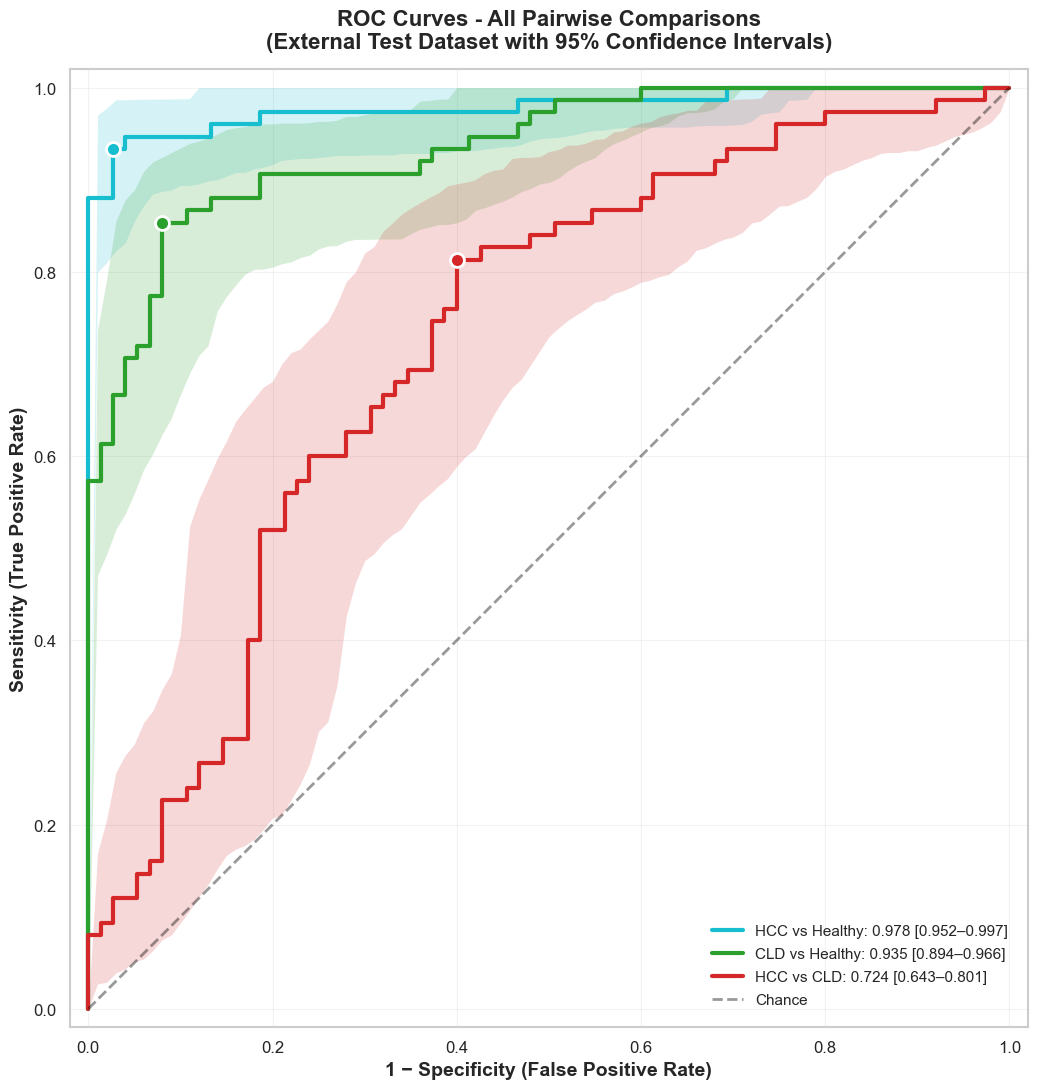

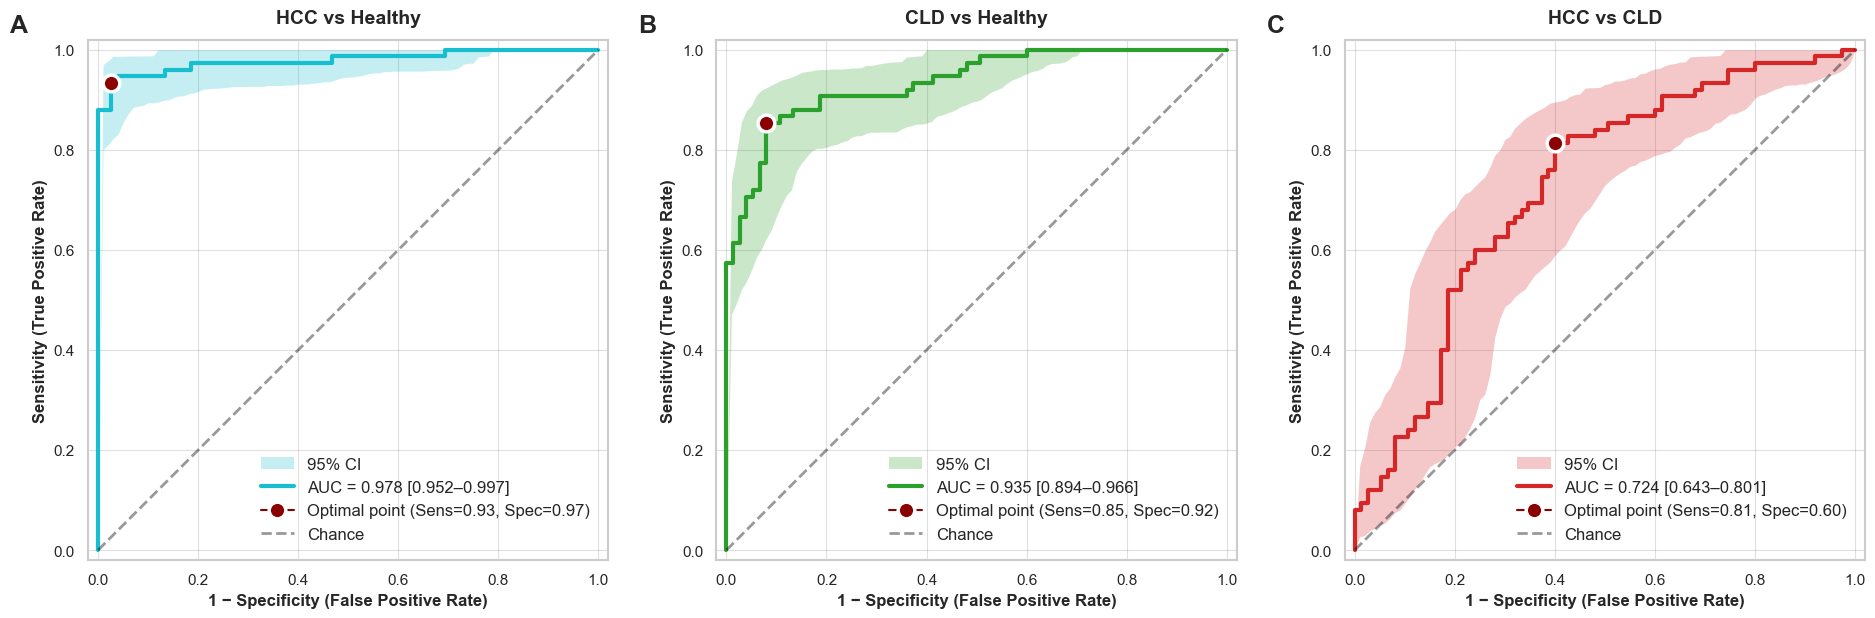

<Figure size 640x480 with 0 Axes>

In [ ]:
# ===================================================================================
# ROC Curves with Confidence Intervals (External Dataset)
# ===================================================================================


print("=" * 80)
print("GENERATING ROC CURVES WITH 95% CONFIDENCE INTERVALS")
print("External Test Dataset Only")
print("=" * 80)

# Create output directory
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Function to calculate ROC with bootstrap CI
def calculate_roc_with_ci(y_true, y_proba, n_bootstraps=1000, confidence_level=0.95, random_state=42):
    """
    Calculate ROC curve with confidence interval using bootstrap
    """
    np.random.seed(random_state)
    
    # Calculate main ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Find optimal threshold (Youden's index)
    youden_index = tpr - fpr
    optimal_idx = np.argmax(youden_index)
    optimal_threshold = thresholds[optimal_idx]
    optimal_fpr = fpr[optimal_idx]
    optimal_tpr = tpr[optimal_idx]
    
    # Bootstrap for confidence intervals
    tprs = []
    aucs = []
    base_fpr = np.linspace(0, 1, 101)
    
    n_samples = len(y_true)
    
    for i in range(n_bootstraps):
        # Bootstrap sample
        indices = resample(np.arange(n_samples), n_samples=n_samples, random_state=random_state+i)
        
        y_true_boot = y_true[indices]
        y_proba_boot = y_proba[indices]
        
        # Skip if only one class
        if len(np.unique(y_true_boot)) < 2:
            continue
        
        try:
            # Calculate ROC for bootstrap sample
            fpr_boot, tpr_boot, _ = roc_curve(y_true_boot, y_proba_boot)
            roc_auc_boot = auc(fpr_boot, tpr_boot)
            
            # Interpolate to common FPR values
            interp_func = interpolate.interp1d(fpr_boot, tpr_boot, kind='linear', 
                                              bounds_error=False, fill_value=(0, 1))
            tpr_interp = interp_func(base_fpr)
            tpr_interp[0] = 0.0
            tpr_interp[-1] = 1.0
            
            tprs.append(tpr_interp)
            aucs.append(roc_auc_boot)
        except:
            continue
    
    # Calculate CI
    tprs = np.array(tprs)
    mean_tpr = tprs.mean(axis=0)
    
    alpha = 1 - confidence_level
    lower_percentile = (alpha/2) * 100
    upper_percentile = (1 - alpha/2) * 100
    
    tpr_lower = np.percentile(tprs, lower_percentile, axis=0)
    tpr_upper = np.percentile(tprs, upper_percentile, axis=0)
    
    auc_lower = np.percentile(aucs, lower_percentile)
    auc_upper = np.percentile(aucs, upper_percentile)
    
    return {
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'roc_auc': roc_auc,
        'auc_lower': auc_lower,
        'auc_upper': auc_upper,
        'base_fpr': base_fpr,
        'mean_tpr': mean_tpr,
        'tpr_lower': tpr_lower,
        'tpr_upper': tpr_upper,
        'optimal_threshold': optimal_threshold,
        'optimal_fpr': optimal_fpr,
        'optimal_tpr': optimal_tpr,
        'optimal_sensitivity': optimal_tpr,
        'optimal_specificity': 1 - optimal_fpr,
        'n_bootstraps': len(aucs)
    }

# Function to plot single ROC curve WITH PROMINENT CI
# NOTE: Added 'for_panel' parameter to control font sizes
def plot_single_roc(ax, roc_data, class1, class2, color='steelblue',
                    label_prefix='', for_panel=False, legend_fs=None):
    # ...
    fs = 15 if for_panel else 20
    if legend_fs is not None:
        fs = legend_fs
    ax.legend(loc='lower right', fontsize=fs, framealpha=0.98, edgecolor='black',
              fancybox=False, shadow=False, borderpad=0.6 if for_panel else 0.8,
              labelspacing=0.5 if for_panel else 0.6)

    """
    Plot a single ROC curve with PROMINENT confidence intervals
    
    Parameters:
    -----------
    for_panel : bool
        If True, uses smaller fonts suitable for 3-panel figure
        If False, uses larger fonts for individual plots
    """
    # Plot confidence interval FIRST (more prominent)
    ax.fill_between(roc_data['base_fpr'], 
                     roc_data['tpr_lower'], 
                     roc_data['tpr_upper'],
                     color=color, alpha=0.25, linewidth=0,
                     label=f'95% CI')
    
    # Plot ROC curve (thick line)
    ax.plot(roc_data['fpr'], roc_data['tpr'], 
            color=color, lw=3,
            label=f"AUC = {roc_data['roc_auc']:.3f} [{roc_data['auc_lower']:.3f}–{roc_data['auc_upper']:.3f}]")
    
    # Plot optimal point (larger marker)
    ax.plot(roc_data['optimal_fpr'], roc_data['optimal_tpr'],
            marker='o', markersize=12, color='darkred',
            markeredgecolor='white', markeredgewidth=2.5,
            label=f"Optimal point (Sens={roc_data['optimal_sensitivity']:.2f}, Spec={roc_data['optimal_specificity']:.2f})",
            zorder=10)
    
    # Plot diagonal reference line
    ax.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.4, label='Chance')
    
    # Formatting
    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])
    ax.set_xlabel('1 − Specificity (False Positive Rate)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Sensitivity (True Positive Rate)', fontsize=12, fontweight='bold')
    ax.set_title(f'{class2} vs {class1}', fontsize=14, fontweight='bold', pad=12)
    
    # LEGEND WITH ADJUSTABLE FONT SIZE
    if for_panel:
        # Smaller font for 3-panel figure
        ax.legend(loc='lower right', fontsize=12, framealpha=0.98, edgecolor='black',
                 fancybox=False, shadow=False, borderpad=0.6, labelspacing=0.5)
    else:
        # Larger font for individual plots
        ax.legend(loc='lower right', fontsize=11, framealpha=0.98, edgecolor='black',
                 fancybox=False, shadow=False, borderpad=0.8, labelspacing=0.6)
    
    ax.grid(True, alpha=0.25, linestyle='-', linewidth=0.8, color='gray')
    ax.set_aspect('equal', adjustable='box')
    
    # Set tick parameters
    ax.tick_params(labelsize=11, width=1.5, length=6)
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
    
    
    return ax

# Function to get pairwise predictions from EXTERNAL dataset
def get_pairwise_predictions_external(X_ext, y_ext, class1, class2):
    """
    Get predictions for binary pairwise comparison on EXTERNAL dataset
    """
    # Convert to numpy if needed
    X_ext_arr = X_ext.values if hasattr(X_ext, 'values') else X_ext
    y_ext_arr = y_ext.values if hasattr(y_ext, 'values') else y_ext
    
    # Create binary subset for EXTERNAL data only
    mask = (y_ext_arr == class1) | (y_ext_arr == class2)
    X_bin = X_ext_arr[mask]
    y_bin = (y_ext_arr[mask] == class2).astype(int)
    
    if len(y_bin) < 5:
        return None, None
    
    # Train binary classifier on training data for this pair
    X_train_arr = X_train_scaled.values if hasattr(X_train_scaled, 'values') else X_train_scaled
    y_train_arr = y_train.values if hasattr(y_train, 'values') else y_train
    
    train_mask = (y_train_arr == class1) | (y_train_arr == class2)
    X_train_bin = X_train_arr[train_mask]
    y_train_bin = (y_train_arr[train_mask] == class2).astype(int)
    
    binary_clf = LogisticRegression(max_iter=1000, class_weight='balanced', 
                                    random_state=RANDOM_STATE)
    binary_clf.fit(X_train_bin, y_train_bin)
    
    # Get probabilities for EXTERNAL test set only
    y_proba = binary_clf.predict_proba(X_bin)[:, 1]
    
    return y_bin, y_proba

print("\n" + "=" * 80)
print("PLOTTING ROC CURVES (EXTERNAL TEST SET)")
print("=" * 80)

# Create figure with 3 subplots (one for each pairwise comparison)
fig, axes = plt.subplots(1, 3, figsize=(19, 6))
fig.patch.set_facecolor('white')

# Define colors for each comparison
colors = {
    ('Healthy', 'HCC'): '#17becf',      # Cyan/Teal - Panel A
    ('Healthy', 'CLD'): '#2ca02c',      # Green - Panel B
    ('CLD', 'HCC'): '#d62728'           # Red - Panel C
}

# Panel labels
panel_labels = ['A', 'B', 'C']

# Reorder class_pairs to match layout
ordered_pairs = [
    ('Healthy', 'HCC'),   # Panel A
    ('Healthy', 'CLD'),   # Panel B
    ('CLD', 'HCC')        # Panel C
]

roc_results = {}

for idx, (class1, class2) in enumerate(ordered_pairs):
    print(f"\n  [{idx+1}/3] Processing: {class2} vs {class1} (External Test Set)")
    
    ax = axes[idx]
    
    # Get predictions from EXTERNAL dataset only
    y_true, y_proba = get_pairwise_predictions_external(
        X_external_scaled, 
        y_external,
        class1, 
        class2
    )
    
    if y_true is not None:
        print(f"      Sample size: {len(y_true)} ({np.sum(y_true)} {class2}, {len(y_true)-np.sum(y_true)} {class1})")
        print(f"      Computing ROC with bootstrap (n=1000)...", end=" ")
        
        # Calculate ROC with CI
        roc_data = calculate_roc_with_ci(y_true, y_proba, n_bootstraps=1000)
        
        print("Done")
        
        # Store results
        comparison_key = f"{class2}_vs_{class1}"
        roc_results[comparison_key] = roc_data
        
        # Plot WITH for_panel=True for smaller legend font
        color = colors.get((class1, class2), 'steelblue')
        plot_single_roc(ax, roc_data, class1, class2, color=color, for_panel=True)  # ← KEY CHANGE
        
        # Add panel label
        ax.text(-0.15, 1.05, panel_labels[idx], 
                transform=ax.transAxes,
                fontsize=18, fontweight='bold', va='top',
                family='Arial')
        
        print(f"      ✓ AUC: {roc_data['roc_auc']:.4f} [{roc_data['auc_lower']:.4f}, {roc_data['auc_upper']:.4f}]")
        print(f"      ✓ Optimal: Sensitivity={roc_data['optimal_sensitivity']:.3f}, "
              f"Specificity={roc_data['optimal_specificity']:.3f}")
        print(f"      ✓ Bootstrap samples: {roc_data['n_bootstraps']}/1000")

plt.tight_layout()

print("\n✓ Generated 3-panel ROC figure")


# Create combined plot with all three ROC curves overlaid
print("\n" + "=" * 80)
print("CREATING COMBINED OVERLAY PLOT")
print("=" * 80)

fig_overlay = plt.figure(figsize=(11, 11))
fig_overlay.patch.set_facecolor('white')
ax_overlay = fig_overlay.add_subplot(111)

for idx, (class1, class2) in enumerate(ordered_pairs):
    comparison_key = f"{class2}_vs_{class1}"
    
    if comparison_key in roc_results:
        roc_data = roc_results[comparison_key]
        color = colors.get((class1, class2), 'steelblue')
        
        # Plot CI (more prominent)
        ax_overlay.fill_between(roc_data['base_fpr'], 
                               roc_data['tpr_lower'], 
                               roc_data['tpr_upper'],
                               color=color, alpha=0.18, linewidth=0)
        
        # Plot ROC curve
        ax_overlay.plot(roc_data['fpr'], roc_data['tpr'], 
                       color=color, lw=3,
                       label=f"{class2} vs {class1}: {roc_data['roc_auc']:.3f} [{roc_data['auc_lower']:.3f}–{roc_data['auc_upper']:.3f}]")
        
        # Plot optimal point
        ax_overlay.plot(roc_data['optimal_fpr'], roc_data['optimal_tpr'],
                       marker='o', markersize=10, color=color,
                       markeredgecolor='white', markeredgewidth=2,
                       zorder=10)

# Plot diagonal
ax_overlay.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.4, label='Chance')

# Formatting
ax_overlay.set_xlim([-0.02, 1.02])
ax_overlay.set_ylim([-0.02, 1.02])
ax_overlay.set_xlabel('1 − Specificity (False Positive Rate)', fontsize=14, fontweight='bold')
ax_overlay.set_ylabel('Sensitivity (True Positive Rate)', fontsize=14, fontweight='bold')
ax_overlay.set_title('ROC Curves - All Pairwise Comparisons\n(External Test Dataset with 95% Confidence Intervals)', 
                     fontsize=16, fontweight='bold', pad=15)

# Overlay plot legend with fontsize=11
ax_overlay.legend(loc='lower right', fontsize=11, framealpha=0.98, edgecolor='black',
                 borderpad=0.8, labelspacing=0.6)

ax_overlay.grid(True, alpha=0.25, linestyle='-', linewidth=0.8)
ax_overlay.set_aspect('equal', adjustable='box')
ax_overlay.tick_params(labelsize=12, width=1.5, length=6)

for spine in ax_overlay.spines.values():
    spine.set_linewidth(1.5)

plt.tight_layout()

print("✓ Created overlay plot")

# Save all plots
print("\n" + "=" * 80)
print("SAVING ROC PLOTS")
print("=" * 80)

roc_plots_dir = f'{output_dir}/roc_curves_external_{timestamp}'
os.makedirs(roc_plots_dir, exist_ok=True)

# Save combined 3-panel figure (multiple formats)
fig.savefig(f'{roc_plots_dir}/roc_curves_three_panel_external.png', dpi=600, bbox_inches='tight', facecolor='white')
fig.savefig(f'{roc_plots_dir}/roc_curves_three_panel_external.pdf', bbox_inches='tight', facecolor='white')
fig.savefig(f'{roc_plots_dir}/roc_curves_three_panel_external.svg', bbox_inches='tight', facecolor='white')
fig.savefig(f'{roc_plots_dir}/roc_curves_three_panel_external.tiff', dpi=600, bbox_inches='tight', facecolor='white')
print("✓ Saved 3-panel figure (PNG 600dpi, PDF, SVG, TIFF)")



# Save overlay plot
fig_overlay.savefig(f'{roc_plots_dir}/roc_curves_overlay_external.png', dpi=600, bbox_inches='tight', facecolor='white')
fig_overlay.savefig(f'{roc_plots_dir}/roc_curves_overlay_external.pdf', bbox_inches='tight', facecolor='white')
print("✓ Saved overlay plot (PNG 600dpi & PDF)")

# Save ROC data
roc_data_list = []
for comparison, data in roc_results.items():
    roc_data_list.append({
        'Comparison': comparison.replace('_', ' '),
        'AUC': data['roc_auc'],
        'AUC_Lower_95CI': data['auc_lower'],
        'AUC_Upper_95CI': data['auc_upper'],
        'CI_Width': data['auc_upper'] - data['auc_lower'],
        'Optimal_Threshold': data['optimal_threshold'],
        'Optimal_Sensitivity': data['optimal_sensitivity'],
        'Optimal_Specificity': data['optimal_specificity'],
        'N_Bootstrap_Samples': data['n_bootstraps']
    })

roc_summary_df = pd.DataFrame(roc_data_list)
roc_summary_df.to_csv(f'{roc_plots_dir}/roc_summary_external.csv', index=False)
print("✓ Saved ROC summary data")

# Save detailed ROC coordinates for each curve
for comparison, data in roc_results.items():
    detailed_data = pd.DataFrame({
        'FPR': data['fpr'],
        'TPR': data['tpr'],
        'Threshold': data['thresholds'],
        'TPR_Lower_95CI': np.interp(data['fpr'], data['base_fpr'], data['tpr_lower']),
        'TPR_Upper_95CI': np.interp(data['fpr'], data['base_fpr'], data['tpr_upper'])
    })
    detailed_data.to_csv(f'{roc_plots_dir}/roc_coordinates_{comparison}.csv', index=False)

print(f"\n✓ All plots saved to: {roc_plots_dir}/")

# Print summary table
print("\n" + "=" * 80)
print("ROC CURVE SUMMARY (EXTERNAL TEST SET)")
print("=" * 80)
print(f"\n{'Comparison':<20} {'AUC (95% CI)':<35} {'CI Width':<10} {'Sensitivity':<12} {'Specificity':<12}")
print("-" * 95)

for _, row in roc_summary_df.iterrows():
    comp = row['Comparison']
    auc_ci = f"{row['AUC']:.3f} ({row['AUC_Lower_95CI']:.3f}–{row['AUC_Upper_95CI']:.3f})"
    ci_width = f"{row['CI_Width']:.4f}"
    sens = f"{row['Optimal_Sensitivity']:.3f}"
    spec = f"{row['Optimal_Specificity']:.3f}"
    
    print(f"{comp:<20} {auc_ci:<35} {ci_width:<10} {sens:<12} {spec:<12}")

print("\n" + "=" * 80)
print("FORMATTED FOR MANUSCRIPT")
print("=" * 80)
print("\nPairwise Binary Classification Performance (External Test Set):\n")

for _, row in roc_summary_df.iterrows():
    comp = row['Comparison']
    auc = row['AUC']
    ci_lower = row['AUC_Lower_95CI']
    ci_upper = row['AUC_Upper_95CI']
    sens = row['Optimal_Sensitivity']
    spec = row['Optimal_Specificity']
    
    print(f"• {comp}:")
    print(f"  AUC: {auc:.3f} (95% CI: {ci_lower:.3f}–{ci_upper:.3f})")
    print(f"  Optimal operating point: Sensitivity = {sens:.3f}, Specificity = {spec:.3f}\n")

print("=" * 80)
print("✓ ROC CURVE ANALYSIS COMPLETE (EXTERNAL TEST SET)")
print("=" * 80)
print(f"\n📊 Generated files:")
print(f"  • 3-panel figure (PNG 600dpi, PDF, SVG, TIFF) - Legend fontsize: 9")
print(f"  • Overlay plot (PNG 600dpi, PDF) - Legend fontsize: 11")
print(f"  • Summary statistics (CSV)")
print(f"  • Detailed coordinates for {len(roc_results)} comparisons (CSV)")
print(f"\n💡 Key Features:")
print(f"  • 95% confidence intervals via bootstrap (n=1000)")
print(f"  • Optimal operating points via Youden's index")
print(f"  • External test set evaluation only")
print(f"  • Publication-ready quality (600 DPI)")
print(f"  • Adaptive legend sizing (smaller for panels, larger for individual)")
print("\n" + "=" * 80)

# Display figures
plt.figure(fig.number)
plt.show()


if 'individual_figs' in globals() and isinstance(individual_figs, dict):
    for fig_name, fig_obj in individual_figs.items():
        try:
            plt.figure(fig_obj.number)
            plt.show()
        except Exception:
            continue

plt.figure(fig_overlay.number)
plt.show()

#### <span style="color:#2ca02c;"> Feature importance results</span>

In [ ]:
# ==============================================================================
# Coefficient Analysis - Uniform Colors (Blue=Positive, Red=Negative)
# ==============================================================================


from pathlib import Path

warnings.filterwarnings('ignore')

print("=" * 80)
print("COEFFICIENT ANALYSIS: TOP 3 MODELS + ENSEMBLE")
print("=" * 80)
print("Analysis based on internal training data")
print("Includes: Top 3 models by External AUC + Ensemble meta-learner")
print("Color scheme: Blue = Positive coefficients, Red = Negative coefficients")
print("=" * 80)

# Create output directory
coef_output_dir = f'{output_dir}/top_models_coefficients_{timestamp}'
os.makedirs(coef_output_dir, exist_ok=True)

# Configuration
CLASS_MAPPING = {0: 'CLD', 1: 'HCC', 2: 'Healthy'}
PANEL_ORDER = ['Healthy', 'CLD', 'HCC']

# UNIFORM COLOR SCHEME
POSITIVE_COLOR = '#2E86AB'  # Blue for positive coefficients
NEGATIVE_COLOR = '#E63946'  # Red for negative coefficients

# Class colors only for titles/labels
CLASS_COLORS = {
    'Healthy': '#45b7d1',
    'CLD': '#2ca02c',
    'HCC': '#d62728'
}

# ============================================================================
# IMPORTANT: Verify we're using the correct top 3 models
# ============================================================================

print("\n" + "=" * 80)
print("VERIFYING TOP 3 MODELS BY EXTERNAL AUC")
print("=" * 80)

if 'top_3_models' not in globals():
    print("⚠ top_3_models not found - reconstructing from results_df")
    top_3_models = results_df.sort_values('ext_auc_ovr', ascending=False).head(3).copy()

print("\nTop 3 Models (by External AUC):")
for idx in range(len(top_3_models)):
    row = top_3_models.iloc[idx]
    model_key = f"{row['feature_selection']}_{row['classifier']}"
    print(f"\n  Rank {idx+1}: {model_key}")
    print(f"    External AUC: {row['ext_auc_ovr']:.4f}")
    print(f"    Validation AUC: {row['val_auc_ovr']:.4f}")
    print(f"    Features: {row['n_features']}")
    
    if model_key in trained_models:
        clf = trained_models[model_key]['classifier']
        has_coef = (hasattr(clf, 'coef_') or 
                   (hasattr(clf, 'estimator_') and hasattr(clf.estimator_, 'coef_')) or
                   (hasattr(clf, 'best_estimator_') and hasattr(clf.best_estimator_, 'coef_')))
        print(f"    Model found: ✓")
        print(f"    Has coefficients: {'✓ YES' if has_coef else '✗ NO (tree-based or SVM with RBF kernel)'}")
    else:
        print(f"    Model found: ✗ NOT FOUND")

# ============================================================================
# Helper Functions
# ============================================================================

def extract_model_coefficients(classifier, feature_names=None, model_name='Model'):
    """Extract coefficients from a trained classifier"""
    print(f"\n  Extracting coefficients for: {model_name}")
    
    coef = None
    classifier_obj = classifier
    
    if hasattr(classifier, 'coef_'):
        coef = classifier.coef_
        classifier_obj = classifier
    elif hasattr(classifier, 'best_estimator_') and hasattr(classifier.best_estimator_, 'coef_'):
        coef = classifier.best_estimator_.coef_
        classifier_obj = classifier.best_estimator_
    elif hasattr(classifier, 'estimator_') and hasattr(classifier.estimator_, 'coef_'):
        coef = classifier.estimator_.coef_
        classifier_obj = classifier.estimator_
    elif hasattr(classifier, 'calibrated_classifiers_'):
        if len(classifier.calibrated_classifiers_) > 0:
            base_clf = classifier.calibrated_classifiers_[0].estimator
            if hasattr(base_clf, 'coef_'):
                coef = base_clf.coef_
                classifier_obj = base_clf
    
    if coef is None:
        print(f"    ✗ No coefficients available")
        print(f"    Model type: {type(classifier).__name__}")
        if hasattr(classifier, 'kernel'):
            print(f"    SVM kernel: {classifier.kernel}")
        return None
    
    if np.isnan(coef).any() or np.isinf(coef).any():
        print(f"    ✗ Contains NaN or Inf values")
        return None
    
    print(f"    ✓ Coefficient shape: {coef.shape}")
    
    classes = getattr(classifier_obj, 'classes_', None)
    if classes is None:
        print(f"    ✗ No classes_ attribute found")
        return None
    
    class_names = []
    for c in classes:
        if isinstance(c, str):
            class_names.append(c)
        elif isinstance(c, (int, np.integer)):
            class_names.append(CLASS_MAPPING.get(c, f'Class_{c}'))
        else:
            class_names.append(str(c))
    
    print(f"    ✓ Classes: {class_names}")
    
    if feature_names is None:
        n_features = coef.shape[1]
        feature_names = [f'Feature_{i}' for i in range(n_features)]
        print(f"    Generated {n_features} feature names")
    else:
        if coef.shape[1] != len(feature_names):
            if coef.shape[1] < len(feature_names):
                feature_names = feature_names[:coef.shape[1]]
                print(f"    Truncated feature names to {len(feature_names)}")
            else:
                print(f"    ✗ Shape mismatch: {coef.shape[1]} coef vs {len(feature_names)} features")
                return None
    
    print(f"    ✓ Features: {len(feature_names)}")
    if len(feature_names) > 0:
        print(f"    Sample: {feature_names[:min(3, len(feature_names))]}")
    
    if len(classes) == 2:
        coef_array = np.zeros((2, coef.shape[1]))
        coef_array[0, :] = -coef[0, :]
        coef_array[1, :] = coef[0, :]
        print(f"    Binary classification - coefficients duplicated")
    else:
        coef_array = coef
    
    coef_df = pd.DataFrame(
        coef_array.T,
        index=feature_names,
        columns=class_names
    )
    
    if coef_df.isna().any().any():
        print(f"    ✗ Contains NaN values")
        return None
    
    print(f"    ✓ Successfully extracted coefficients")
    print(f"    Range: [{coef_df.min().min():.4f}, {coef_df.max().max():.4f}]")
    
    return coef_df

def plot_coefficient_heatmap(coef_df, title, top_n=15, figsize=(12, 10)):
    """Create annotated heatmap of top coefficients"""
    
    total_abs_coef = coef_df.abs().sum(axis=1)
    top_features = total_abs_coef.nlargest(min(top_n, len(total_abs_coef))).index
    
    available_classes = [c for c in PANEL_ORDER if c in coef_df.columns]
    plot_df = coef_df.loc[top_features, available_classes].copy()
    
    fig_height = max(figsize[1], len(top_features) * 0.5)
    fig, ax = plt.subplots(figsize=(figsize[0], fig_height))
    fig.patch.set_facecolor('white')
    
    vmax = plot_df.abs().max().max()
    if vmax == 0 or np.isnan(vmax):
        vmax = 1.0
    
    sns.heatmap(
        plot_df,
        annot=True,
        fmt='.3f',
        cmap='RdBu_r',
        center=0,
        cbar_kws={'label': 'Coefficient Value', 'shrink': 0.8},
        linewidths=1.0,
        linecolor='white',
        ax=ax,
        vmin=-vmax,
        vmax=vmax,
        annot_kws={'fontsize': 10, 'weight': 'bold'}
    )
    
    ax.set_xlabel('Class', fontsize=14, fontweight='bold', labelpad=10)
    ax.set_ylabel('Feature', fontsize=14, fontweight='bold', labelpad=10)
    ax.set_title(f'{title}\nTop {len(top_features)} Features by Total Absolute Coefficient',
                fontsize=15, fontweight='bold', pad=20)
    
    plt.xticks(rotation=0, fontsize=13)
    plt.yticks(rotation=0, fontsize=12)
    
    ax.text(0.5, -0.15, 
           f'Coefficient range: [{plot_df.min().min():.4f}, {plot_df.max().max():.4f}]',
           ha='center', transform=ax.transAxes, fontsize=10, style='italic')
    
    plt.tight_layout()
    
    return fig

def plot_separate_class_bars(coef_df, title, top_n=10, model_dir=None):
    """
    Create SEPARATE bar plots for EACH class with UNIFORM COLORS
    Blue = Positive coefficients
    Red = Negative coefficients
    
    Parameters:
    -----------
    coef_df : DataFrame
        Coefficient dataframe with features as index and classes as columns
    title : str
        Main title for the plots
    top_n : int
        Number of top features to show per class
    model_dir : str
        Directory to save individual class plots
        
    Returns:
    --------
    None (saves individual plots)
    """
    
    for class_name in PANEL_ORDER:
        if class_name not in coef_df.columns:
            continue
        
        # Create individual figure for this class
        fig, ax = plt.subplots(figsize=(12, 10))
        fig.patch.set_facecolor('white')
        
        # Get coefficients for this class
        class_coef = coef_df[class_name].sort_values(ascending=False)
        
        # Get top positive and negative
        n_to_show = min(top_n, len(class_coef))
        top_positive = class_coef.head(n_to_show)
        top_negative = class_coef.tail(n_to_show).sort_values(ascending=True)
        
        # Combine (avoid duplicates)
        combined = pd.concat([top_negative, top_positive])
        combined = combined[~combined.index.duplicated(keep='first')]
        
        features = combined.index.values
        values = combined.values
        
        # UNIFORM COLORS: Blue for positive, Red for negative
        colors_list = [POSITIVE_COLOR if v > 0 else NEGATIVE_COLOR for v in values]
        
        # Plot horizontal bars
        y_pos = np.arange(len(features))
        bars = ax.barh(y_pos, values, color=colors_list, alpha=0.85, 
                      edgecolor='black', linewidth=1.2)
        
        # Add value labels
        max_abs = np.abs(values).max()
        if max_abs > 0:
            pad = 0.04 * max_abs
            for i, (bar, val) in enumerate(zip(bars, values)):
                x_pos = val + (pad if val > 0 else -pad)
                ha = 'left' if val > 0 else 'right'
                ax.text(x_pos, i, f'{val:.3f}', va='center', ha=ha, 
                       fontsize=16, fontweight='bold')
        
        # Zero reference line
        ax.axvline(x=0, color='black', linestyle='-', linewidth=2, alpha=0.6)
        
        # Add padding to x-axis limits
        x_range = max_abs * 0.15  # 15% padding
        ax.set_xlim(values.min() - x_range, values.max() + x_range)
        
        # Formatting
        ax.set_yticks(y_pos)
        ax.set_yticklabels(features, fontsize=16)
        ax.set_xlabel('Coefficient Value', fontsize=18, fontweight='bold', labelpad=12)
        
        
        
        # Enhanced grid
        ax.grid(axis='x', alpha=0.4, linestyle='--', linewidth=1.0, color='gray')
        ax.set_axisbelow(True)
        
        # Tick formatting
        ax.tick_params(axis='x', labelsize=18, length=6, width=1.5)
        ax.tick_params(axis='y', labelsize=20, length=0)
        
        # Spine formatting
        for spine in ax.spines.values():
            spine.set_linewidth(1.5)
        
        # Add legend for color interpretation
        from matplotlib.patches import Rectangle
        legend_elements = [
            Rectangle((0, 0), 1, 1, facecolor=POSITIVE_COLOR, edgecolor='black', 
                     linewidth=1, label='Positive coefficient'),
            Rectangle((0, 0), 1, 1, facecolor=NEGATIVE_COLOR, edgecolor='black', 
                     linewidth=1, label='Negative coefficient')
        ]
        ax.legend(handles=legend_elements, loc='lower right', fontsize=20, 
                 frameon=True, fancybox=True, shadow=True)
        
    
        plt.tight_layout()
        
        # Save individual class plot
        if model_dir:
            class_filename = class_name.lower().replace(' ', '_')
            fig.savefig(f'{model_dir}/coefficients_{class_filename}.png',
                       dpi=600, bbox_inches='tight', facecolor='white', pad_inches=0.3)
            fig.savefig(f'{model_dir}/coefficients_{class_filename}.pdf',
                       bbox_inches='tight', facecolor='white')
            fig.savefig(f'{model_dir}/coefficients_{class_filename}.svg',
                       bbox_inches='tight', facecolor='white')
        
        plt.close(fig)

def create_coefficient_table(coef_df, top_n=20):
    """Create formatted coefficient table"""
    
    coef_with_total = coef_df.copy()
    coef_with_total['Total_Abs'] = coef_with_total.abs().sum(axis=1)
    
    coef_sorted = coef_with_total.sort_values('Total_Abs', ascending=False)
    
    top_coef = coef_sorted.head(top_n).copy()
    
    for col in top_coef.columns:
        top_coef[col] = top_coef[col].round(4)
    
    return top_coef

# ============================================================================
# Process Top 3 Individual Models
# ============================================================================

print("\n" + "=" * 80)
print("PART 1: TOP 3 INDIVIDUAL MODELS (ALREADY TRAINED)")
print("=" * 80)

top_3_info = []
models_with_coefficients = 0

for idx in range(len(top_3_models)):
    row = top_3_models.iloc[idx]
    model_key = f"{row['feature_selection']}_{row['classifier']}"
    
    print(f"\n{'='*80}")
    print(f"MODEL {idx + 1}/{len(top_3_models)}: {model_key}")
    print(f"{'='*80}")
    print(f"External AUC: {row['ext_auc_ovr']:.4f}")
    print(f"Validation AUC: {row['val_auc_ovr']:.4f}")
    print(f"Features: {row['n_features']}")
    
    if model_key not in trained_models:
        print(f"  ✗ Model not found in trained_models")
        continue
    
    model_data = trained_models[model_key]
    classifier = model_data['classifier']
    selected_features = model_data.get('selected_features', None)
    
    print(f"  Classifier type: {type(classifier).__name__}")
    
    coef_df = extract_model_coefficients(
        classifier, 
        feature_names=selected_features,
        model_name=model_key
    )
    
    if coef_df is None:
        print(f"  ⚠ Skipping - no coefficients available")
        print(f"  Note: This model is likely tree-based (Random Forest, XGBoost) or SVM with non-linear kernel")
        continue
    
    models_with_coefficients += 1
    
    fs_short = row['feature_selection'].replace('1_', '').replace('2_', '').replace('3_', '').replace('4_', '').replace('5_', '').replace('6_', '')
    clf_short = row['classifier'].replace('1_', '').replace('2_', '').replace('3_', '').replace('4_', '').replace('5_', '').replace('6_', '').replace('7_', '').replace('8_', '')
    
    top_3_info.append({
        'rank': idx + 1,
        'model_key': model_key,
        'fs_name': fs_short,
        'clf_name': clf_short,
        'ext_auc': row['ext_auc_ovr'],
        'val_auc': row['val_auc_ovr'],
        'n_features': row['n_features'],
        'coef_df': coef_df
    })
    
    model_dir = f'{coef_output_dir}/rank{idx+1}_{fs_short}_{clf_short}'
    os.makedirs(model_dir, exist_ok=True)
    
    print(f"\n  Generating visualizations:")
    
    # 1. Heatmap
    print(f"    • Heatmap...", end=" ")
    try:
        fig_heat = plot_coefficient_heatmap(
            coef_df, 
            f'Rank {idx+1}: {fs_short} + {clf_short}\n(External AUC: {row["ext_auc_ovr"]:.4f})',
            top_n=min(15, len(coef_df))
        )
        fig_heat.savefig(f'{model_dir}/coefficients_heatmap.png',
                        dpi=600, bbox_inches='tight', facecolor='white', pad_inches=0.2)
        fig_heat.savefig(f'{model_dir}/coefficients_heatmap.pdf',
                        bbox_inches='tight', facecolor='white')
        plt.close(fig_heat)
        print("✓")
    except Exception as e:
        print(f"Error: {e}")
    
    # 2. Separate class plots
    print(f"    • Separate class plots (Blue=Positive, Red=Negative)...", end=" ")
    try:
        plot_separate_class_bars(
            coef_df,
            f'Rank {idx+1}: {fs_short} + {clf_short} (External AUC: {row["ext_auc_ovr"]:.4f})',
            top_n=min(10, len(coef_df)),
            model_dir=model_dir
        )
        print("✓")
    except Exception as e:
        print(f"Error: {e}")
    
    # 3. Coefficient table
    print(f"    • Coefficient table...", end=" ")
    try:
        coef_table = create_coefficient_table(coef_df, top_n=20)
        coef_table.to_csv(f'{model_dir}/coefficients_table.csv')
        
        styled_table = coef_table.style.format(precision=4).background_gradient(
            cmap='RdBu_r', axis=None, subset=[c for c in coef_table.columns if c != 'Total_Abs']
        )
        styled_table.to_html(f'{model_dir}/coefficients_table.html')
        
        print("✓")
    except Exception as e:
        print(f"Error: {e}")
    
    print(f"  ✓ Saved to: {model_dir}/")

print(f"\n{'='*80}")
print(f"SUMMARY: Found {models_with_coefficients} models with coefficients out of {len(top_3_models)}")
if models_with_coefficients == 0:
    print("⚠ WARNING: No models with coefficients found!")
    print("  This means all top 3 models are tree-based or non-linear")
    print("  Only Logistic Regression and Linear SVM have interpretable linear coefficients")
print(f"{'='*80}")

# ============================================================================
# Process Ensemble Meta-Learner
# ============================================================================

print("\n" + "=" * 80)
print("PART 2: ENSEMBLE META-LEARNER")
print("=" * 80)

if 'stacking_clf' in globals() and stacking_clf is not None:
    print("\nExtracting meta-learner coefficients...")
    print(f"Meta-learner type: {type(stacking_clf.final_estimator_).__name__}")
    
    meta_learner = stacking_clf.final_estimator_
    
    meta_feature_names = []
    for base_name, _ in top_3_estimators:
        for class_name in PANEL_ORDER:
            meta_feature_names.append(f"{base_name}_{class_name}")
    
    print(f"Meta-learner input features: {len(meta_feature_names)}")
    
    meta_coef_df = extract_model_coefficients(
        meta_learner,
        feature_names=meta_feature_names,
        model_name='Ensemble Meta-Learner'
    )
    
    if meta_coef_df is not None:
        ensemble_dir = f'{coef_output_dir}/ensemble_meta_learner'
        os.makedirs(ensemble_dir, exist_ok=True)
        
        print(f"\n  Generating visualizations:")
        
        # 1. Heatmap
        print(f"    • Heatmap...", end=" ")
        try:
            fig_heat = plot_coefficient_heatmap(
                meta_coef_df,
                f'Ensemble Meta-Learner Coefficients\n(External AUC: {ext_auc_ovr_ensemble:.4f})',
                top_n=min(15, len(meta_coef_df)),
                figsize=(14, 10)
            )
            fig_heat.savefig(f'{ensemble_dir}/meta_learner_heatmap.png',
                            dpi=600, bbox_inches='tight', facecolor='white', pad_inches=0.2)
            fig_heat.savefig(f'{ensemble_dir}/meta_learner_heatmap.pdf',
                            bbox_inches='tight', facecolor='white')
            plt.close(fig_heat)
            print("✓")
        except Exception as e:
            print(f"Error: {e}")
        
        # 2. Separate class plots
        print(f"    • Separate class plots (Blue=Positive, Red=Negative)...", end=" ")
        try:
            plot_separate_class_bars(
                meta_coef_df,
                f'Ensemble Meta-Learner (External AUC: {ext_auc_ovr_ensemble:.4f})',
                top_n=min(9, len(meta_coef_df)),  # All 9 meta-features
                model_dir=ensemble_dir
            )
            print("✓")
        except Exception as e:
            print(f"Error: {e}")
        
        # 3. Coefficient table
        print(f"    • Coefficient table...", end=" ")
        try:
            meta_coef_table = create_coefficient_table(meta_coef_df, top_n=len(meta_coef_df))
            meta_coef_table.to_csv(f'{ensemble_dir}/meta_learner_coefficients.csv')
            
            styled_table = meta_coef_table.style.format(precision=4).background_gradient(
                cmap='RdBu_r', axis=None, subset=[c for c in meta_coef_table.columns if c != 'Total_Abs']
            )
            styled_table.to_html(f'{ensemble_dir}/meta_learner_coefficients.html')
            print("✓")
        except Exception as e:
            print(f"Error: {e}")
        
        print(f"  ✓ Saved to: {ensemble_dir}/")
        
        # Create interpretation guide
        print(f"\n  Creating interpretation guide...", end=" ")
        try:
            interpretation_md = f"""# Ensemble Meta-Learner Coefficient Interpretation

## Overview
- **Meta-Learner Type**: Logistic Regression (L2 regularized)
- **Input Features**: Class probability predictions from {len(top_3_estimators)} base models
- **Number of Features**: {len(meta_feature_names)} ({len(top_3_estimators)} models × {len(PANEL_ORDER)} classes)
- **External Test AUC**: {ext_auc_ovr_ensemble:.4f}

## Color Scheme
- 🔵 **Blue bars**: Positive coefficients (increase prediction probability)
- 🔴 **Red bars**: Negative coefficients (decrease prediction probability)

## Base Models Used
"""
            for idx, (base_name, _) in enumerate(top_3_estimators):
                model_info = top_3_info[idx] if idx < len(top_3_info) else None
                if model_info:
                    interpretation_md += f"{idx+1}. **{base_name}** (External AUC: {model_info['ext_auc']:.4f})\n"
                else:
                    interpretation_md += f"{idx+1}. **{base_name}**\n"
            
            interpretation_md += f"""
## Coefficient Interpretation

### Positive Coefficients (🔵 Blue)
- **Meaning**: Higher base model probability for this class → Higher ensemble probability for target class

### Negative Coefficients (🔴 Red)
- **Meaning**: Higher base model probability for this class → Lower ensemble probability for target class

### Magnitude
- **Large |coefficient|**: Base model's prediction is strongly weighted by meta-learner
- **Small |coefficient|**: Base model's prediction is weakly weighted or ignored

## Top Features by Class

"""
            for class_name in PANEL_ORDER:
                if class_name in meta_coef_df.columns:
                    top_5 = meta_coef_df[class_name].abs().nlargest(5)
                    interpretation_md += f"### Predicting {class_name}\n"
                    interpretation_md += "| Feature | Coefficient | Color | Interpretation |\n"
                    interpretation_md += "|---------|-------------|-------|----------------|\n"
                    for feat in top_5.index:
                        coef_val = meta_coef_df.loc[feat, class_name]
                        direction = "increases" if coef_val > 0 else "decreases"
                        color = "🔵 Blue" if coef_val > 0 else "🔴 Red"
                        interpretation_md += f"| `{feat}` | {coef_val:.4f} | {color} | {direction} prediction |\n"
                    interpretation_md += "\n"
            
            with open(f'{ensemble_dir}/interpretation_guide.md', 'w') as f:
                f.write(interpretation_md)
            
            print("✓")
        except Exception as e:
            print(f"Error: {e}")
    
    else:
        print("  ⚠ Could not extract meta-learner coefficients")
else:
    print("  ⚠ Ensemble model not found - skipping meta-learner analysis")

# ============================================================================
# Create Comparison Summary
# ============================================================================

print("\n" + "=" * 80)
print("PART 3: COMPARISON SUMMARY")
print("=" * 80)

if len(top_3_info) > 0:
    print(f"\n  Found {len(top_3_info)} models with coefficients to compare")
    print("\n  Creating comparison visualizations...")
    
    # Summary table
    print(f"    • Summary table...", end=" ")
    try:
        summary_data = []
        
        for model_info in top_3_info:
            coef_df = model_info['coef_df']
            
            for class_name in PANEL_ORDER:
                if class_name in coef_df.columns:
                    top_feat = coef_df[class_name].abs().idxmax()
                    top_val = coef_df.loc[top_feat, class_name]
                    avg_abs = coef_df[class_name].abs().mean()
                    
                    summary_data.append({
                        'Rank': model_info['rank'],
                        'Model': f"{model_info['fs_name']} + {model_info['clf_name']}",
                        'External_AUC': model_info['ext_auc'],
                        'Class': class_name,
                        'Top_Feature': top_feat,
                        'Top_Coefficient': top_val,
                        'Avg_Abs_Coefficient': avg_abs
                    })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df = summary_df.sort_values(['Rank', 'Class'])
        
        summary_df.to_csv(f'{coef_output_dir}/top3_coefficient_summary.csv', index=False)
        
        styled = summary_df.style.format({
            'External_AUC': '{:.4f}',
            'Top_Coefficient': '{:.4f}',
            'Avg_Abs_Coefficient': '{:.4f}'
        }).background_gradient(subset=['External_AUC'], cmap='Greens')
        
        styled.to_html(f'{coef_output_dir}/top3_coefficient_summary.html')
        
        print("✓")
        print("\n")
        display(summary_df)
        
    except Exception as e:
        print(f"Error: {e}")
else:
    print("\n  ⚠ No models with coefficients found - skipping comparisons")

# ============================================================================
# Display Example
# ============================================================================

print("\n" + "=" * 80)
print("EXAMPLE VISUALIZATIONS")
print("=" * 80)

if len(top_3_info) > 0:
    print(f"\nRank 1 Model: {top_3_info[0]['fs_name']} + {top_3_info[0]['clf_name']}")
    print(f"External AUC: {top_3_info[0]['ext_auc']:.4f}")
    
    coef_df = top_3_info[0]['coef_df']
    
    print("\nTop 10 Features by Total Absolute Coefficient:")
    coef_with_total = coef_df.copy()
    coef_with_total['Total_Abs'] = coef_with_total.abs().sum(axis=1)
    display(coef_with_total.nlargest(10, 'Total_Abs'))
    
    fig1 = plot_coefficient_heatmap(
        coef_df,
        f'Rank 1: {top_3_info[0]["fs_name"]} + {top_3_info[0]["clf_name"]}\n(External AUC: {top_3_info[0]["ext_auc"]:.4f})',
        top_n=15
    )
    plt.show()
else:
    print("\n  ⚠ No models with coefficients available to display")

# Final summary
print("\n" + "=" * 80)
print("✓ COEFFICIENT ANALYSIS COMPLETE")
print("=" * 80)
print(f"\n📁 All files saved to: {coef_output_dir}/")
print(f"\n🎨 Color scheme: 🔵 Blue = Positive coefficients | 🔴 Red = Negative coefficients")
print(f"\n📊 Generated for {len(top_3_info)} individual models (with coefficients) + ensemble meta-learner")
if len(top_3_info) > 0:
    print(f"\n📈 Files per model:")
    print(f"  • Heatmap (PNG 600dpi, PDF)")
    print(f"  • SEPARATE plots for each class with uniform colors (PNG 600dpi, PDF, SVG)")
    print(f"  • Coefficient tables (CSV, HTML)")
    print(f"\n📋 Summary files:")
    print(f"  • Summary table with top features per class")
if 'meta_coef_df' in locals() and meta_coef_df is not None:
    print(f"  • Ensemble meta-learner interpretation guide")
else:
    print(f"\n⚠ Note: Some/all top models don't have linear coefficients (tree-based/non-linear models)")
print("=" * 80)

COEFFICIENT ANALYSIS: TOP 3 MODELS + ENSEMBLE
Analysis based on internal training data
Includes: Top 3 models by External AUC + Ensemble meta-learner
Color scheme: Blue = Positive coefficients, Red = Negative coefficients

VERIFYING TOP 3 MODELS BY EXTERNAL AUC

Top 3 Models (by External AUC):

  Rank 1: 6_Tree_Based_Wrapper_7_LightGBM
    External AUC: 0.8687
    Validation AUC: 0.9673
    Features: 23
    Model found: ✓
    Has coefficients: ✗ NO (tree-based or SVM with RBF kernel)

  Rank 2: 1_All_Features_7_LightGBM
    External AUC: 0.8658
    Validation AUC: 0.9715
    Features: 74
    Model found: ✓
    Has coefficients: ✗ NO (tree-based or SVM with RBF kernel)

  Rank 3: 6_Tree_Based_Wrapper_5_Naive_Bayes
    External AUC: 0.8649
    Validation AUC: 0.9006
    Features: 23
    Model found: ✓
    Has coefficients: ✗ NO (tree-based or SVM with RBF kernel)

PART 1: TOP 3 INDIVIDUAL MODELS (ALREADY TRAINED)

MODEL 1/3: 6_Tree_Based_Wrapper_7_LightGBM
External AUC: 0.8687
Validation

## <span style="color:#F60404;">Unsupervised analysis</span>
</span>

#### <span style="color:#2ca02c;"> UNSUPERVISED CLUSTERING ANALYSIS</span>

🔬 UNSUPERVISED CLUSTERING ANALYSIS - K-MEANS WITH PCA & t-SNE
   scikit-learn version: 1.7.2

📂 Loading data splits...
   Loading from data_splits/splits.pkl
   ✅ Loaded and combined: (475, 360)

📊 Standardizing features...
   ✅ Scaled data: mean=0.000, std=1.000

📊 Data Summary:
   Source: saved splits
   Samples: 475
   Features: 360
   Classes: 3

   Class Distribution:
      CLD: 186 (39.2%)
      HCC: 139 (29.3%)
      Healthy: 150 (31.6%)

📈 Performing PCA...
   Components for 90% variance: 8
   Components for 95% variance: 13
   First 3 PCs explain: 67.5% variance

📈 Performing t-SNE...
   ✅ t-SNE completed with perplexity=30.0

🎯 Performing K-means clustering...
   K-means on original features...
   K-means on PCA features...
   K-means on 2D PCA...

📊 Evaluating clustering performance...

K-MEANS CLUSTERING METRICS:
  Method  Silhouette  Calinski-Harabasz  Davies-Bouldin   ARI   NMI  V-Measure
Original       0.393            180.674           1.318 0.498 0.584      0.584
     

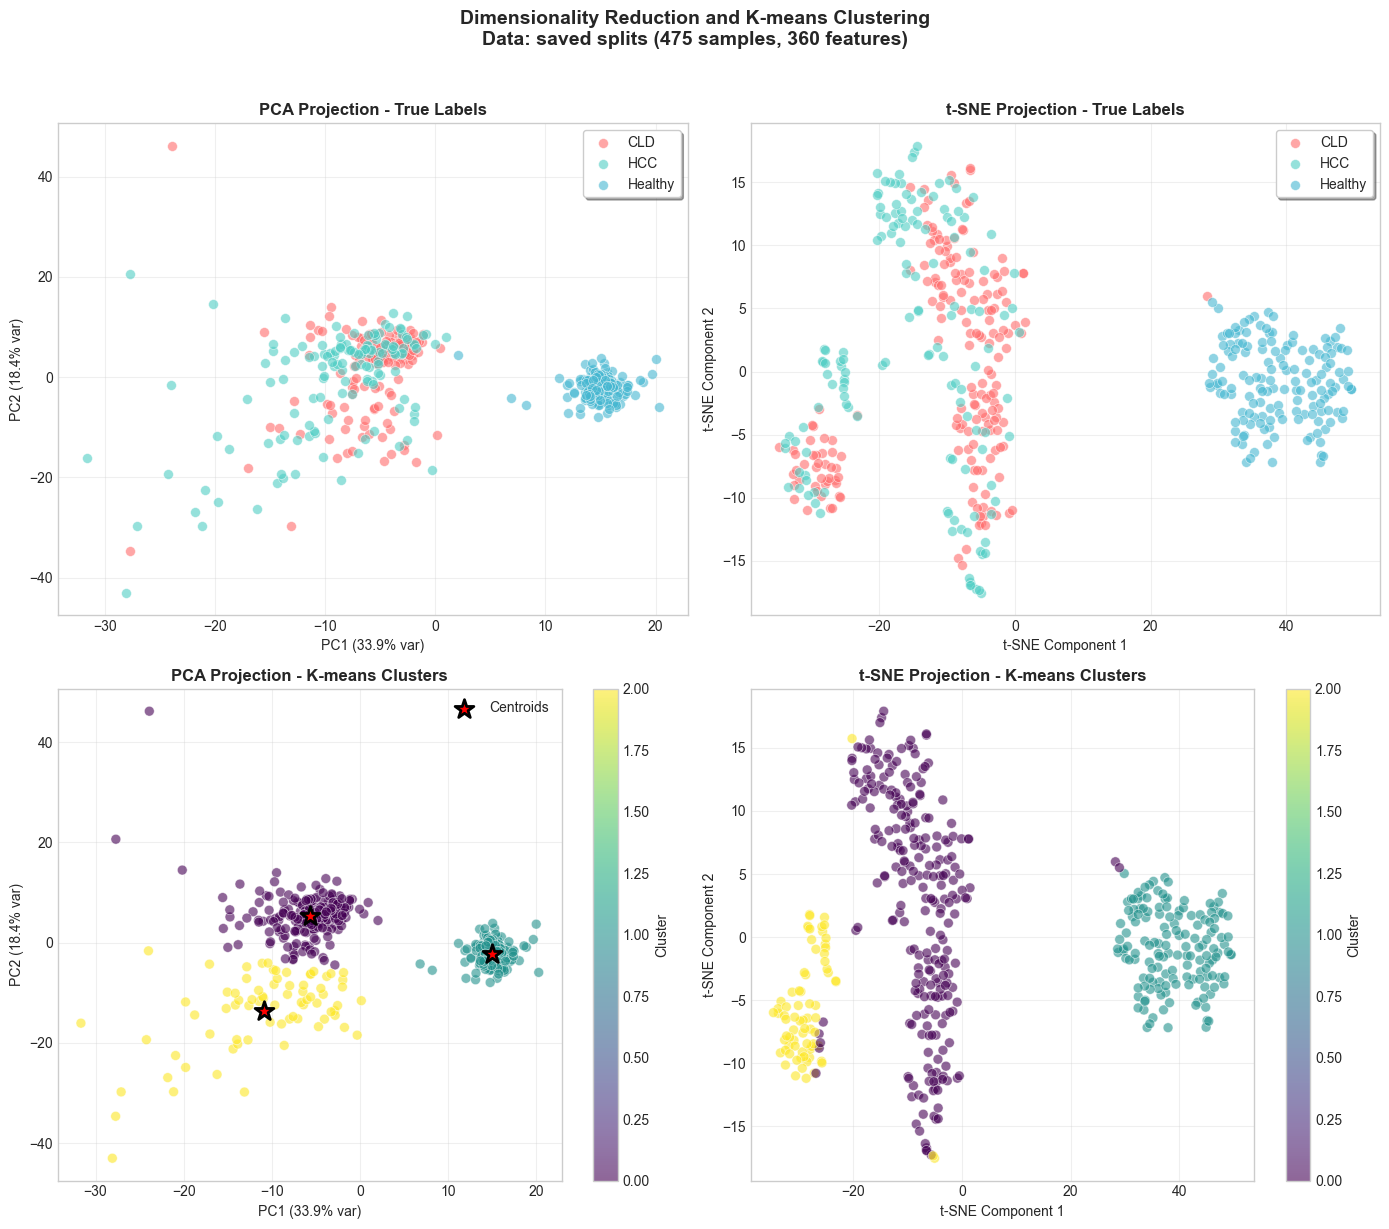

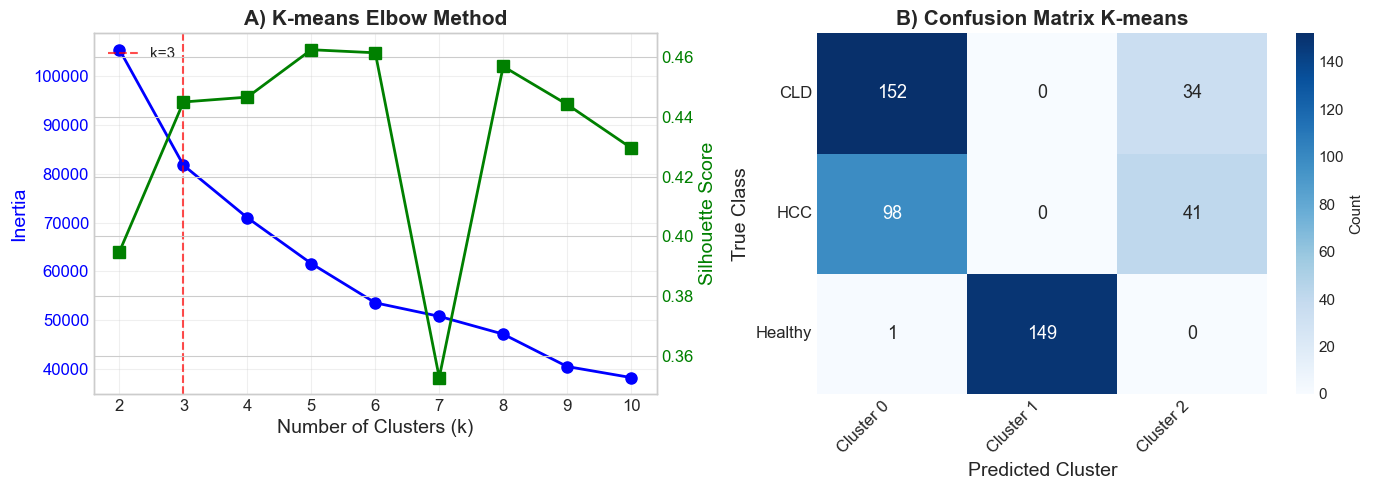

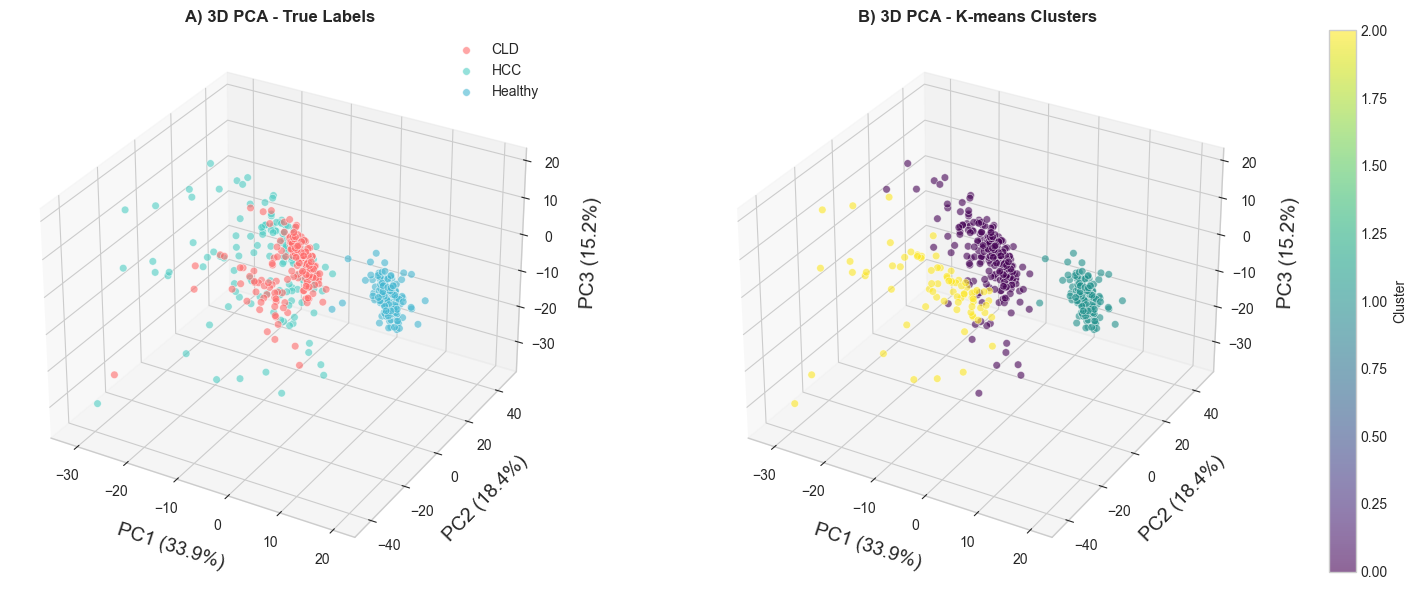


📊 Cluster Characterization...

🎯 Best Method: PCA-2D (ARI = 0.509)

Cluster Composition:

  Cluster 0 (251 samples, 52.8%):
    CLD: 152 (60.6%)
    HCC: 98 (39.0%)
    Healthy: 1 (0.4%)

  Cluster 1 (149 samples, 31.4%):
    CLD: 0 (0.0%)
    HCC: 0 (0.0%)
    Healthy: 149 (100.0%)

  Cluster 2 (75 samples, 15.8%):
    CLD: 34 (45.3%)
    HCC: 41 (54.7%)
    Healthy: 0 (0.0%)

💾 Saving clustering results...
   ✅ Results saved to plots_ultimate/clustering

📊 CLUSTERING ANALYSIS SUMMARY

📂 Data Source: saved splits
   Shape: (475, 360)

🎯 K-means Performance:

   Original:
      ARI: 0.498
      Silhouette: 0.393
      NMI: 0.584

   PCA:
      ARI: 0.504
      Silhouette: 0.445
      NMI: 0.589

   PCA-2D:
      ARI: 0.509
      Silhouette: 0.696
      NMI: 0.591

📈 Dimensionality Reduction:
   Original: 360 features
   PCA for 90% variance: 8 components
   PCA for 95% variance: 13 components
   Reduction: 96.4%

🔍 Best Clustering Method: PCA-2D
   ARI Score: 0.509
   Silhouette Score

In [ ]:
# =============================================================================
# UNSUPERVISED CLUSTERING ANALYSIS
# Focus on K-means, PCA, and t-SNE for visualization
# =============================================================================

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    adjusted_rand_score, normalized_mutual_info_score, v_measure_score
)
import pickle


# Style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("="*100)
print("🔬 UNSUPERVISED CLUSTERING ANALYSIS - K-MEANS WITH PCA & t-SNE")
print(f"   scikit-learn version: {sklearn.__version__}")
print("="*100)

# =============================================================================
# CONFIGURATION
# =============================================================================
results_dir = Path("./results_ultimate")
plot_dir = Path("./plots_ultimate")
clustering_dir = plot_dir / "clustering"
clustering_dir.mkdir(exist_ok=True, parents=True)

data_splits_dir = Path("./data_splits")

N_CLUSTERS = 3
RANDOM_STATE = 42
N_COMPONENTS_PCA = 30     # target for dimensionality steps
PERPLEXITY_TSNE = 30

# Choose a KMeans n_init that works across versions
_KMEANS_N_INIT = "auto" if tuple(map(int, sklearn.__version__.split(".")[:2])) >= (1, 4) else 10

# =============================================================================
# LOAD DATA
# =============================================================================
print("\n📂 Loading data splits...")

X_internal = None
y_internal = None
feature_names = None
data_source = None

# Method 1
if 'split_results' in globals():
    print("   ✅ Found split_results")
    X_train = split_results['X_train']
    X_val   = split_results['X_val']
    y_train = split_results['y_train']
    y_val   = split_results['y_val']
    X_internal = pd.concat([X_train, X_val], axis=0)
    y_internal = np.concatenate([y_train, y_val])
    feature_names = split_results.get('features', X_internal.columns.tolist())
    data_source = "split_results"
    print(f"   Combined train+val: {X_internal.shape}")

# Method 2
elif data_splits_dir.exists() and (data_splits_dir / "splits.pkl").exists():
    splits_file = data_splits_dir / "splits.pkl"
    print(f"   Loading from {splits_file}")
    with open(splits_file, 'rb') as f:
        split_data = pickle.load(f)
    X_train = split_data['X_train']; X_val = split_data['X_val']
    y_train = split_data['y_train']; y_val = split_data['y_val']
    X_internal = pd.concat([X_train, X_val], axis=0)
    y_internal = np.concatenate([y_train, y_val])
    feature_names = split_data.get('features', X_internal.columns.tolist())
    data_source = "saved splits"
    print(f"   ✅ Loaded and combined: {X_internal.shape}")

# Method 3
elif 'X_train' in globals() and 'y_train' in globals():
    print("   Using X_train/y_train from globals")
    X_train = globals()['X_train']; y_train = globals()['y_train']
    if 'X_val' in globals() and 'y_val' in globals():
        X_val = globals()['X_val']; y_val = globals()['y_val']
        if isinstance(X_train, pd.DataFrame):
            X_internal = pd.concat([X_train, X_val], axis=0)
        else:
            X_internal = np.vstack([np.asarray(X_train), np.asarray(X_val)])
        y_internal = np.concatenate([np.asarray(y_train), np.asarray(y_val)])
    else:
        X_internal = X_train; y_internal = y_train
    feature_names = getattr(X_train, 'columns', None)
    if feature_names is None:
        feature_names = [f'feature_{i}' for i in range(np.asarray(X_train).shape[1])]
    data_source = "variables"
    print(f"   ✅ Loaded: {np.asarray(X_internal).shape}")

# Method 4: synthetic fallback
if X_internal is None:
    print("\n   ⚠️ data not found. Creating synthetic data for demonstration...")
    from sklearn.datasets import make_classification
    n_samples, n_features = 1000, 20
    X_internal, y_internal = make_classification(
        n_samples=n_samples, n_features=n_features, n_classes=3,
        n_informative=15, n_redundant=3, n_clusters_per_class=2,
        class_sep=1.2, random_state=RANDOM_STATE
    )
    X_internal = pd.DataFrame(X_internal, columns=[f'feature_{i}' for i in range(n_features)])
    feature_names = X_internal.columns.tolist()
    data_source = "Synthetic data"
    print(f"   ✅ Created synthetic data: {X_internal.shape}")

X_internal = np.asarray(X_internal)
y_internal = np.asarray(y_internal).ravel()
if X_internal.ndim != 2:
    raise ValueError(f"X_internal must be 2D array, got shape {X_internal.shape}")
n_samples, n_features = X_internal.shape

# =============================================================================
# STANDARDIZE
# =============================================================================
print("\n📊 Standardizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_internal)
print(f"   ✅ Scaled data: mean={X_scaled.mean():.3f}, std={X_scaled.std():.3f}")

# =============================================================================
# LABEL ENCODING
# =============================================================================
if y_internal.dtype == object:
    le = LabelEncoder()
    y_encoded = le.fit_transform(y_internal)
    class_names = le.classes_.tolist()
else:
    y_encoded = y_internal.astype(int)
    class_names = ['CLD', 'HCC', 'Healthy'] if y_encoded.max() == 2 else [f'Class_{i}' for i in range(y_encoded.max()+1)]

unique_classes, class_counts = np.unique(y_encoded, return_counts=True)

print(f"\n📊 Data Summary:")
print(f"   Source: {data_source}")
print(f"   Samples: {n_samples:,}")
print(f"   Features: {n_features}")
print(f"   Classes: {len(unique_classes)}")
print("\n   Class Distribution:")
for cls, count in zip(unique_classes, class_counts):
    pct = (count / n_samples) * 100
    nm = class_names[cls] if cls < len(class_names) else f"Class_{cls}"
    print(f"      {nm}: {count:,} ({pct:.1f}%)")

# =============================================================================
# PCA
# =============================================================================
print("\n📈 Performing PCA...")

# Full PCA (NOTE: PCA has no random_state param)
n_components_full = min(n_features, n_samples - 1)
pca_full = PCA(n_components=n_components_full)
X_pca_full = pca_full.fit_transform(X_scaled)

cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
n_components_90 = (np.argmax(cumsum_var >= 0.90) + 1) if (cumsum_var >= 0.90).any() else len(cumsum_var)
n_components_95 = (np.argmax(cumsum_var >= 0.95) + 1) if (cumsum_var >= 0.95).any() else len(cumsum_var)

print(f"   Components for 90% variance: {n_components_90}")
print(f"   Components for 95% variance: {n_components_95}")
if len(cumsum_var) >= 3:
    print(f"   First 3 PCs explain: {cumsum_var[2]:.1%} variance")

# PCA for viz
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# =============================================================================
# t-SNE (compatibility)
# =============================================================================
print("\n📈 Performing t-SNE...")
perplexity = max(5, min(PERPLEXITY_TSNE, (n_samples - 1) / 3))
n_pca_for_tsne = min(N_COMPONENTS_PCA, n_components_95, X_pca_full.shape[1])
X_for_tsne = X_pca_full[:, :n_pca_for_tsne]

try:
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=RANDOM_STATE,
                max_iter=1000, learning_rate='auto', init='pca')
except TypeError:
    try:
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=RANDOM_STATE,
                    n_iter=1000, learning_rate='auto', init='pca')
    except TypeError:
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=RANDOM_STATE)

X_tsne = tsne.fit_transform(X_for_tsne)
print(f"   ✅ t-SNE completed with perplexity={perplexity:.1f}")

# =============================================================================
# K-MEANS
# =============================================================================
print("\n🎯 Performing K-means clustering...")

kmeans_results = {}

# Original
print("   K-means on original features...")
kmeans_original = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE, n_init=_KMEANS_N_INIT)
labels_original = kmeans_original.fit_predict(X_scaled)
kmeans_results['Original'] = {'model': kmeans_original, 'labels': labels_original}

# PCA (to 90%)
print("   K-means on PCA features...")
X_pca_reduced = X_pca_full[:, :n_components_90]
kmeans_pca = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE, n_init=_KMEANS_N_INIT)
labels_pca = kmeans_pca.fit_predict(X_pca_reduced)
kmeans_results['PCA'] = {'model': kmeans_pca, 'labels': labels_pca}

# PCA-2D
print("   K-means on 2D PCA...")
kmeans_pca2d = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE, n_init=_KMEANS_N_INIT)
labels_pca2d = kmeans_pca2d.fit_predict(X_pca_2d)
kmeans_results['PCA-2D'] = {'model': kmeans_pca2d, 'labels': labels_pca2d}

# =============================================================================
# EVALUATE
# =============================================================================
print("\n📊 Evaluating clustering performance...")

metrics_data = []
for method_name, result in kmeans_results.items():
    labels = result['labels']
    X_eval = X_scaled if method_name == 'Original' else (X_pca_reduced if method_name == 'PCA' else X_pca_2d)
    metrics_data.append({
        'Method': method_name,
        'Silhouette': silhouette_score(X_eval, labels),
        'Calinski-Harabasz': calinski_harabasz_score(X_eval, labels),
        'Davies-Bouldin': davies_bouldin_score(X_eval, labels),
        'ARI': adjusted_rand_score(y_encoded, labels),
        'NMI': normalized_mutual_info_score(y_encoded, labels),
        'V-Measure': v_measure_score(y_encoded, labels)
    })

metrics_df = pd.DataFrame(metrics_data)

print("\n" + "="*80)
print("K-MEANS CLUSTERING METRICS:")
print("="*80)
print(metrics_df.round(3).to_string(index=False))
print("="*80)

# =============================================================================
# VISUALIZATION
# =============================================================================
print("\n🎨 Creating visualizations...")

true_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
cluster_cmap = 'viridis'

# ---- FIGURE 1: PCA/t-SNE true vs clusters ----
fig1, axes = plt.subplots(2, 2, figsize=(14, 12))

# PCA 2D True
ax = axes[0, 0]
for i in range(len(unique_classes)):
    mask = (y_encoded == i)
    ax.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1],
               c=true_colors[i % len(true_colors)], label=class_names[i] if i < len(class_names) else f'Class_{i}',
               alpha=0.6, s=50, edgecolors='white', linewidth=0.5)
ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} var)')
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} var)')
ax.set_title('PCA Projection - True Labels', fontsize=12, fontweight='bold')
ax.legend(frameon=True, fancybox=True, shadow=True)
ax.grid(True, alpha=0.3)

# t-SNE True
ax = axes[0, 1]
for i in range(len(unique_classes)):
    mask = (y_encoded == i)
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
               c=true_colors[i % len(true_colors)], label=class_names[i] if i < len(class_names) else f'Class_{i}',
               alpha=0.6, s=50, edgecolors='white', linewidth=0.5)
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_title('t-SNE Projection - True Labels', fontsize=12, fontweight='bold')
ax.legend(frameon=True, fancybox=True, shadow=True)
ax.grid(True, alpha=0.3)

# PCA 2D Clusters
ax = axes[1, 0]
sc = ax.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
                c=labels_pca2d, cmap=cluster_cmap, alpha=0.6, s=50,
                edgecolors='white', linewidth=0.5)
ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} var)')
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} var)')
ax.set_title('PCA Projection - K-means Clusters', fontsize=12, fontweight='bold')
plt.colorbar(sc, ax=ax, label='Cluster')
ax.grid(True, alpha=0.3)
# centroids in 2D PCA space
centers_2d = kmeans_pca2d.cluster_centers_
ax.scatter(centers_2d[:, 0], centers_2d[:, 1], c='red', s=200, marker='*',
           edgecolors='black', linewidth=2, label='Centroids')
ax.legend()

# t-SNE with clusters (from PCA clustering)
ax = axes[1, 1]
sc = ax.scatter(X_tsne[:, 0], X_tsne[:, 1],
                c=labels_pca, cmap=cluster_cmap, alpha=0.6, s=50,
                edgecolors='white', linewidth=0.5)
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_title('t-SNE Projection - K-means Clusters', fontsize=12, fontweight='bold')
plt.colorbar(sc, ax=ax, label='Cluster')
ax.grid(True, alpha=0.3)

plt.suptitle(f'Dimensionality Reduction and K-means Clustering\nData: {data_source} ({n_samples:,} samples, {n_features} features)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(clustering_dir / 'pca_tsne_kmeans_comparison.png', dpi=200, bbox_inches='tight')
plt.show()

# ---- FIGURE 2: Elbow + Confusion (with font sizes) ----
LABEL_FS = 14
TICK_FS  = 12
TITLE_FS = 15
ANNOT_FS = 13
CBAR_FS  = 11
LEGEND_FS = 11

fig2, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow on PCA-reduced
ax = axes[0]
K_range = range(2, max(3, min(11, n_samples // 10)))
inertias, silhouettes = [], []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=_KMEANS_N_INIT).fit(X_pca_reduced)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_pca_reduced, km.labels_))
ax.plot(K_range, inertias, 'b-o', linewidth=2, markersize=8)
ax.set_xlabel('Number of Clusters (k)', fontsize=LABEL_FS)
ax.set_ylabel('Inertia', fontsize=LABEL_FS, color='b')
ax.tick_params(axis='both', labelsize=TICK_FS)
ax.tick_params(axis='y', labelcolor='b')
ax.set_title('A) K-means Elbow Method', fontweight='bold', fontsize=TITLE_FS)
ax.axvline(x=N_CLUSTERS, color='red', linestyle='--', alpha=0.7, label=f'k={N_CLUSTERS}')
ax.grid(True, alpha=0.3)

ax2 = ax.twinx()
ax2.plot(K_range, silhouettes, 'g-s', linewidth=2, markersize=8)
ax2.set_ylabel('Silhouette Score', fontsize=LABEL_FS, color='g')
ax2.tick_params(axis='y', labelsize=TICK_FS, labelcolor='g')
ax.legend(loc='upper left', fontsize=LEGEND_FS)

# Confusion Matrix (best by ARI)
ax = axes[1]
best_method = metrics_df.loc[metrics_df['ARI'].idxmax(), 'Method']
best_labels = kmeans_results[best_method]['labels']
cm = confusion_matrix(y_encoded, best_labels)

hm = sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues', ax=ax,
    cbar_kws={'label': 'Count'},
    annot_kws={'size': ANNOT_FS}  # numbers inside matrix
)

ax.set_xlabel('Predicted Cluster', fontsize=LABEL_FS)
ax.set_ylabel('True Class', fontsize=LABEL_FS)
ax.set_title('B) Confusion Matrix K-means', fontweight='bold', fontsize=TITLE_FS)
ax.tick_params(axis='both', labelsize=TICK_FS)

if len(class_names) == len(unique_classes):
    ax.set_yticklabels(class_names, rotation=0, fontsize=TICK_FS)
    ax.set_xticklabels([f'Cluster {i}' for i in range(N_CLUSTERS)],
                       rotation=45, ha='right', fontsize=TICK_FS)

# colorbar sizes
cbar = hm.collections[0].colorbar
cbar.ax.tick_params(labelsize=CBAR_FS)
cbar.set_label('Count', fontsize=CBAR_FS)

plt.tight_layout()
plt.savefig(clustering_dir / 'pca_kmeans_analysis.png', dpi=500, bbox_inches='tight')
plt.show()


# ---- FIGURE 3: 3D PCA ----
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig3 = plt.figure(figsize=(16, 6))

ax = fig3.add_subplot(1, 2, 1, projection='3d')
for i in range(len(unique_classes)):
    mask = (y_encoded == i)
    ax.scatter(X_pca_3d[mask, 0], X_pca_3d[mask, 1], X_pca_3d[mask, 2],
               c=true_colors[i % len(true_colors)], label=class_names[i] if i < len(class_names) else f'Class_{i}',
               alpha=0.6, s=30, edgecolors='white', linewidth=0.5)
ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})', fontsize=14, labelpad=10)
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})', fontsize=14, labelpad=10)
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})', fontsize=14, labelpad=10)
ax.set_title('A) 3D PCA - True Labels', fontweight='bold'); ax.legend()

ax = fig3.add_subplot(1, 2, 2, projection='3d')
sc = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                c=labels_pca, cmap=cluster_cmap, alpha=0.6, s=30,
                edgecolors='white', linewidth=0.5)
ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})', fontsize=14, labelpad=10)
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})', fontsize=14, labelpad=10)
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})', fontsize=14, labelpad=10)
ax.set_title('B) 3D PCA - K-means Clusters', fontweight='bold')
plt.colorbar(sc, ax=ax, pad=0.1, label='Cluster')

plt.tight_layout()
plt.savefig(clustering_dir / '3d_pca_visualization.png', dpi=500, bbox_inches='tight')
plt.show()

# =============================================================================
# CLUSTER CHARACTERIZATION
# =============================================================================
print("\n📊 Cluster Characterization...")

print(f"\n🎯 Best Method: {best_method} (ARI = {metrics_df.loc[metrics_df['Method']==best_method, 'ARI'].values[0]:.3f})")
print("\nCluster Composition:")
for cluster_id in range(N_CLUSTERS):
    cluster_mask = (best_labels == cluster_id)
    cluster_size = int(cluster_mask.sum())
    print(f"\n  Cluster {cluster_id} ({cluster_size} samples, {cluster_size/n_samples*100:.1f}%):")
    for true_class in range(len(unique_classes)):
        nm = class_names[true_class] if true_class < len(class_names) else f"Class_{true_class}"
        count = int(((best_labels == cluster_id) & (y_encoded == true_class)).sum())
        pct = (count / cluster_size * 100) if cluster_size > 0 else 0.0
        print(f"    {nm}: {count} ({pct:.1f}%)")

# =============================================================================
# SAVE RESULTS
# =============================================================================
print("\n💾 Saving clustering results...")

clustering_results = {
    'X_pca_2d': X_pca_2d,
    'X_pca_3d': X_pca_3d,
    'X_tsne': X_tsne,
    'y_true': y_encoded,
    'class_names': class_names,
    'kmeans_results': {k: v['labels'] for k, v in kmeans_results.items()},
    'metrics': metrics_df,
    'best_method': best_method,
    'pca_explained_variance': pca_full.explained_variance_ratio_,
    'n_components_90': n_components_90,
    'n_components_95': n_components_95,
    'data_source': data_source
}
with open(clustering_dir / 'clustering_results.pkl', 'wb') as f:
    pickle.dump(clustering_results, f)
metrics_df.to_csv(clustering_dir / 'clustering_metrics.csv', index=False)
print(f"   ✅ Results saved to {clustering_dir}")

# =============================================================================
# SUMMARY REPORT
# =============================================================================
print("\n" + "="*100)
print("📊 CLUSTERING ANALYSIS SUMMARY")
print("="*100)

print(f"\n📂 Data Source: {data_source}")
print(f"   Shape: {X_internal.shape}")

print("\n🎯 K-means Performance:")
for _, row in metrics_df.iterrows():
    print(f"\n   {row['Method']}:")
    print(f"      ARI: {row['ARI']:.3f}")
    print(f"      Silhouette: {row['Silhouette']:.3f}")
    print(f"      NMI: {row['NMI']:.3f}")

print(f"\n📈 Dimensionality Reduction:")
print(f"   Original: {n_features} features")
print(f"   PCA for 90% variance: {n_components_90} components")
print(f"   PCA for 95% variance: {n_components_95} components")
print(f"   Reduction: {(1 - n_components_95/n_features)*100:.1f}%")

print(f"\n🔍 Best Clustering Method: {best_method}")
print(f"   ARI Score: {metrics_df.loc[metrics_df['Method']==best_method, 'ARI'].values[0]:.3f}")
print(f"   Silhouette Score: {metrics_df.loc[metrics_df['Method']==best_method, 'Silhouette'].values[0]:.3f}")

print("\n✅ Analysis complete!")
print(f"📁 All visualizations saved to '{clustering_dir}'")
print("="*100)
